In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# avoids time consuming code blocks from running; Hyperparameter tuning, Cross Validation, etc.
RUN_CELL = False

In [3]:
# takes too long to run in Kaggle
# pip install torch_scatter
# pip install torch-geometric

#### Library Imports

In [4]:
# Basic Libraries
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Scipy & NetworkX
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import pdist, squareform
import networkx as nx

# Torch & Torch Geometric
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.optim import Adam
# from torch.nn import BCEWithLogitsLoss
# from torch_geometric.data import Data, DataLoader, Batch
# from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, Set2Set
# from torch_scatter import scatter_mean, scatter_add

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import make_scorer, log_loss, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, initializers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# PIL for Image Handling
from PIL import Image

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **Predicting Offensive Rebounds in Basketball: A Location-Based Approach**

Basketball is a fast-paced sport, rich in strategies and opportunities for data analysis. One critical moment that can shift the momentum of a game is the rebound after a missed shot. The ability to anticipate and secure an offensive rebound can create additional opportunities to score, making it a valuable skill on the court. The challenge presented here is to leverage the on-court location data of players to predict the probability of a team securing an offensive rebound after a shot miss.

## Dataset Overview

The datasets provided for this challenge come in two flavors:

1. *Play-by-Play Data (PBP)*: This dataset captures play-level details. It records the team names, and for the training set, whether a rebound is offensive or defensive.

2. *Location Data (Locs)*: This is the centerpiece of the challenge. For each play, it records the on-court coordinates of each player **at the moment a shot is taken**. This dataset differentiates between the shooter, the offensive players, and the defensive players.

A critical note is that all the shots considered in both the training and test sets are misses, which are then rebounded either offensively or defensively.

## Objective

Given this data, the task is to predict the likelihood of an offensive rebound post a missed shot. The prediction will be based on the positions of the players at the time of the shot.

## My Approach

In my exploration of this problem, I have undertaken a comprehensive approach to feature engineering and model testing:

1. <u>Distance Features</u>:           Calculated distances between key players and positions to gauge the immediate opportunity or challenge in securing a rebound.

2. <u>Angle Features</u>:              Considered angles to understand players' relative positions to the basket.

3. <u>Box-Out Responsibility</u>:      Paired players based on potential matchups, considering 'boxing out' in rebound scenarios.

4. <u>Complex Feature Engineering</u>   Developed features using the results of EDA and basketball domain knowledge.

4. <u>Hyperparameter Tuning</u>:        Tuning hyperparameters using gridsearch crossvalidation.

5. <u>Building an Ensemble</u>:         Combining the prediction power of several diverse ML algorithms to leverage the strengths of each model.

6. <u>Model Exploration</u>:           Beyond traditional algorithms, I experimented with Graph Neural Networks (GNNs) and Convolutional Neural Networks (CNNs) to capture the spatial relationships between players.

As we delve into this notebook, you will witness a step-by-step breakdown of these strategies, supported by visualizations, model evaluations, and insights. By leveraging both domain knowledge and advanced data techniques, my objective is to provide an in-depth and accurate model for predicting offensive rebounds in basketball.

Let's dive in.

## Table of Contents

1. **[Exploratory Data Analysis & Data Preprocessing](#Exploratory-Data-Analysis-&-Data-Preprocessing)**
   
2. **[Baseline Model](#Baseline-Model)**

3. **[Complex Feature Engineering](#Complex-Feature-Engineering)**

4. **[Model Experimentation](#Model-Experimentation)**

5. **[Stacking Classifier for Model Ensembling](#Stacking-Classifier-for-Model-Ensembling)**

6. **[Feature Selection with Baruta Algorithm](#Feature-Selection-with-Baruta-Algorithm)**

7. **[Oversampling Offensive Rebound Examples](#Oversampling-Offensive-Rebound-Examples)**

8. **[Convolutional Neural Network (CNN) for Spatial Analysis](#Convolutional-Neural-Network-(CNN)-for-Spatial-Analysis)**

9. **[Graph Neural Networks (GNNs) for Spatial Analysis](#Graph-Neural-Networks-(GNNs)-for-Spatial-Analysis)**

10. **[Conclusion](#Conclusion)**


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **Exploratory Data Analysis & Data Preprocessing**

In this section, we strive to deeply understand our dataset and derive insights that will be critical for our modeling phase. Our data revolves around basketball play-by-play events, focusing particularly on shots that are missed and subsequently rebounded.

#### EDA Structure:

1. *Univariate Analysis*:
We'll start by examining the distribution of key variables, such as shot locations and the target variable (offensive or defensive rebound).

2. *Bivariate Analysis*:
We'll then delve into relationships between variables. For instance, does the location of the shooter influence the probability of an offensive rebound? How does player positioning relate to rebound outcomes?

3. *Feature Engineering Insights*:
While our main feature engineering phase comes after EDA, our initial exploration can guide us in constructing meaningful features. For instance, player distance from the basket might emerge as a potential predictor.

4. *Missing Data and Outliers*:
We'll identify any missing values and decide on imputation strategies. Similarly, outliers, if any, will be flagged, and we'll determine how to handle them.

5. *Visual Exploration*:
Throughout the EDA, we'll make extensive use of visual tools: scatter plots to understand player positioning, histograms for distributions, and heatmaps.

By the end of this section, we'll have a comprehensive understanding of our data's characteristics, potential challenges, and areas of opportunity for our predictive modeling phase.


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Examining the Available Data

In [5]:
# loading in each dataset
train_locs = pd.read_csv('data/train_locs.csv')
train_pbp = pd.read_csv('data/train_pbp.csv')
test_locs = pd.read_csv('data/test_locs.csv')
test_pbp = pd.read_csv('data/test_pbp.csv')

In [6]:
training_data = train_locs.copy()
testing_data = test_locs.copy()

In [7]:
# displaying the raw data
training_data.head(2)

,id,court_x,court_y,annotation_code
0,2-2,72.807686,37.409669,d1
1,2-2,79.080643,31.477796,d2


In [8]:
train_pbp.head(3)

,id,is_oreb,team,opponent,conference,opp_conference
0,2-2,0,Kentucky,Duke,SEC,ACC
1,2-3,0,Duke,Kentucky,ACC,SEC
2,2-4,0,Kentucky,Duke,SEC,ACC


In [9]:
test_pbp.head(3)

,id,team,opponent,conference,opp_conference
0,2790-2,Iowa St.,Chicago St.,Big 12,WAC
1,4712-4,Vanderbilt,Auburn,SEC,SEC
2,2094-2,Oregon St.,Colorado,PAC 12,PAC 12


#### PBP Data Observations

Test Set Sampling: 
  - The test set appears randomly sampled, so the training set plays do not all occur prior to the test set plays.

Data Leakage Concerns: 
  - This sampling approach precludes the use of team or conference offensive rebounding percentages as features due to **data leakage concerns**.

Model Objective: 
  - The goal of this investigation is to provide a generalizable framework for offensive rebounding that can later be adjusted for team behavior.
    - To be useful in evaluating **shot quality** across a season in an unbiased manner, team tendencies cannot be part of the equation.

Model Utility: 
  - The model can thus be used as an anchor to evaluate team offensive rebounding performance against expectation.
  - Player shot selection can be evaluated fairly, making it useful for NBA scouting. Cason Wallace, for example, might otherwise be attributed an unreasonably high shot quality for a long range shot because Oscar Tshiebwe happens to be his teammate and this fact leads to a higher chance of an offensive rebound.

Model Limitations: 
  - A team's season long tendencies to get back on defense or attack the offensive glass would be a strong feature in predicting rebounds.
  - One popular approach discussed in this [KenPom article](https://theathletic.com/789794/2019/01/29/kenpom-offensive-rebounding-is-at-an-all-time-low-what-are-teams-really-missing-out-on/) is to prioritize getting back on defense after a shot because transition opportunities are incredibly efficient.
      - If we were to include team offensive rebounding rate, the model would capture these tendencies or the general strength of a team's rebounders.
      - As discussed, however, this would be poor data science practice, because it would require the use of future data points in predicting past outcomes.


#### Creating Binary Shooter and Offense Columns
- These new columns capture the important details about each player as the number in the annotation code does not indicate position or have any significance.

In [10]:
# assign 1 if the player is on the offensive team and 0 if on the defensive team
training_data['offense'] = training_data['annotation_code'].apply(lambda x: 0 if 'd' in x else 1)
testing_data['offense'] = testing_data['annotation_code'].apply(lambda x: 0 if 'd' in x else 1)
# assign 1 if the player is the shooter (based on 'annotation_code' containing 's') and 0 otherwise.
training_data['shooter'] = training_data['annotation_code'].apply(lambda x: 1 if 's' in x else 0)
testing_data['shooter'] = testing_data['annotation_code'].apply(lambda x: 1 if 's' in x else 0)

In [11]:
# ensuring the columns are added
training_data.head(2)

,id,court_x,court_y,annotation_code,offense,shooter
0,2-2,72.807686,37.409669,d1,0,0
1,2-2,79.080643,31.477796,d2,0,0


### **Calculating Shooter's Distance from the Basket**

#### Challenge:

Given the dynamic nature of a basketball game, players can take shots aiming at either of the two baskets. Our dataset provides the shooter's coordinates on the court at the time of the shot. An immediate challenge arises: determining which basket the player is targeting. This information is pivotal in accurately computing the shooter's distance from the intended basket.

#### Plan of Attack:

1. *Baskets' Coordinates*: 
    - Left Hoop: Located at `(4,25)`.
    - Right Hoop: Located at `(90,25)`.
    
    These will act as reference points for our distance calculations.

2. *Initial Hypothesis*:
    Since players predominantly aim for the basket closer to them, a simple initial approach could be to calculate the distance to both baskets and assume the player is targeting the nearer one.

3. *Team Side Information*:
    Since we may have access to multiple data points per game we can take samples at the beginning and end of games to verify the direction of the shot.


In [12]:
# define the coordinates of the hoop
hoop_coordinates = np.array([[4, 25], [90, 25]])

# calculate the distance of each shot from the basket
def calculate_shooter_distance_from_hoop(row):
    shot_coordinates = np.array([row['court_x'], row['court_y']])
    distance = np.linalg.norm(shot_coordinates - hoop_coordinates, axis=1)
    if distance[0] < distance[1]:
        # 0 for hoop at (4, 25)
        hoop = 0
    else:
        # 1 for hoop at (90, 25)
        hoop = 1
    return pd.Series([np.min(distance), hoop])

In [13]:
# keeping only rows for the shooter in each play
shooter_data_train = training_data.loc[training_data.annotation_code == 's']
shooter_data_test = testing_data.loc[testing_data.annotation_code == 's']
# hoop at x = 4 is 0, x = 90 is 1
shooter_data_train[['shooter_dist_from_hoop', 'which_hoop']] = shooter_data_train.apply(calculate_shooter_distance_from_hoop, axis=1)
shooter_data_test[['shooter_dist_from_hoop', 'which_hoop']] = shooter_data_test.apply(calculate_shooter_distance_from_hoop, axis=1)
# splitting id so that we can group by game
shooter_data_train['game_number'] = shooter_data_train['id'].str.split('-').str[0]
shooter_data_train['play_number'] = shooter_data_train['id'].str.split('-').str[1]

In [14]:
# ensuring columns are added
shooter_data_train.head(3)

,id,court_x,court_y,annotation_code,offense,shooter,shooter_dist_from_hoop,which_hoop,game_number,play_number
5,2-2,69.994331,39.674616,s,1,1,24.810706,1.0,2,2
15,2-3,16.896578,13.154704,s,1,1,17.510933,0.0,2,3
25,2-4,87.963438,3.638889,s,1,1,21.457974,1.0,2,4


#### Checking # of Plays per Game

In [15]:
# finding the number of plays per game
shooter_data_train.groupby('game_number').count().head()

,id,court_x,court_y,annotation_code,offense,shooter,shooter_dist_from_hoop,which_hoop,play_number
game_number,,,,,,,,,
10,8,8,8,8,8,8,8,8,8
100,3,3,3,3,3,3,3,3,3
1000,1,1,1,1,1,1,1,1,1
1001,13,13,13,13,13,13,13,13,13
1002,4,4,4,4,4,4,4,4,4


#### Key Findings
- Given the limited play sequences in certain games (such as 1 for game 1000), finding ground truth 'which_hoop' values may be impossible.
- An implicit assumption is made here that the basket closest to the shot is the one being shot at. While this may generally hold true, exceptions can arise. Such instances, though infrequent, can introduce outliers.
    - One possible exception might be if there were a deflection near the end of the shot clock and a player successfully drew iron from behind half court after retrieving the deflection.
    - End of half shots will most likely not result in a rebound because time will expire, so those instances will not be in our dataset unless a player shoots too early which is very uncommon (more on this later).
- These anomalies might skew the analysis and should be approached with caution.

#### Null Values Check

In [16]:
# quick check for null values - Complete Dataset!
shooter_data_train.isna().sum()

id                        0
court_x                   0
court_y                   0
annotation_code           0
offense                   0
shooter                   0
shooter_dist_from_hoop    0
which_hoop                0
game_number               0
play_number               0
dtype: int64

---

## **Univariate Analysis**

#### Shot Location Frequencies (Frequency Distributions, Heatmap)

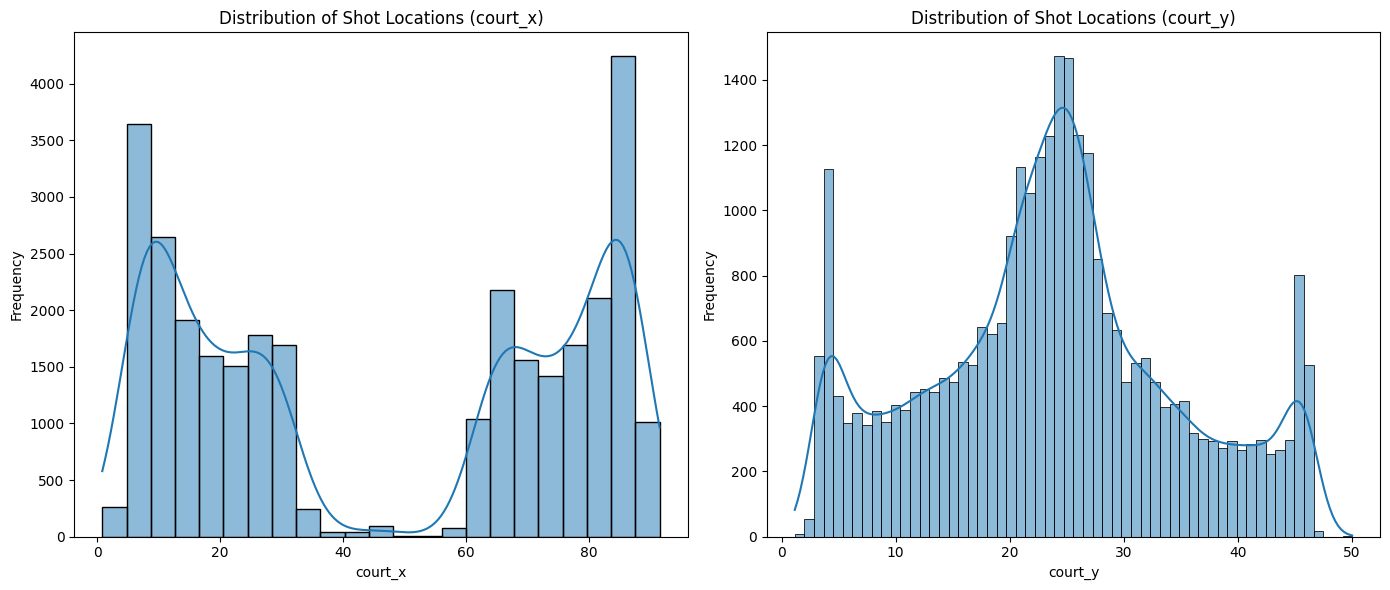

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(shooter_data_train['court_x'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Shot Locations (court_x)')
axes[0].set_xlabel('court_x')
axes[0].set_ylabel('Frequency')

sns.histplot(shooter_data_train['court_y'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Shot Locations (court_y)')
axes[1].set_xlabel('court_y')
axes[1].set_ylabel('Frequency')


plt.tight_layout() # Adjusts the plots so that they fit well
plt.show()

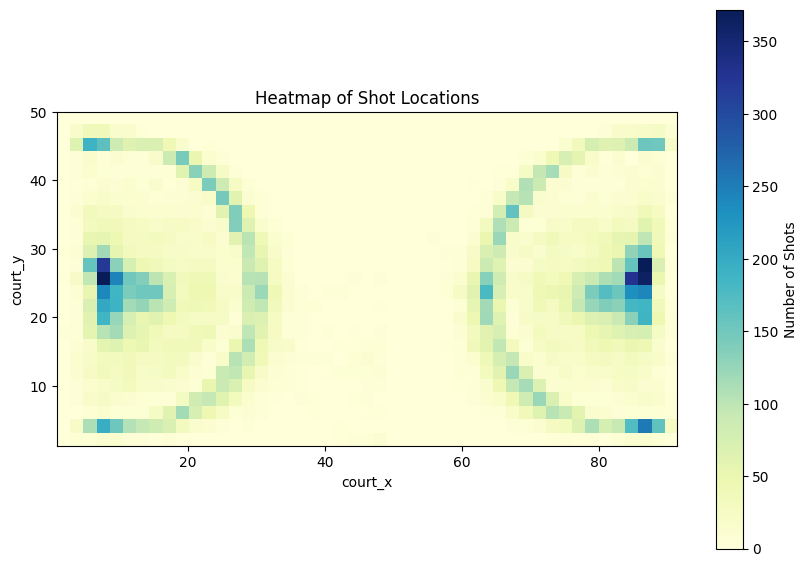

In [18]:
# define grid size for binning
grid_size = 2

# use numpy's histogram2d to bin the data
hist, xedges, yedges = np.histogram2d(shooter_data_train['court_x'], shooter_data_train['court_y'], bins=(int(94/grid_size), int(50/grid_size)))

# plot heatmap
plt.figure(figsize=(10, 7))
plt.imshow(hist.T, origin='lower', cmap='YlGnBu', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Number of Shots')
plt.title('Heatmap of Shot Locations')
plt.xlabel('court_x')
plt.ylabel('court_y')
plt.show()

#### Distribution of Shot Locations Analysis:
*Trends Observed*: 
- There are very few shots taken (and missed) from mid-court.
- The highest concentration of shots are near the basket.
- Mid-range shots are the least common shots.
- Interestingly, there are more shots missed on the left side of the basket up close on one side of the court.
    - This can be assumed not to be a trend worth investigating given what we know about basketball; the hoop that a team is shooting at will have no meaningful influence over shot selection.
    - This sheds light on the limitations of the size of the dataset, meaning we must be careful not to overfit the data in model experimentation.

### **Frequency of Offensive vs. Defensive Rebounds**

In [19]:
# merging the target variable to examing rebounding distribution
shooter_data_train = shooter_data_train.merge(train_pbp[['id', 'is_oreb']], on='id')

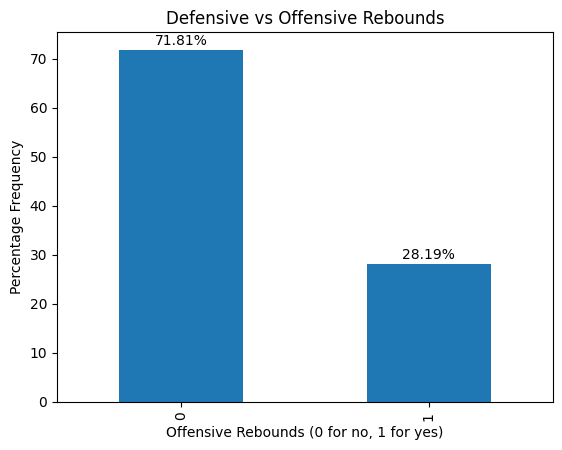

In [20]:
oreb_counts = shooter_data_train['is_oreb'].value_counts(normalize=True)  # normalize will give the fraction
oreb_counts_percentage = (oreb_counts * 100).round(2)  # convert to percentage and round off to two decimal points

ax = oreb_counts_percentage.plot(kind='bar')
plt.title('Defensive vs Offensive Rebounds')
plt.xlabel('Offensive Rebounds (0 for no, 1 for yes)')
plt.ylabel('Percentage Frequency')

# annotate bars with their percentage values
for index, value in enumerate(oreb_counts_percentage):
    ax.text(index, value + 1, str(value) + '%', ha='center')  # "+ 1" to position text above bars slightly

plt.show()

#### Rebound Type Frequencies Analysis:
*Trends Observed*: 
- We have an imbalanced dataset as most rebounds (`71.81%`) are defensive rebounds as expected.
- It could be beneficial to experiment with oversampling offensive rebound examples to allow the model to more effectively learn the circumstances in offensive rebounds.
    - The random nature of the ball's bounce off of the rim may limit the advantages of oversampling.
    - Offensive rebounds are often the result of a lucky bounce even when the offense is not in advantageous positioning.

---

## **Bivariate Analysis**

#### Shooting Position vs Offensive Rebounds

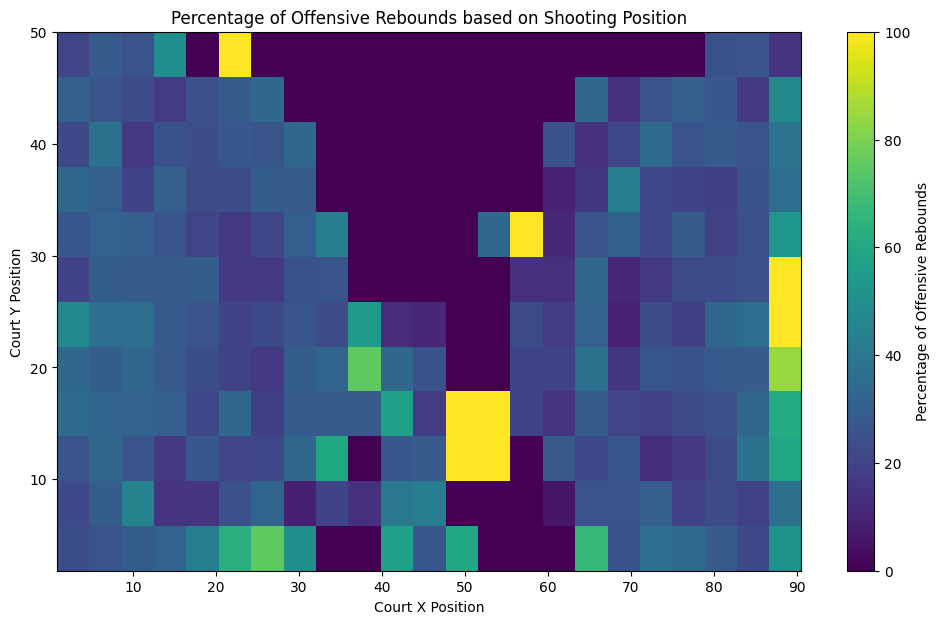

In [21]:
# define the grid size for binning
grid_size = 4

# histogram for shots resulting in offensive rebounds
oreb_hist, xedges, yedges = np.histogram2d(
    shooter_data_train[shooter_data_train['is_oreb'] == 1]['court_x'], 
    shooter_data_train[shooter_data_train['is_oreb'] == 1]['court_y'], 
    bins=(94//grid_size, 50//grid_size)
)

# histogram for all shots
all_shots_hist, _, _ = np.histogram2d(
    shooter_data_train['court_x'], 
    shooter_data_train['court_y'], 
    bins=(94//grid_size, 50//grid_size)
)

# calculate the percentage of offensive rebounds in each bin
percentage_oreb = np.where(all_shots_hist != 0, (oreb_hist / all_shots_hist) * 100, 0)

# plot heatmap
plt.figure(figsize=(12, 7))
plt.imshow(percentage_oreb.T, origin='lower', aspect='auto', cmap='viridis', 
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin=0, vmax=100)
plt.colorbar(label='Percentage of Offensive Rebounds')
plt.title('Percentage of Offensive Rebounds based on Shooting Position')
plt.xlabel('Court X Position')
plt.ylabel('Court Y Position')
plt.show()

#### Shooting Position vs Offensive Rebounding Heatmap Analysis:
*Trends Observed*: 
- It seems mid range jumpshots tend to be the worst shots for obtaining an offensive rebound (inefficient for yet another reason).
- There are small pockets of the court that have extremely high offensive rebounding rates, but referring back to our heatmap from before, these pockets have small samples.

### **Shot Distance from Hoop vs Offensive Rebounds**:

posx and posy should be finite values
posx and posy should be finite values


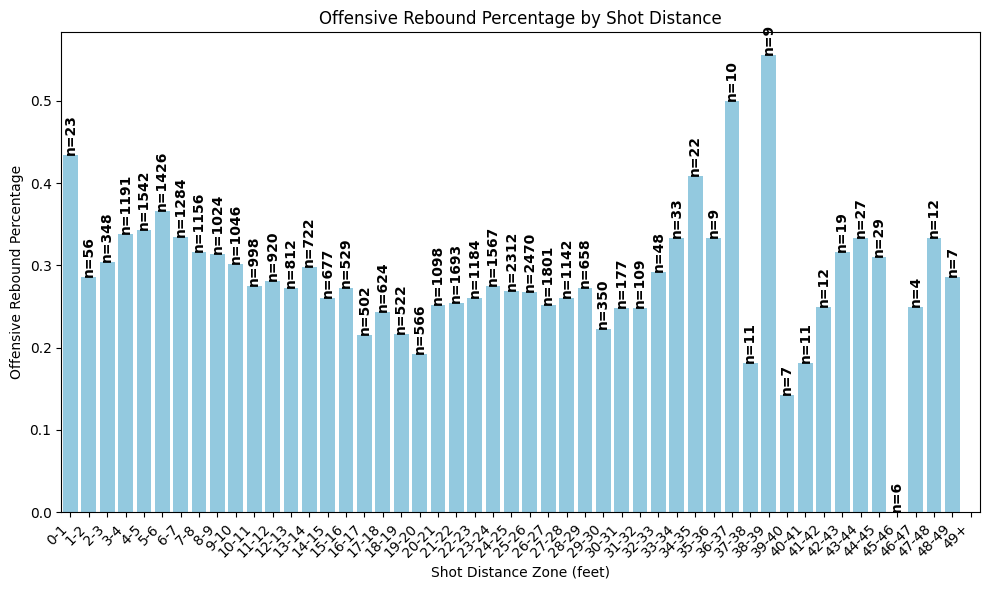

In [22]:
# categorize each shot into the corresponding zones based on shot distance

# define the shot distance bins cut by 1 foot
shot_distance_bins = [x for x in range(0, 51, 1)]

# update the zone_labels accordingly
zone_labels = [f'{dist}-{dist+1}' for dist in shot_distance_bins[:-1]]
zone_labels[-1] = f'{shot_distance_bins[-2]}+'
shooter_data_train['shot_distance_zone'] = pd.cut(shooter_data_train['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels, right=False)

# calculate the offensive rebound percentage and sample size for each shot distance zone
oreb_by_zone = shooter_data_train.groupby('shot_distance_zone')['is_oreb'].mean()
sample_size_by_zone = shooter_data_train['shot_distance_zone'].value_counts().reindex(zone_labels, fill_value=0)

# create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=oreb_by_zone.index, y=oreb_by_zone.values, color='skyblue')
plt.title('Offensive Rebound Percentage by Shot Distance')
plt.xlabel('Shot Distance Zone (feet)')
plt.ylabel('Offensive Rebound Percentage')
plt.xticks(rotation=45, ha='right')

# add sample size annotations to the bars
for index, value in enumerate(oreb_by_zone.values):
    plt.text(index, value, f'n={sample_size_by_zone.iloc[index]}', ha='center', va='bottom', fontweight='bold', rotation='vertical')

plt.tight_layout()
plt.show()

#### Shot Distance from Hoop vs. Offensive Rebounds Analysis:
*Trends Observed*: 
- More evidence that mid range jumpshots tend to be the worst shots for obtaining an offensive rebound.
    - There is a clear dip in offensive rebounding rate for shots from 17-21 feet.
- Shots very close to the basket may be more likely to be offensive rebounded because the shooter could be in good position to rebound or they may have broken down the defense and drawn help away from a rim crasher.
- Shots greater than 21 feet have a higher rebound rate than shots from 17-21 feet in the training data.
    - This may be because longer shots lead to longer rebounds.

Binning shot distances into zones may be beneficial because similar shots types are likely taken in each zone, so shot distance may have a complex relationship with offensive rebounding.

#### *Proposed Shot Zone Bins:* 0-7, 7-11, 11-17, 17-21, 21+

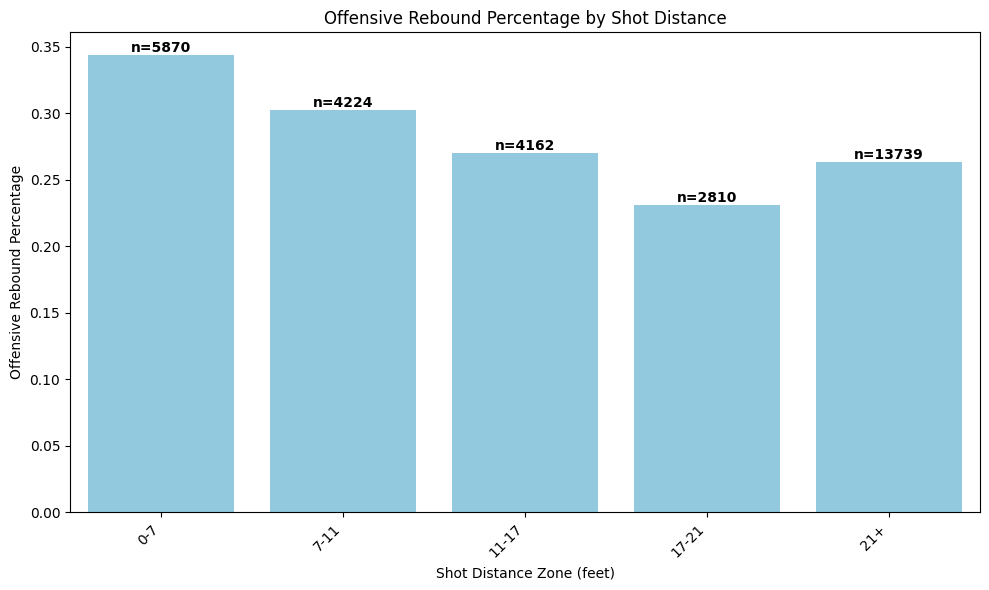

In [23]:
# categorize each shot into the corresponding zones based on shot distance

# define the shot distance bins
shot_distance_bins = [0, 7, 11, 17, 21, np.inf]

# define the zone labels accordingly
zone_labels = ['0-7', '7-11', '11-17', '17-21', '21+']

shooter_data_train['shot_distance_zone'] = pd.cut(shooter_data_train['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels, right=False)

# calculate the offensive rebound percentage and sample size for each shot distance zone
oreb_by_zone = shooter_data_train.groupby('shot_distance_zone')['is_oreb'].mean()
sample_size_by_zone = shooter_data_train['shot_distance_zone'].value_counts()

# create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=oreb_by_zone.index, y=oreb_by_zone.values, color='skyblue')
plt.title('Offensive Rebound Percentage by Shot Distance')
plt.xlabel('Shot Distance Zone (feet)')
plt.ylabel('Offensive Rebound Percentage')
plt.xticks(rotation=45, ha='right')

# add sample size annotations to the bars
for index, value in enumerate(oreb_by_zone.values):
    plt.text(index, value, f'n={sample_size_by_zone[oreb_by_zone.index[index]]}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

#### Shot Distance from Hoop Frequency Distribution Analysis (1/2):
The zones are fairly distinct in offensive rebounding percentage, but some sample sizes are small, so it is important to experiment with different bins.
- For use in modeling experimentation later on, I create dataframes that one-hot-encode the plays based on these 5 bins.

In [24]:
# categorize 'shooter_dist_from_hoop' column into corresponding zones
shooter_data_train['shot_distance_zone'] = pd.cut(shooter_data_train['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels)
shooter_data_test['shot_distance_zone'] = pd.cut(shooter_data_test['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels)


# perform One-Hot Encoding for the 'shot_distance_zone' column
df_encoded_5bins_train = pd.get_dummies(shooter_data_train, columns=['shot_distance_zone'])
df_encoded_5bins_test = pd.get_dummies(shooter_data_test, columns=['shot_distance_zone'])

#### *Alternative Shot Zone Bins:* 0-11, 11-21, 21+

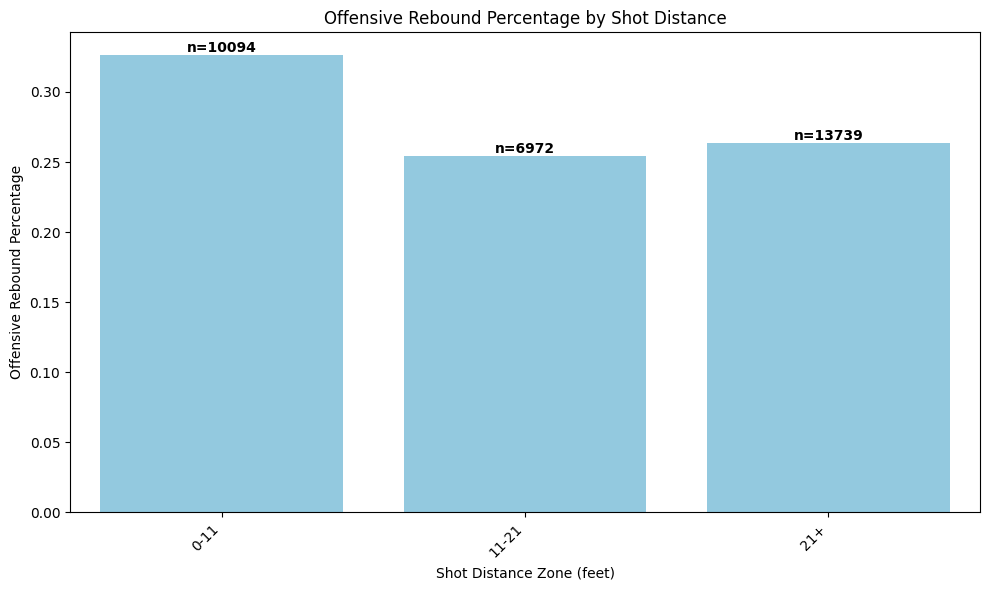

In [25]:
# categorize each shot into the corresponding zones based on shot distance

# define the shot distance bins
shot_distance_bins = [0, 11, 21, np.inf]

# define the zone labels accordingly
zone_labels = ['0-11', '11-21', '21+']

shooter_data_train['shot_distance_zone'] = pd.cut(shooter_data_train['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels, right=False)

# calculate the offensive rebound percentage and sample size for each shot distance zone
oreb_by_zone = shooter_data_train.groupby('shot_distance_zone')['is_oreb'].mean()
sample_size_by_zone = shooter_data_train['shot_distance_zone'].value_counts()

# create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=oreb_by_zone.index, y=oreb_by_zone.values, color='skyblue')
plt.title('Offensive Rebound Percentage by Shot Distance')
plt.xlabel('Shot Distance Zone (feet)')
plt.ylabel('Offensive Rebound Percentage')
plt.xticks(rotation=45, ha='right')

# add sample size annotations to the bars
for index, value in enumerate(oreb_by_zone.values):
    plt.text(index, value, f'n={sample_size_by_zone[oreb_by_zone.index[index]]}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


#### Shot Distance from Hoop Frequency Distribution Analysis (2/2):
These zones are more generalized, potentially benefiting the model by minimizing noise. They categorize shots as close range, mid-range, and long range.

- The relationship between player proximity to the basket and offensive rebounding might vary across these zones. This is because longer shots tend to result in longer rebounds.

In [26]:
# categorize 'shooter_dist_from_hoop' column into corresponding zones
shooter_data_train['shot_distance_zone'] = pd.cut(shooter_data_train['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels)
shooter_data_test['shot_distance_zone'] = pd.cut(shooter_data_test['shooter_dist_from_hoop'], bins=shot_distance_bins, labels=zone_labels)


# perform One-Hot Encoding for the 'shot_distance_zone' column
df_encoded_3bins_train = pd.get_dummies(shooter_data_train, columns=['shot_distance_zone'])
df_encoded_3bins_test = pd.get_dummies(shooter_data_test, columns=['shot_distance_zone'])

#### Calculating Distance of Defenders, Offensive Players from the basket
- These features will inform the spacing of the court at the time of the shot.
- If the defense is further out, it may make it harder to box out and there may be more lanes for offensive players to crash the boards.

In [27]:
def calculate_distance_from_hoop(row):
    # define the coordinates of the hoop
    hoop_coordinates = np.array([[4.0, 25.0], [90.0, 25.0]]) 
    def_coordinates = np.array([row['court_x'], row['court_y']])
    
    # calculate the distance
    distance = np.linalg.norm(def_coordinates - hoop_coordinates[int(row['which_hoop'])])
    return distance

In [28]:
# merging the information we have learned about which hoop is being shot at back to the training set
training_data = training_data.merge(shooter_data_train[['id', 'which_hoop']], left_on='id', right_on='id')
testing_data = testing_data.merge(shooter_data_test[['id', 'which_hoop']], left_on='id', right_on='id')

#### Pivoting the Data
- Ensuring there is a column for each offensive and defensive player's distance to the basket.
- We sort the players by their proximity to the basket.
- We calculate the mean distance as well to give a general sense of player proximity to the rim.
- These features may be limited in their value because they do not give a sense of where the individual players are located in relation to each other.

In [29]:
def process_defender_distances(df, offense):
    """
    Processes the input dataframe for players, calculates their distances from the hoop,
    ranks them by distance, and pivots the data to create features for the closest 
    players to the hoop.
    
    Parameters:
    - df (pandas.DataFrame): Input dataframe with player data.
    - offense (int): 1 for offense 0 for defense.
    
    Returns:
    - pandas.DataFrame: Processed dataframe with ranked distances.
    """
    
    # filter dataframe for team
    distance = df.loc[df.offense == offense].copy()
    
    # variable for prefix
    prefix = 'off' if offense == 1 else 'def'

    # calculate player distance from hoop
    distance[f'{prefix}_distance'] = distance.apply(calculate_distance_from_hoop, axis=1)
    
    # rank the players within each play (id) by distance from the hoop
    distance['rank'] = distance.groupby('id')[f'{prefix}_distance'].rank(method='first')

    # calculating mean distance from the hoop; groupby will resort by id the same way the rank calc does
    mean_dists = distance.groupby('id')[f'{prefix}_distance'].mean()
    
    # pivot the DataFrame to get features for closest_def_to_hoop, second_closest_def_to_hoop, and so on
    df_pivot = distance.pivot_table(index='id', columns='rank', values=f'{prefix}_distance').add_prefix(prefix + '_').reset_index()
    
    # rename the columns to be more descriptive
    df_pivot.columns = ['id'] + [f'closest_{prefix}_to_hoop', f'second_closest_{prefix}_to_hoop', f'third_closest_{prefix}_to_hoop', f'fourth_closest_{prefix}_to_hoop', f'fifth_closest_{prefix}_to_hoop']
    
    # fill missing values (if any) with a specific value, e.g., -1
    df_pivot.fillna(-1, inplace=True)

    # inserting mean values as a column
    df_pivot[f'{prefix}_distance_mean'] = mean_dists.values
    
    return df_pivot


In [30]:
# Pivots the data so there is one row per play
def_pivot = process_defender_distances(training_data, 0)
off_pivot = process_defender_distances(training_data, 1)
def_pivot_test = process_defender_distances(testing_data, 0)
off_pivot_test = process_defender_distances(testing_data, 1)

In [31]:
def_pivot.head()

,id,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,def_distance_mean
0,10-10,9.272356,10.056615,12.992872,14.782542,16.175073,12.655892
1,10-12,3.087682,4.322785,10.780686,15.429233,16.502760,10.024629
2,10-13,5.753939,12.180877,12.535084,14.027878,22.990277,13.497611
3,10-3,5.824702,10.965734,13.980346,17.154582,22.102294,14.005532
4,10-6,7.887358,11.555978,11.713705,17.826780,30.140720,15.824908


In [32]:
off_pivot.head()

,id,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,off_distance_mean
0,10-10,10.328278,15.046402,23.173309,25.311266,26.103727,19.992596
1,10-12,4.132574,17.754600,20.971792,23.246796,25.166567,18.254466
2,10-13,8.968685,17.949111,21.778384,23.195872,25.221159,19.422642
3,10-3,7.958549,13.436814,22.160137,24.473980,25.763053,18.758507
4,10-6,17.564172,21.746126,24.109830,25.010259,28.569046,23.399887


In [33]:
# combining the player distance dataframe on play id
pivot_train = def_pivot.merge(off_pivot, on='id')
pivot_test = def_pivot_test.merge(off_pivot_test, on='id')
pivot_train = pivot_train.merge(train_pbp[['id', 'is_oreb']], on='id')

### **Exploring Player Distance vs Offensive Rebounding**

#### Correlation to Offensive Rebounding

In [34]:
pd.DataFrame(pivot_train.corr()['is_oreb'])

,is_oreb
closest_def_to_hoop,-0.045311
second_closest_def_to_hoop,-0.056003
third_closest_def_to_hoop,-0.051258
fourth_closest_def_to_hoop,-0.039862
fifth_closest_def_to_hoop,-0.012574
def_distance_mean,-0.046557
closest_off_to_hoop,-0.093529
second_closest_off_to_hoop,-0.128443
third_closest_off_to_hoop,-0.104975
fourth_closest_off_to_hoop,-0.054370


#### Correlation Chart Analysis
The second closest offensive player has the highest absolute correlation to offensive rebounding (`-.128`), followed by the offensive mean (`-.111`), the third closest off player (`-.105`), and the closest offensive player (`-.093`).
- This trend may indicate that having multiple rebounders near the basket is crucial to securing an offensive rebound.

Each defender distance has a negative correlation with offensive rebounding, suggesting that defenders are actually further from the basket when they secure defensive rebounds as opposed to when there is an offensive rebound.
- This trend may be due to the fact that the area of the floor with the highest offensive rebounding percentage is up close shots, so defenders are likely drawn inward to contest the shot.
- It is unlikely that being further from the rim is beneficial to defensive rebounding, so this is an important note.
- Defender distance can still be a valuable feature when the model considers its relationship with shot distance zones.

Another important note is that player distance to the basket likely does not have a linear relationship with offensive rebounding. A player 2 feet from the basket will not necessarily have a better rebounding chance than a player 4 feet from the basket because rebounds will bounce away from the hoop.

#### Visualizing Player Distance vs Offensive Rebounding

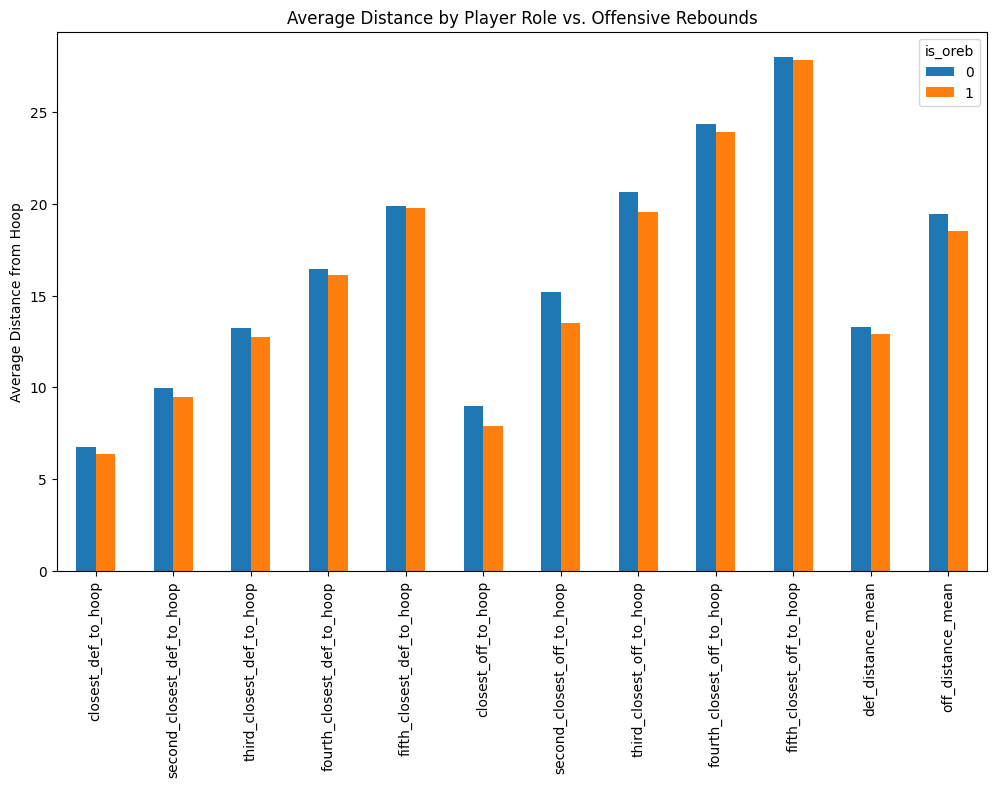

In [35]:
# calculating mean distance for each player by offensive and defensive rebounds
grouped = pivot_train.groupby('is_oreb').mean()[['closest_def_to_hoop', 'second_closest_def_to_hoop',
       'third_closest_def_to_hoop', 'fourth_closest_def_to_hoop',
       'fifth_closest_def_to_hoop', 'closest_off_to_hoop',
       'second_closest_off_to_hoop', 'third_closest_off_to_hoop',
       'fourth_closest_off_to_hoop', 'fifth_closest_off_to_hoop', 'def_distance_mean', 'off_distance_mean']]
# flipping the dataframe
grouped.transpose().plot(kind='bar', figsize=(12, 7))
plt.title('Average Distance by Player Role vs. Offensive Rebounds')
plt.ylabel('Average Distance from Hoop')
plt.show()

#### Average Distance by Player Role vs Offensive Rebounds Analysis:

1. Distance of Closest Defender:
    - For plays where an offensive rebound (`is_oreb=1`) occurred, the closest defender tends to be slightly closer to the hoop (`6.37` feet) as compared to plays where there was no offensive rebound (`6.73` feet). 
    - *Insight*: This requires some further investigation and how shot_distance_zone plays a role.

2. Other Defenders:
    - A similar trend continues for the `second`, `third`, `fourth`, and `fifth` closest defenders. They all tend to be closer to the hoop during successful offensive rebounds than during defensive rebounds.
    - *Insight*: The positioning of the entire defense close to the hoop seems to correlate with higher offensive rebound success.

3. Distance of Closest Offensive Player:
    - When an offensive rebound is successful, the closest offensive player is on average closer to the hoop (`7.91` feet) than in unsuccessful attempts (`8.95` feet).
    - *Insight*: Being closer to the hoop increases the chances of grabbing an offensive rebound. Offensive strategies might benefit from ensuring that at least one player is near the hoop during shots.

4. Other Offensive Players:
    - Just like with defenders, other offensive players (`second` to `fifth` closest) are generally closer to the hoop in plays with successful offensive rebounds.
    - *Insight*: It seems that having multiple offensive players close to the hoop enhances the team's chance of securing an offensive rebound. This could suggest the importance of aggressive offensive positioning during shooting attempts.

5. Overall Defensive vs. Offensive Presence:
    - Comparing the mean distances, defenders are generally closer to the hoop than offensive players. However, the gap is smaller in successful offensive rebound scenarios.
    - *Insight*: Defensive teams often position themselves between the offensive players and the hoop. However, reducing the distance gap between offensive players and defenders appears to be a key factor in successful offensive rebounds.

Having multiple players near the basket is important to the offense's chance at securing an offensive rebound.


#### Visualizing Offensive Rebounding Success vs Mean Defender Distance in each Shot Distance Zone
- Here, we investigate the hypothesis that defender distance correlates negatively with offensive rebounding because they will naturally be closer to the basket on shots from close range which result in more offensive rebounds.

In [36]:
# to see all columns in dfs
pd.set_option('display.max_columns', None)

In [37]:
# merging shot distanc zone info
def_mean_vis_data = pivot_train.merge(df_encoded_5bins_train[['id', 'shot_distance_zone_0-7', 'shot_distance_zone_7-11', 'shot_distance_zone_11-17', 'shot_distance_zone_17-21', 'shot_distance_zone_21+']], on='id')

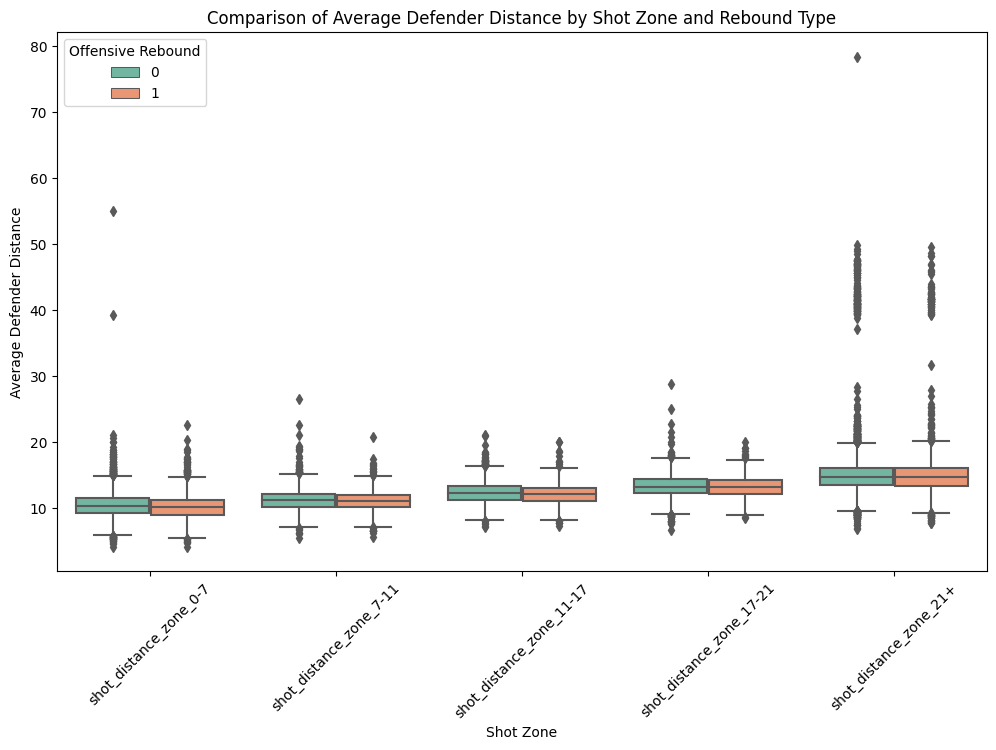

In [38]:
# melt the dataframe for shot zones to get them in a single column
df_melted = def_mean_vis_data.melt(id_vars=['def_distance_mean', 'is_oreb'], 
                    value_vars=['shot_distance_zone_0-7', 'shot_distance_zone_7-11', 'shot_distance_zone_11-17', 'shot_distance_zone_17-21', 'shot_distance_zone_21+'],
                    var_name='shot_zone', value_name='zone_value')

# filter only the rows where zone_value is 1
df_melted = df_melted[df_melted['zone_value'] == 1]

plt.figure(figsize=(12, 7))

# create the boxplot
sns.boxplot(x='shot_zone', y='def_distance_mean', hue='is_oreb', data=df_melted, palette="Set2")
plt.title('Comparison of Average Defender Distance by Shot Zone and Rebound Type')
plt.ylabel('Average Defender Distance')
plt.xlabel('Shot Zone')
plt.xticks(rotation=45)
plt.legend(title='Offensive Rebound')
plt.show()


#### Box Plot Takeaways
- This plot helped identify a potential outlier with a defensive rebound occuring with an average defender distance from the hoop of ~80 ft which seems highly unlikely (Potential Roscoe Smith situation).
- Outliers in average defender distance are likely unsuccessful shot attempts on fast break opportunities; Average defender distance > 20 is a probable fast break.
- Let's use a bar plot instead to better understand the relationship we are investigating. The outliers increase the y range such that it is difficult to compare defender distances.

https://www.youtube.com/watch?v=MxsoHBnjOzY

Roscoe doing Roscoe things

#### Defender Distance by Shot Zone vs Offensive Rebounding

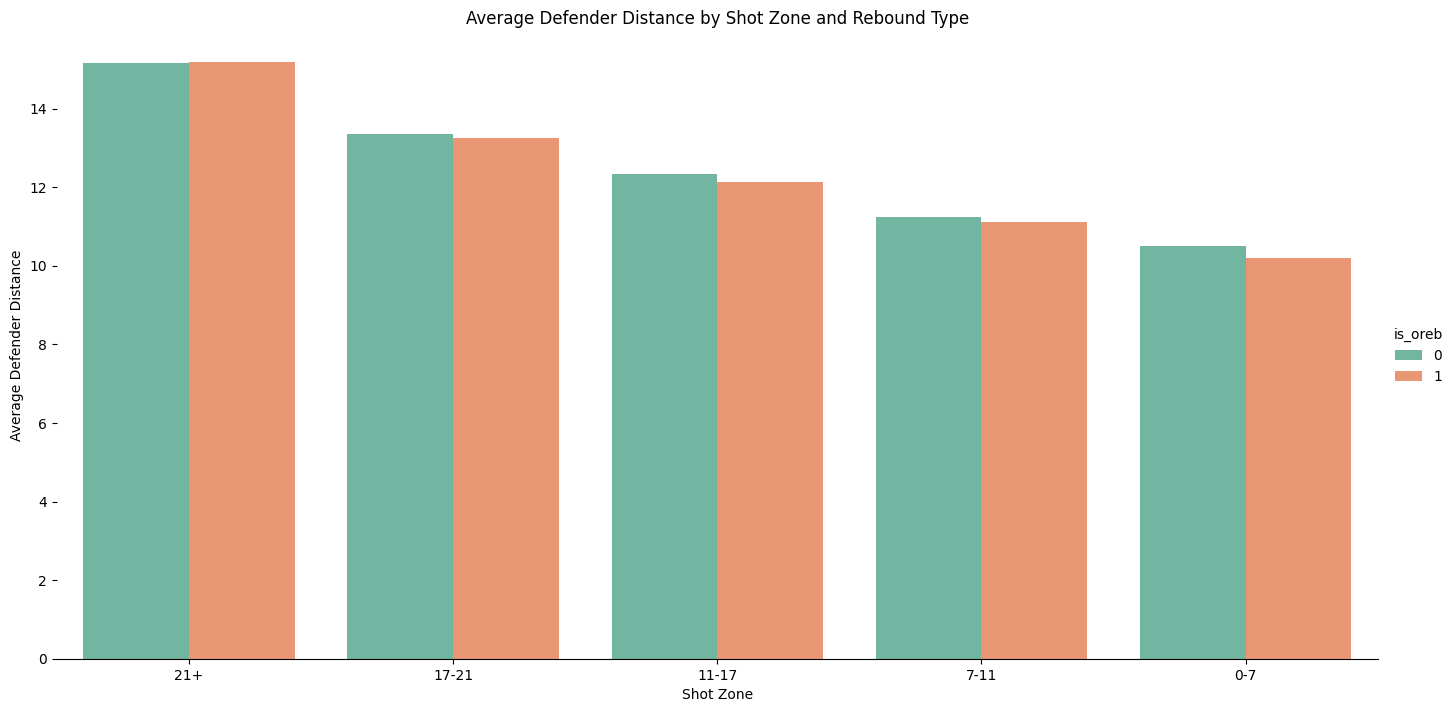

In [39]:
# create a new DataFrame to calculate the means
means_df = def_mean_vis_data.groupby(['is_oreb', 'shot_distance_zone_0-7', 'shot_distance_zone_7-11', 'shot_distance_zone_11-17', 'shot_distance_zone_17-21', 'shot_distance_zone_21+'])['def_distance_mean'].mean().reset_index()

# create a 'shot_zone' column to store the zone labels based on the new zones
means_df['shot_zone'] = '0-7'
means_df.loc[means_df['shot_distance_zone_7-11'] == 1, 'shot_zone'] = '7-11'
means_df.loc[means_df['shot_distance_zone_11-17'] == 1, 'shot_zone'] = '11-17'
means_df.loc[means_df['shot_distance_zone_17-21'] == 1, 'shot_zone'] = '17-21'
means_df.loc[means_df['shot_distance_zone_21+'] == 1, 'shot_zone'] = '21+'

g = sns.catplot(x='shot_zone', y='def_distance_mean', hue='is_oreb', data=means_df, kind='bar', palette="Set2", height=7, aspect=2)
g.despine(left=True)
g.set_axis_labels("Shot Zone", "Average Defender Distance")

plt.title('Average Defender Distance by Shot Zone and Rebound Type')
plt.show()


#### Takeaways
The hypothesis that defender distance correlates negatively with offensive rebounding only because they will naturally be closer to the basket on shots from close range (which result in more offensive rebounds) does not appear to be the case. With the excpetion of long range shots (very narrowly, `15.16 ft` to `15.18 ft`), defenders distance to the rim is on average further for defensive rebounds than offensive, Let's dive into why defenders may be further from the basket on successful defensive rebounds:
- Successful Boxouts - When the defense is in control of the defensive boards, they will have successfully made contact with their boxout responsibility and pushed them away from the hoop.
- Compromised Defense - If defenders are on average closer to the hoop, this could be an indicator that a help defender was needed to impede an offensive threat from getting to the hoop. Naturally, this creates more opportune angles for offensive rebounders to position themselves for a missed shot.

Feature engineering considerations: defender distance will be highly dependent on the offense's positioning, so it will be key to highlight their relative distance to the basket

In [40]:
df_encoded_3bins_train.head(3)

,id,court_x,court_y,annotation_code,offense,shooter,shooter_dist_from_hoop,which_hoop,game_number,play_number,is_oreb,shot_distance_zone_0-11,shot_distance_zone_11-21,shot_distance_zone_21+
0,2-2,69.994331,39.674616,s,1,1,24.810706,1.0,2,2,0,0,0,1
1,2-3,16.896578,13.154704,s,1,1,17.510933,0.0,2,3,0,0,1,0
2,2-4,87.963438,3.638889,s,1,1,21.457974,1.0,2,4,0,0,0,1


# **Baseline Model**
- I create a baseline model using only player distance from the hoop and shot distances zones to measure our model experimentation against later on.

#### Merging Shot Distance Zone Data with Player Distances

In [41]:
# merging shot distance zones with distance data
df_encoded_train_5bins = df_encoded_5bins_train.merge(pivot_train.drop(columns='is_oreb'), on='id').drop(columns=['court_x', 'court_y', 'annotation_code', 'offense', 'shooter', 
                                                                                                                'shooter_dist_from_hoop', 'which_hoop', 'game_number', 'play_number'], axis=1)
df_encoded_test_5bins = df_encoded_5bins_test.merge(pivot_test, on='id').drop(columns=['court_x', 'court_y', 'annotation_code', 'offense', 'shooter', 'shooter_dist_from_hoop', 'which_hoop'], axis=1)

In [42]:
# merging shot distance zones with distance data
df_encoded_train_3bins = df_encoded_3bins_train.merge(pivot_train.drop(columns='is_oreb'), on='id').drop(columns=['court_x', 'court_y', 'annotation_code', 'offense', 'shooter', 
                                                                                                                'shooter_dist_from_hoop', 'which_hoop', 'game_number', 'play_number'], axis=1)
df_encoded_test_3bins = df_encoded_3bins_test.merge(pivot_test, on='id').drop(columns=['court_x', 'court_y', 'annotation_code', 'offense', 'shooter', 'shooter_dist_from_hoop', 'which_hoop'], axis=1)

In [43]:
df_encoded_train_5bins.head(3)

,id,is_oreb,shot_distance_zone_0-7,shot_distance_zone_7-11,shot_distance_zone_11-17,shot_distance_zone_17-21,shot_distance_zone_21+,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,def_distance_mean,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,off_distance_mean
0,2-2,0,0,0,0,0,1,7.633964,12.696228,18.308802,20.050756,21.203196,15.978589,10.641781,11.430082,22.130707,24.810706,33.674014,20.537458
1,2-3,0,0,0,0,1,0,6.951207,8.954561,13.582648,15.019406,15.342599,11.970084,17.510933,20.646002,20.747640,25.787367,27.439075,22.426203
2,2-4,0,0,0,0,0,1,7.585616,8.649579,17.621429,25.116109,27.285472,17.251641,5.814472,21.457974,24.860005,27.413357,34.175635,22.744289


#### Scaling the Data

In [44]:
def scale_distances(df, df_test, zones):
    # using a StandardScaler (instead of MinMax) to reduce the impact of outliers
    scaler = StandardScaler()

    data = df.copy()
    data_test = df_test.copy()
    # extract the continuous features from the DataFrame
    continuous_features = data.iloc[:, zones + 2:]  # the continuous features start from the number of zones + 2
    continuous_features_test = data_test.iloc[:, zones + 1:] # test does not have target variable, so 1 index less

    # fit and transform the continuous features using the StandardScaler
    # fitting on the train set only
    scaled_continuous_features = scaler.fit_transform(continuous_features)
    scaled_continuous_features_test = scaler.transform(continuous_features_test)

    # convert the scaled_continuous_features back to a DataFrame with the original column names
    scaled_continuous_df = pd.DataFrame(scaled_continuous_features, columns=continuous_features.columns)
    scaled_continuous_df_test = pd.DataFrame(scaled_continuous_features_test, columns=continuous_features_test.columns)

    # concatenate the scaled continuous features with the categorical features
    data = pd.concat([data.iloc[:, :zones + 2:], scaled_continuous_df], axis=1)
    data_test = pd.concat([data_test.iloc[:, :zones + 1], scaled_continuous_df_test], axis=1)
    return data, data_test

In [45]:
# scaling dataframes
X_dist_3bins, X_test_dist_3bins = scale_distances(df_encoded_train_3bins, df_encoded_test_3bins, 3)
X_dist_5bins, X_test_dist_5bins = scale_distances(df_encoded_train_5bins, df_encoded_test_5bins, 5)

In [46]:
X_dist_5bins.head(3)

,id,is_oreb,shot_distance_zone_0-7,shot_distance_zone_7-11,shot_distance_zone_11-17,shot_distance_zone_17-21,shot_distance_zone_21+,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,def_distance_mean,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,off_distance_mean
0,2-2,0,0,0,0,0,1,0.280024,0.707359,1.194021,0.876404,0.314668,0.786057,0.394397,-0.562562,0.385818,0.156934,1.509469,0.383356
1,2-3,0,0,0,0,1,0,0.090078,-0.208605,0.106853,-0.320979,-1.069568,-0.331162,1.759438,1.021993,0.090994,0.426478,-0.133723,0.914279
2,2-4,0,0,0,0,0,1,0.266573,-0.283265,1.035903,2.081879,1.751264,1.140872,-0.564888,1.161601,0.967612,0.875227,1.641669,1.003692


In [47]:
# finalizing X and y by removing id and the target from X
y_dist = X_dist_3bins['is_oreb']
X_dist_3 = X_dist_3bins.drop(columns=['id', 'is_oreb'])
X_dist_5 = X_dist_5bins.drop(columns=['id', 'is_oreb'])

#### Model Choice

For our analysis on the relationship between player positions, shot distances, and the likelihood of offensive rebounds, I opted for the XGBoost algorithm. XGBoost, which stands for eXtreme Gradient Boosting, is renowned for its efficiency and performance, frequently standing out in machine learning competitions. The key reasons for this choice include:

1. *Ensemble Learning*: XGBoost operates on the gradient boosting framework, which builds an ensemble of weak prediction models, typically decision trees. This ensemble approach is especially adept at tackling complex datasets like ours, where interactions between features (like player positions and shot distances) are nuanced.

2. *Regularization*: Unlike many other tree-based algorithms, XGBoost incorporates L1 (Lasso Regression) and L2 (Ridge Regression) regularization. This ensures that our model doesn't overfit to the training data, a common concern when working with intricate sports datasets that contain multifaceted relationships like we have already encountered in EDA.

3. *Flexibility*: XGBoost can be easily integrated with other machine learning frameworks and is amenable to a range of hyperparameter tuning options. This flexibility ensures we can optimize the model for our specific task and dataset.

In summary, given the intricacies of our basketball analysis and the inherent challenges in predicting rebounds, XGBoost emerged as a natural choice due to its robustness, efficiency, and adaptability.

In [48]:
# create the XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=5)

# perform cross-validation
cross_val_scores = cross_val_score(model, X_dist_3, y_dist, cv=5, scoring='neg_log_loss')

# since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())

Average Log Loss: 0.5811479984473633


In [49]:
# create the XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=5)

# perform cross-validation
cross_val_scores = cross_val_score(model, X_dist_5, y_dist, cv=5, scoring='neg_log_loss')

# since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
log_loss_scores = -cross_val_scores

# print the average log loss across all folds
print('Average Log Loss:', log_loss_scores.mean())

Average Log Loss: 0.5809927158531752


#### Analyzing XGBoost Model Performance Across Different Shot Distance Zones

When building a predictive model, especially in sports analytics where the granularity of data can offer rich insights, it's essential to experiment with how we segment or categorize our features. In basketball, the shot distance, given its evident influence on player positions and strategies, serves as an ideal feature for such experimentation.

##### Results:

- *3 Shot Distance Zones*: This broader categorization yielded an Average Log Loss of `0.58115`.
- *5 Shot Distance Zones*: A more detailed categorization resulted in a slightly better Average Log Loss of `0.58099`.

##### Discussion:

The difference in performance between the two categorizations is marginal. This could suggest a few points:

1. The addition of two more shot distance zones offers only a slight enhancement in our model's predictive accuracy. 
2. The improvement in the 5-zone model might be attributed to capturing more intricate relationships in the data. However, the near-identical performance indicates our XGBoost model might already be capturing most of the variance with just the three zones.
3. Given the negligible difference in Log Loss, we should weigh the benefits of a finer granularity against its potential costs in terms of complexity and interpretability.

##### Recommendations:

While the model with 5 shot distance zones marginally outperforms its counterpart, we should consider the broader implications. Simpler models, like the 3-zone one, could be preferable for their ease of interpretation, especially when speaking with stakeholders less familiar with data intricacies; discussing shots as short-range, mid-range, and long-range may be easier to understand. However, if the primary goal is to maximize predictive accuracy, then every small advantage, such as that provided by the 5-zone model, becomes valuable.


In [50]:
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', eval_metric='logloss', max_depth=3, min_child_weight=3)
model.fit(X_dist_5, y_dist)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

#### Feature Importances in Predicting Offensive Rebounds

- In the realm of basketball analytics, understanding feature importances not only aids in model interpretability but also provides deeper insights into on-court dynamics and strategies. The XGBoost model has provided the following feature importances for predicting offensive rebounds:

In [51]:
def plot_feat_importances(columns, feature_importances):
    # Plot the importances
    plt.figure(figsize=(10, len(columns)/2))  # Adjust the figure size
    plt.title('Feature Importances')
    plt.barh(columns, feature_importances)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

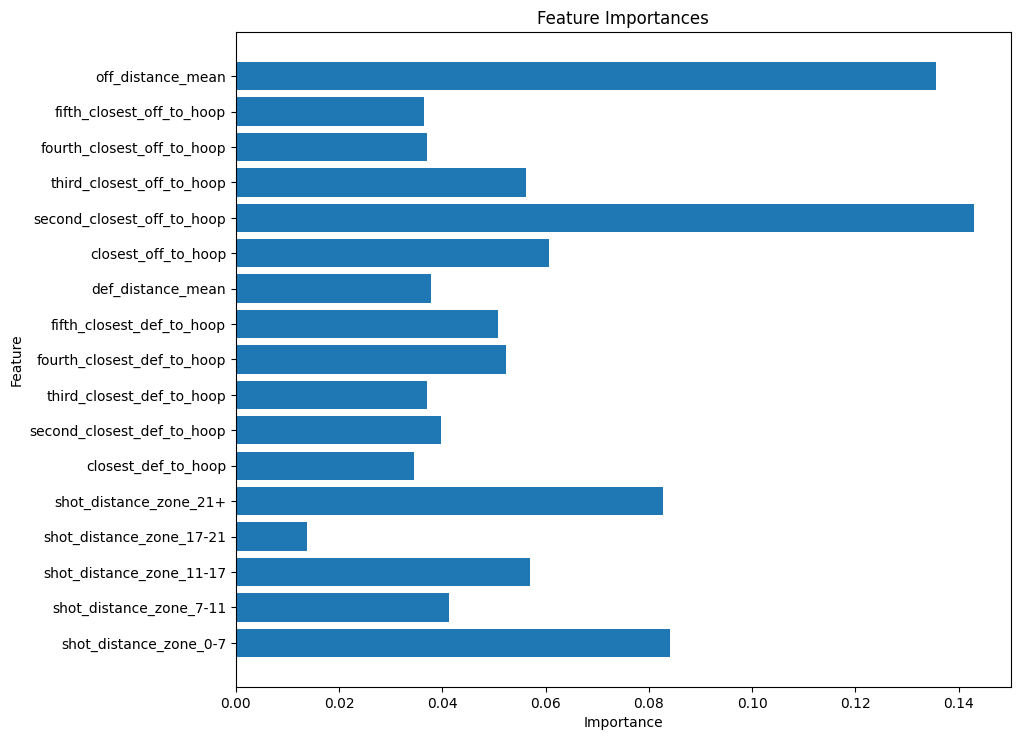

In [52]:
plot_feat_importances(X_dist_5.columns, model.feature_importances_)



#### Key Feature Importance Insights:

1. Shot Distance Zones:
    - **`0-7 feet` (0.0841)**: This zone, closest to the basket, is crucial in predicting offensive rebounds, likely due to many shots and subsequent rebound opportunities occurring here.
    - **`7-11 feet` (0.0413)** and **`11-17 feet`(0.0570)**: These mid-range distances show moderate importance. The decrease in importance from the closest zone may indicate fewer shots from this area or different rebound dynamics.
    - **`17-21 feet` (0.0138)**: Reduced importance here may reflect fewer shot attempts from this distance.
    - **`21+ feet` (0.0828)**: Despite being farther, this zone's importance is nearly on par with the closest zone, suggesting the long rebounds from 3-pointers play a significant role.

2. Defensive Players' Distance to Hoop:
    - The distances of the individual defensive players (ranging from **0.0346 to 0.0522**) show similar levels of importance. This underscores the team aspect of defensive rebounding, where positioning of all players matters.
    - **`Defensive Mean Distance` (0.0379)**: The average distance of defenders showcases their collective positioning, and its significance might indicate the defensive setup during shots.

3. Offensive Players' Distance to Hoop:
    - **`Second Closest Offensive Player to Hoop` (0.1430)**: This stands out as the most influential feature. It indicates that while the closest offensive player is vital, having a second player nearby is crucial for securing offensive rebounds.
    - **`Offensive Mean Distance` (0.1357)**: This emphasizes the collective effort on the offensive boards, suggesting a balanced offensive rebounding approach is fruitful.
    - Other offensive players' distances also hold relevance, with values around **0.036 to 0.0606**, highlighting the importance of team positioning.


---

# **Complex Feature Engineering**
- To this point we have constructed a high performing model using distances of shots and players from the basket. The next step will be to incorporate angles and relative positions to get a better sense of how well teams are positioned for rebounds at the time of a shot. There will be in depth explanations of the rationale for each feature engineered. Feature importance scores and visualizations will be the primary tools for assessing the effectiveness of each feature.

## **Assigning Boxout Responsibilities**

*Offensive Rebounding Player Assignment Algorithm*

Understanding which players are most likely to box out one another is crucial to understanding the chances of an offensive rebound. If an offensive player is in front of a defensive player, this cannot be captured by a distance to the hoop metric without knowing which players will be competing with each other for position. To optimally choose which offensive player a defensive rebounder should box out, I will use the distance from defensive player to the offensive player and the betweenness centrality of the offensive player. Offensive players closer to the hoop will be prioritized by using betweenness centrality because there will be edges connecting offensive players to the hoop with weights reflecting the inverse of their distance.

This algorithm is designed to optimize the assignment of defensive players to their respective offensive players during a basketball game to enhance the team's chances of securing a defensive rebound.

Step 1: Creating a Spatial Graph

The algorithm starts by constructing a spatial graph that represents the relationships between offensive players and the hoop (basket). Each player and the hoop are represented as nodes in the graph, and weighted edges are added between offensive players and the hoop as well as offensive players and other offensive players based on their spatial proximity. This graph reflects the players' positioning on the court and helps identify the best offensive players to box out for each defender.

Step 2: Betweenness Centrality

The algorithm then calculates a measure called 'betweenness centrality' for each offensive player in the graph. This metric quantifies how often an offensive player lies on the shortest path between other offensive players and the hoop. High betweenness centrality indicates that a player is in a critical position on the court, and boxing out such players becomes crucial for effective rebounding. In basketball terms, offensive players with high betweenness centrality are in critical positions that can impact the overall offensive flow and create more scoring opportunities. Therefore, these players become important targets for defensive players to box out and prevent them from securing offensive rebounds.

Step 3: Optimizing Player Assignments

Next, the algorithm aims to optimize the assignment of defensive players to offensive players. To achieve this, it creates a cost matrix that considers both the distance between defensive and offensive players and the offensive players' betweenness centrality. The Hungarian algorithm is then employed to find the best possible player assignments that prioritize players with higher betweenness centrality while minimizing the distances to the boxout responsibility.

Step 4: Iterative Refinement

To further improve the assignments, the algorithm iteratively updates the player assignments and optimizes the betweenness centrality and distances. This iterative refinement process enhances the quality of player matchups, ensuring that no defensive player is left without a specific offensive player to box out.

Step 5: Assigning Remaining Defenders

After the iterations, there may still be some defenders without an offensive player assigned to them. To address this, the algorithm finds the closest unassigned offensive player for each remaining defender based on the distances.

In [53]:
def calculate_distance(point1, point2):
    """
    Calculates the Euclidean distance between two points.
    
    Parameters:
        - point1 (numpy array): The coordinates of the first point.
        - point2 (numpy array): The coordinates of the second point.
        
    Returns:
        - float: The Euclidean distance between point1 and point2.
    """
    return np.linalg.norm(point1 - point2)

def construct_graph(offensive_players_, hoop, distances):
    """
    Constructs a graph where nodes represent offensive players and the basketball hoop, 
    and edges represent the inverse of the distance between them.
    
    Parameters:
        - offensive_players_ (list of numpy arrays): List of coordinates for the offensive players.
        - hoop (numpy array): The coordinates of the basketball hoop.
        - distances (dict): A dictionary containing pairwise distances between points.
        
    Returns:
        - NetworkX Graph: A graph constructed based on the provided distances.
    """
    graph = nx.Graph()
    for player1 in offensive_players_:
        for player2 in offensive_players_:
            if not np.array_equal(player1, player2):
                distance = calculate_distance(player1, player2)
                graph.add_edge(tuple(player1), tuple(player2), weight=1.0 / distance)
        distance_to_hoop = distances[(tuple(player1), tuple(hoop))]
        graph.add_edge(tuple(player1), tuple(hoop), weight=1.0 / distance_to_hoop)
    
    return graph

def calculate_betweenness_centralities(graph):
    """
    Calculates the betweenness centrality for all nodes in a graph.
    
    Parameters:
        - graph (NetworkX Graph): A graph for which to compute the betweenness centrality.
        
    Returns:
        - dict: A dictionary with nodes as keys and betweenness centralities as values.
    """
    return nx.betweenness_centrality(graph, weight='weight')

def calculate_cost_matrix(defenders_, offensive_players_, distances, betweenness_centralities):
    """
    Calculates a cost matrix based on distance and betweenness centrality.
    
    Parameters:
        - defenders_ (list of numpy arrays): List of coordinates for the defenders.
        - offensive_players_ (list of numpy arrays): List of coordinates for the offensive players.
        - distances (dict): A dictionary containing pairwise distances between points.
        - betweenness_centralities (dict): A dictionary of nodes and their respective betweenness centrality.
        
    Returns:
        - numpy array: A matrix representing the cost of assigning defenders to offensive players.
    """
    num_defenders = len(defenders_)
    num_offensive_players = len(offensive_players_)
    cost_matrix = np.zeros((num_defenders, num_offensive_players))

    for i, defender in enumerate(defenders_):
        for j, offensive_player in enumerate(offensive_players_):
            distance_cost = distances[(tuple(defender), tuple(offensive_player))]
            betweenness_cost = -betweenness_centralities[tuple(offensive_player)]
            # betweenness centralities are between 0 and 1, so multiplying by a factor of 5 to emphasize its cost
            cost_matrix[i, j] = distance_cost + betweenness_cost

    return cost_matrix

def assign_offensive_players(defenders_, offensive_players_, hoop, num_iterations=5):
    """
    Assigns each defender to an offensive player based on distance and betweenness centrality, 
    using the linear_sum_assignment algorithm.
    
    Parameters:
        - defenders_ (list of numpy arrays): List of coordinates for the defenders.
        - offensive_players_ (list of numpy arrays): List of coordinates for the offensive players.
        - hoop (numpy array): The coordinates of the basketball hoop.
        - num_iterations (int, optional): The number of times to iterate over the assignment process. 
          Defaults to 5.
          
    Returns:
        - dict: A dictionary mapping each defender to an assigned offensive player.
        - dict: A dictionary to store betweenness centralities for each iteration.
    """
    distances = {}
    for defender in defenders_:
        for offensive_player in offensive_players_:
            distances[(tuple(defender), tuple(offensive_player))] = calculate_distance(defender, offensive_player)
        distances[(tuple(defender), tuple(hoop))] = calculate_distance(defender, hoop)

    for offensive_player in offensive_players_:
        distances[(tuple(offensive_player), tuple(hoop))] = calculate_distance(offensive_player, hoop)

    assignments = {}
    centralities_store = {} # a dictionary to store betweenness centralities for each iteration
    unassigned_defenders = list(defenders_)

    for _ in range(num_iterations):
        graph = construct_graph(offensive_players_, hoop, distances)
        betweenness_centralities = calculate_betweenness_centralities(graph)
        centralities_store.update(betweenness_centralities)  # store the betweenness centralities

        cost_matrix = calculate_cost_matrix(defenders_, offensive_players_, distances, betweenness_centralities)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        for i, j in zip(row_ind, col_ind):
            defender = tuple(defenders_[i])
            offensive_player = tuple(offensive_players_[j])
            assignments[defender] = offensive_player
            if any(np.array_equal(defender, a) for a in unassigned_defenders):
                unassigned_defenders = [x for x in unassigned_defenders if not (x == defender).all()]

    for defender in unassigned_defenders:
        min_distance = float('inf')
        closest_offensive_player = None
        for offensive_player in offensive_players_:
            distance = distances[(tuple(defender), tuple(offensive_player))]
            if distance < min_distance:
                min_distance = distance
                closest_offensive_player = tuple(offensive_player)
        assignments[tuple(defender)] = closest_offensive_player

    return assignments, centralities_store

# example usage:
defenders = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4]])
offensive_players = np.array([[5, 0], [6, 1], [7, 2], [8, 3], [9, 4]])
hoop = np.array([10, 5])

assignments = assign_offensive_players(defenders, offensive_players, hoop)
print(assignments)

({(0, 0): (5, 0), (1, 1): (6, 1), (2, 2): (7, 2), (3, 3): (8, 3), (4, 4): (9, 4)}, {(5, 0): 0.25, (6, 1): 0.0, (7, 2): 0.0, (8, 3): 0.0, (9, 4): 0.0, (10, 5): 0.25})


In [54]:
# making copies of the dataset to be used in assigning responsibilities
copy_training_data = training_data.copy()
copy_testing_data = testing_data.copy()

In [55]:
def assign_responsibilities(data):
    """
    For each play instance, assigns each defender to an offensive player based on 
    distance and betweenness centrality. Also appends the offensive player coordinates 
    and betweenness centrality to the defender's data.
    
    Parameters:
        - data (pandas DataFrame): A dataframe containing the following columns:
          * 'id': A unique identifier for each play instance.
          * 'offense': Binary column where 1 indicates an offensive player and 0 indicates a defender.
          * 'court_x', 'court_y': The x and y coordinates of players on the court.
          * 'which_hoop': Binary column where 0 indicates one hoop and 1 indicates the other.
          
    Returns:
        - pandas DataFrame: A modified version of the input dataframe that includes:
          * 'off_x', 'off_y': The x and y coordinates of the assigned offensive player.
          * 'betweenness_centrality': The betweenness centrality of the assigned offensive player.
    """
    grouped_data = data.groupby('id')
    assignments_list = []
    centralities_list = []
    list_of_ids = []

    for id, group in grouped_data:
        defenders_ = group[group['offense'] == 0][['court_x', 'court_y']].values
        offensive_players_ = group[group['offense'] == 1][['court_x', 'court_y']].values
        hoop = [4, 25] if group['which_hoop'].iloc[0] == 0 else [90, 25]
        assignments, centralities = assign_offensive_players(defenders_, offensive_players_, hoop)
        assignments_list.append(assignments)
        centralities_list.append(centralities)
        list_of_ids.append(id)

    assignments_dict = dict(zip(list_of_ids, assignments_list))
    centralities_dict = dict(zip(list_of_ids, centralities_list))
    
    def_data = data.loc[data.offense == 0]
    off_coords = def_data.apply(lambda row: assignments_dict[row['id']][(row['court_x'], row['court_y'])], axis=1)
    def_data[['off_x', 'off_y']] = off_coords.apply(pd.Series)
    def_data['betweenness_centrality'] = def_data.apply(lambda row: centralities_dict[row['id']][(row['off_x'], row['off_y'])], axis=1)

    return def_data

This code block takes ~5 minutes to run on CPU. CSV data is provided for convenience.

In [56]:
# paired player datasets built
if RUN_CELL:
    def_training_data = assign_responsibilities(copy_training_data)
    def_testing_data = assign_responsibilities(copy_testing_data)

In [58]:
def_training_data = pd.read_csv('data/def_training_data.csv').drop('Unnamed: 0', axis=1)
def_testing_data = pd.read_csv('data/def_testing_data.csv').drop('Unnamed: 0', axis=1)

In [59]:
# def_training_data.to_csv('def_training_data.csv')
# def_testing_data.to_csv('def_testing_data.csv')

In [60]:
# cleaning the dataset
# court_x/y are the defensive players coordinates after the responsibility assignments
def_training_data.rename(columns={'court_x': 'def_x', 'court_y': 'def_y'}, inplace=True)
def_testing_data.rename(columns={'court_x': 'def_x', 'court_y': 'def_y'}, inplace=True)
# merging the original location data to know which pairing's offensive player is the shooter
def_training_data = def_training_data.merge(train_locs, left_on=['id', 'off_x', 'off_y'], right_on=['id', 'court_x', 'court_y'])
def_testing_data = def_testing_data.merge(test_locs, left_on=['id', 'off_x', 'off_y'], right_on=['id', 'court_x', 'court_y'])
# court_x/y are from the recently joined train_locs and have the same values as the off_x/y
def_training_data.drop(columns=['court_x', 'court_y'], inplace=True)
def_testing_data.drop(columns=['court_x', 'court_y'], inplace=True)
# assigning the annotation codes as either defensive or offensive 
def_training_data.rename(columns={'annotation_code_x': 'annotation_code_def', 'annotation_code_y': 'annotation_code_off'}, inplace=True)
def_testing_data.rename(columns={'annotation_code_x': 'annotation_code_def', 'annotation_code_y': 'annotation_code_off'}, inplace=True)

#### Visualizing an Example Play's Responsibility Pairings

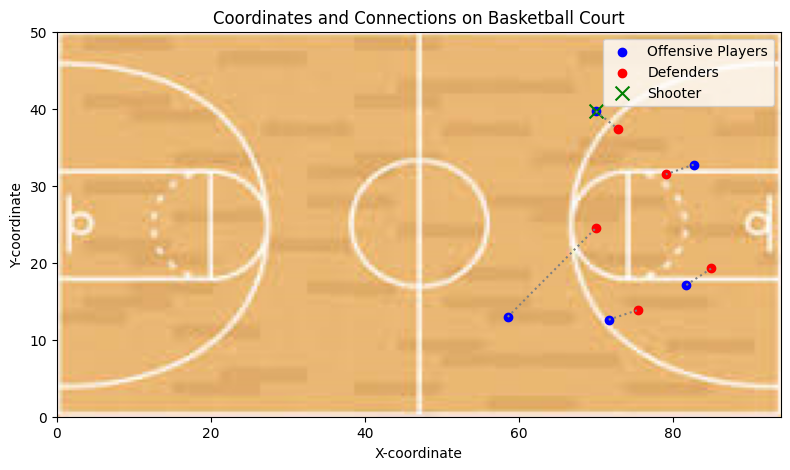

In [63]:
# sample data
df = pd.DataFrame(def_training_data[0:5]) 

# load the images
court_image = Image.open('images/court_dims.png')

# plot the basketball court
plt.figure(figsize=(10, 5))
plt.imshow(court_image, extent=[0, 94, 0, 50])  # Extent based on court dimensions


# plotting the coordinates and connecting the pairs of players with lines
plt.scatter(df['off_x'], df['off_y'], color='blue', label='Offensive Players')
plt.scatter(df['def_x'], df['def_y'], color='red', label='Defenders')

# connect the pairs of players with lines
for i, row in df.iterrows():
    plt.plot([row['off_x'], row['def_x']], [row['off_y'], row['def_y']], color='gray', linestyle='dotted')

# putting a green x over the shooter
shooter_row = df[df['annotation_code_off'] == 's'].iloc[0]
plt.scatter(shooter_row['off_x'], shooter_row['off_y'], color='green', marker='x', s=100, label='Shooter')

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Coordinates and Connections on Basketball Court')
plt.legend()
plt.show()

### Observations and Limitations of Boxout Responsibilities
*Observations*:
- With this play, the algorithm seems to have done a good job in assigning reponsibilities as the players are logically matched to close by and important to box out players.
- In this example, the offensive player on the left block is in an advantageous rebound positioning.
- The goal of the next section will be to capture these types of advantages by leveraging the player pairing coordinate data.

*Potential Limitations*:
- Although the process for pairing players follows a logical set of steps, there is no guarantee that the pairings match player behavior.
    - The dataset at hand does not have access to key factors in boxout decision making like the size of players and temporal information like their speed, acceleration, or direction. Players may choose to box out larger players that are seen as bigger threats if it meant veering from the most logical boxout pairing based on spacing alone. If a player is darting towards the rim, they would also be a prioritized threat as compared to a player fading away from the rim for a shot. 
    - Players may make judgement errors in deciding which player to box out. 
    - Many players will not need to be boxed out at all because they are getting back on defense to guard against transition opportunities. This would lead to more defensive players available to help clear out offensive rebounding threats.

Despite these limitations, the pairings will have utility because they inform how clear the path to the basket is for each offensive player.

## **Using Responsibilities to Build Features**
- Now that we know which offensive player each defensive player is responsible for boxing out, there are a host of new ways to develop features based on angles (between pairs of players and the hoop) and distances (from hoop to player and player to player)

#### Visualizing Player Pairing Relative Angles

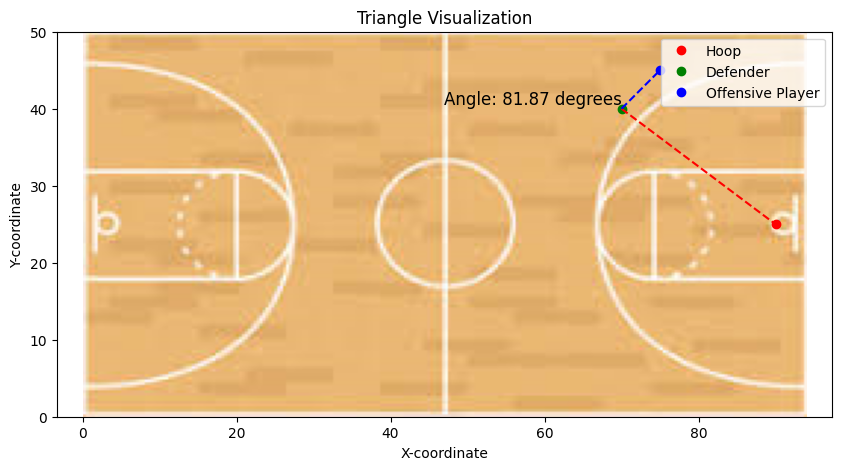

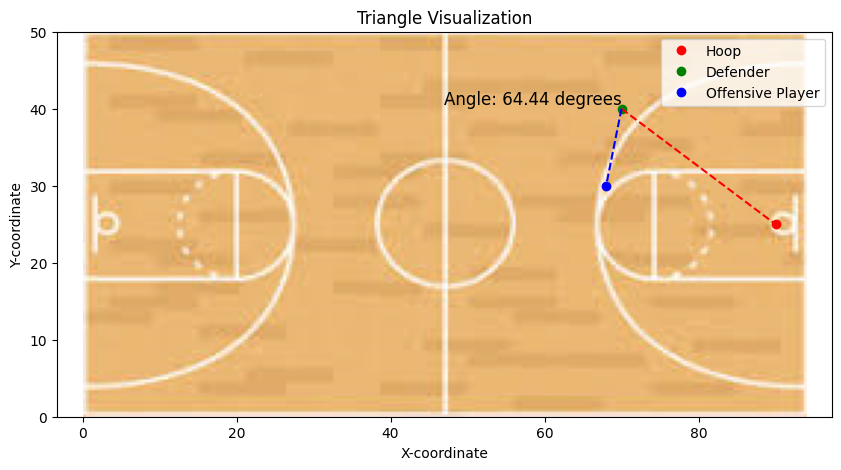

In [64]:

def calculate_angle(x1, y1, vx, vy, x2, y2):
    '''
    Calculate the angle (in degrees) formed between two points and a vertex.

    Given two points (x1, y1) and (x2, y2), this function computes the angle 
    between these two points with respect to a vertex (vx, vy). The result is 
    always an acute angle (less than or equal to 90 degrees).

    Parameters:
    - x1, y1: Coordinates of the first point.
    - vx, vy: Coordinates of the vertex.
    - x2, y2: Coordinates of the second point.

    Returns:
    - float: The acute angle (in degrees) between the two points with the vertex as the reference.
    '''
    ang = math.degrees(math.atan2(y2 - vy, x2 - vx) - math.atan2(y1 - vy, x1 - vx))
    # adjust the angle to be between 0 and 180 degrees
    ang = abs(ang) % 360
    if ang > 180:
        return 360 - ang
    else:
        return ang


def plot_triangle(hoop, defender, offensive_player, angle):
    # load the images
    court_image = Image.open('images/court_dims.png')

    # plot the basketball court
    plt.figure(figsize=(10, 5))
    plt.imshow(court_image, extent=[0, 94, 0, 50])  # Extent based on court dimensions
    
    # plot hoop, defender, and offensive player
    plt.plot(hoop[0], hoop[1], 'ro', label='Hoop')
    plt.plot(defender[0], defender[1], 'go', label='Defender')
    plt.plot(offensive_player[0], offensive_player[1], 'bo', label='Offensive Player')

    # connect lines to form the triangle
    plt.plot([defender[0], hoop[0]], [defender[1], hoop[1]], 'r--')
    plt.plot([defender[0], offensive_player[0]], [defender[1], offensive_player[1]], 'b--')

    # add angle text
    angle_text = f'Angle: {angle:.2f} degrees'
    plt.text(defender[0], defender[1], angle_text, ha='right', va='bottom', fontsize=12)

    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.title('Triangle Visualization')
    plt.axis('equal')
    plt.show()
    
# Example 1: Offensive player in front of the defender (good position for a rebound)
hoop = (90, 25)
defender = (70, 40)
offensive_player = (75, 45)
angle = calculate_angle(hoop[0], hoop[1], defender[0], defender[1], offensive_player[0], offensive_player[1])
plot_triangle(hoop, defender, offensive_player, angle)

# Example 2: Offensive player behind the defender (good position for the offensive player)
hoop = (90, 25)
defender = (70, 40)
offensive_player = (68, 30)
angle = calculate_angle(hoop[0], hoop[1], defender[0], defender[1], offensive_player[0], offensive_player[1])
plot_triangle(hoop, defender, offensive_player, angle)

# # Example 3: Offensive player to the left of the defender
# hoop = (90, 25)
# defender = (70, 40)
# offensive_player = (65, 45)
# angle = calculate_angle(hoop[0], hoop[1], defender[0], defender[1], offensive_player[0], offensive_player[1])
# plot_triangle(hoop, defender, offensive_player, angle)

# # Example 4: Offensive player to the right of the defender
# hoop = (90, 25)
# defender = (70, 40)
# offensive_player = (75, 35)
# angle = calculate_angle(hoop[0], hoop[1], defender[0], defender[1], offensive_player[0], offensive_player[1])
# plot_triangle(hoop, defender, offensive_player, angle)

#### Rebounding Angles and Their Implications:

In our visual analysis, we've delineated the dynamics of offensive and defensive player positioning:

1. *Offensive Advantage with Lower Angles:* As the angle decreases, the offensive player is in a more favorable position to secure a rebound. A lower angle signifies the offensive player is in front of their defender and positioned to have a clear path to the ball.

2. *Defensive Dominance with Higher Angles:* Conversely, a higher angle hints at the defensive player's ability to successfully box out their assignment. The greater the angle, the more likely the defensive player can impede the offensive player's path to the rebound.

3. *Relevance of Distance Between Players:* The distance between the players is another important factor in the likelihood of a successful boxout. If the defender is closer, they may be less likely to get juked as they can more easily close the gap and initiate contact.

4. *Feature Engineering Potential:* Understanding these angles and distances and their implications provides a strong foundation for crafting impactful features that can boost the model's predictive capability.

Features to include: 
- Angle with defense as vertex (hoop defender shooter)
- Distance between defenders and offensive players
- Area of the triangle formed by off/def/hoop

Considerations for boxout angle, offensive rebounding relationship: Generally speaking, if the defender is between his man and the basket, that player is more likely to get the rebound. This may not necessarily hold true in situations up close to the basket. There is such thing as being too deep under the basket because the ball will usually bounce at least a few feet off the rim. If an offensive player is right on their back, they may be in a more opportune position to get the rebound.

#### Cleaning Paired Player Data

In [65]:
# creating binary shooter column
def_training_data['shooter'] = def_training_data['annotation_code_off'].apply(lambda x: 1 if x == 's' else 0)
def_testing_data['shooter'] = def_testing_data['annotation_code_off'].apply(lambda x: 1 if x == 's' else 0)
# calculating hoop coordinates
def_training_data['hoop_x'] = def_training_data['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
def_training_data['hoop_y'] = 25
def_testing_data['hoop_x'] = def_testing_data['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
def_testing_data['hoop_y'] = 25

#### Visualizing Shooter Angles

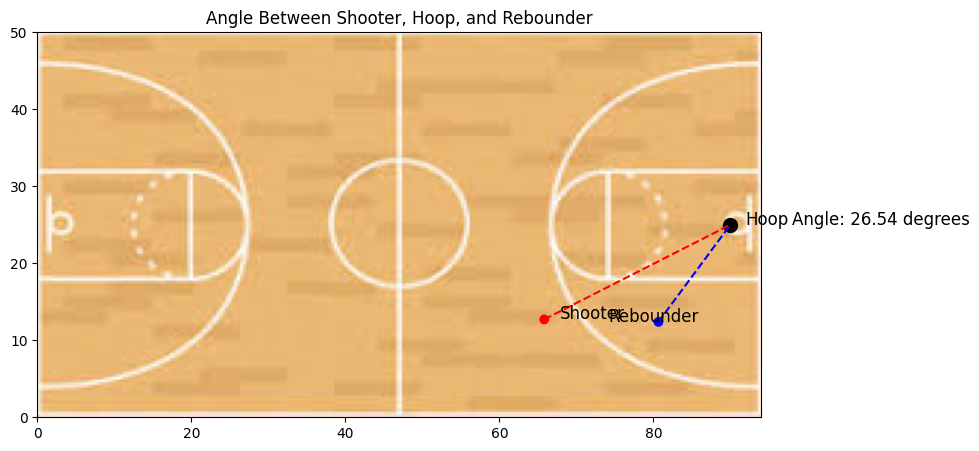

In [66]:
# Dummy data
shooter_x = np.random.rand() * 94
shooter_y = np.random.rand() * 50
rebounder_x = np.random.rand() * 94
rebounder_y = np.random.rand() * 50

hoop_y = 25  # center of the court
hoop_x = 90 if shooter_x > 47 else 4

angle_shooter_rebounder = calculate_angle(shooter_x, shooter_y, hoop_x, hoop_y, rebounder_x, rebounder_y)

# plotting
plt.figure(figsize=(10, 5))
plt.imshow(court_image, extent=[0, 94, 0, 50]) 
plt.xlim(0, 94)
plt.ylim(0, 50)

# plot positions
plt.scatter([shooter_x, rebounder_x], [shooter_y, rebounder_y], color=['red', 'blue'])
plt.scatter(hoop_x, hoop_y, color='black', s=100)

# annotate points
plt.text(shooter_x + 2, shooter_y, 'Shooter', fontsize=12)
plt.text(rebounder_x - 6.5, rebounder_y, 'Rebounder', fontsize=12)
plt.text(hoop_x + 2, hoop_y, 'Hoop', fontsize=12)

# draw lines to visualize the angle
plt.plot([shooter_x, hoop_x], [shooter_y, hoop_y], 'r--')
plt.plot([rebounder_x, hoop_x], [rebounder_y, hoop_y], 'b--')

# display the angle
plt.text(hoop_x + 8, hoop_y, f'Angle: {angle_shooter_rebounder:.2f} degrees', fontsize=12)

plt.title('Angle Between Shooter, Hoop, and Rebounder')
plt.show()

#### Shooter Angles and Their Implications
There are several important angles to understand when it comes to the shooter's position.

1. *Angle from shooter to the hoop to the rebounder*:

Missed shots bounce randomly off the rim, however there is a general tendency for shots to bounce to the weakside (or with an equal and opposite force). In terms of physics, the behavior of a basketball rebounding off the rim can be understood through the principle of angle of incidence equalling angle of reflection. This is particularly true in nearly elastic collisions, where the ball's angle of approach to the rim will generally match its angle of departure. Having that said, a larger angle may make the rebounder more likely to obtain a rebound, depending on where the shot is taken from. From the corner, the larger angle may be desirable, while from straight-on a smaller angle may be desirable.

2. *Angle from shooter to hoop to mid-court*:

This angle will capture whether a shot is in the corner or in front of the rim. Higher amounts of players near the basket on the weakside for a corner shot may lead to a better offensive rebounding chance. Weakside presence may conversely be less important for a shot from the top of the key.

3. *Feature Engineering Potential:*

Understanding these angles will help us engineer features that capture where the ball is likely to bounce based on where it is shot on the court.

Features to include: 
- Angle from shooter to hoop to rebounder
- Angle from shooter to hoop to mid-court
- Sum of weakside off/def players within 10 feet of the basket
- Binary corner variable

## **Feature Descriptions for Basketball Analytics in Offensive Rebounding Prediction**
In basketball analytics, the calculation of player dynamics on the court helps teams make informed decisions. With the goal of capturing these dynamics, we delve into various features representing player interactions, positions, and game moments.

#### Distances
- `def_distance_to_hoop`: Distance from each defensive player to the hoop.  
  - **Significance**: Defender distances influence over defensive rebounding success is highly dependent on the relative positioning of offensive players.

- `off_distance_to_hoop`: Distance from each offensive player to the hoop.  
  - **Significance**: Players closer to the hoop are more likely to successfully rebound.

- `distance_def_off`: Euclidean distance between defensive and offensive players.  
  - **Significance**: Greater distance may offer offensive players more room to secure a rebound or evade a defender's boxout attempt.

- `shot_distance`: Distance from the shooter to the hoop.  
  - **Significance**: Longer shots generally lead to longer rebounds, affecting who is likely to retrieve them.

- `distance_def_shooter`: Distance from each defensive player to the shooter.  
  - **Significance**: Defensive players closer to the shooter may be less likely to secure a rebound due to momentum away from the hoop.

#### Geometric Features
- `triangle_area`: Area of the triangle formed by the shooter, defender, and an offensive player.  
  - **Significance**: Larger areas might indicate more space for offensive players to maneuver for a rebound.

- `off_spacing`: Area formed by offensive players around the hoop.
  - **Significance**: More area could indicate the offense is further from the hoop and the floor is well spaced.
  
- `def_spacing`: Area formed by defensive players around the hoop.
  - **Significance**: More area could indicate better spacing, leaving the defense vulnerable to long rebounds.

#### Angles
- `shooter_angle`: Angle formed by the shooter, the basket, and mid-court.
  - **Significance**: The shooter's angle will inform where the best positioning will be to secure a rebound

- `rebound_angle_defense`, `rebound_angle_offense`: Angle between each defensive player, the basket, and the shooter.  
  - **Significance**: Depending on the shooter's angle, the size of the angle will determine the best rebound position (large angles are good for corner shots that will more often bounce to the weakside).

- `degrees_from_optimal_angle_defense`, `degrees_from_optimal_angle_offense`: Difference in degrees for a players location and the ball's path for an equal and opposite angle from the shooter.  
  - **Significance**: Players along the optimal angle will be more likely to have the ball bounce towards them.

#### Interaction Features
- `dist_interaction`: Combines `def_distance_to_hoop` and `distance_def_off`.  
  - **Significance**: An interaction term that may capture nuanced spatial relationships affecting rebounding chances.

#### Zone Information
- `zone_def`: Zone where the defensive player is during the shot.
  - One of three values: opposite (45 degrees surrounding optimal angle), front-rim (the ball is more likely to hit the front rim and bounce back towards the shooter), or no-man's-land (player is in neither zone).
  - https://grantland.com/features/how-rebounds-work/#:~:text=As%20you%20can%20see%2C%20more,just%20beyond%20the%20restricted%20area.
  - **Significance**: Being in an optimal zone may offer better chances to secure a rebound.

- `zone_off`: Similar to `zone_def`, but for offensive players.  
  - **Significance**: Offensive players in optimal zones may have a higher chance of rebounding.

#### Positioning and Count Metrics
- `def_within_10ft`, `off_within_10ft`, `def_within_10ft_weakside`, `off_within_10ft_weakside`, `weakside_diff`:
  - **Significance**: These features indicate player positioning relative to the hoop and could influence rebound outcomes.

- `def_front_rim_10ft_count`, `off_front_rim_10ft_count`, `def_opposite_10ft_count`, `off_opposite_10ft_count`:
  - **Significance**: Metrics are more specific than weak/strong side.

#### Box-out Metrics
- `boxout_position`, `log_boxout_angle`, `contextual_boxout_position`:  
  - **Significance**: These features quantify how effectively players are positioned for box-outs, a crucial part of rebounding.
  - *Boxout Position Feature:* The positioning during a boxout is vital for securing rebounds. The formula used for `boxout_position` is:
  $$ \text{Boxout Position} = \log_{10}\left( \text{off\_distance\_to\_hoop}^{1.35} + \text{boxout\_angle} \right) $$

  The exponentiation of `off_distance_to_hoop` aims to prioritize the distance of an offensive player to the basket. This indicates that the further the offensive player is from the basket, the higher their potential to successfully box out. The exponent value `1.35` was derived after iterative experimentation for optimal model performance.

  - *Log Transformed Features:* To normalize and capture non-linear relationships, features like `boxout_angle` are log-transformed. This helps in stabilizing the variance and making the data more suitable for machine learning models.


#### Aggregate Features
These are generated based on the groupby on 'id', and they provide aggregated metrics for most of the above features for each play.
  - **Significance**: Aggregate features can encapsulate the general behavior or tendency of players or events, providing a macro view that can be predictive.


In [67]:
# distance function
def calculate_dist(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# function to calculate area of a triangle
def triangle_area(x1, y1, x2, y2, x3, y3):
    return 0.5 * abs(x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))

def angle_from_sideline(player_x, player_y, hoop_x, hoop_y):
    # calculate the angle using the hoop as the vertex
    sideline = [hoop_x, 0]  # x-coordinate of hoop and 0 for y (sideline)
    return calculate_angle(sideline[0], sideline[1], hoop_x, hoop_y, player_x, player_y)

def determine_zone(player_x, player_y, shooter_x, shooter_y, hoop_x, hoop_y):
    # calculate the angle of the shot with respect to the hoop and baseline
    shot_angle = angle_from_sideline(shooter_x, shooter_y, hoop_x, hoop_y)
    
    # invert the shot's y value to get the opposite direction
    opposite_angle = angle_from_sideline(shooter_x, 50 - shooter_y, hoop_x, hoop_y)
    
    # calculate player's angle with respect to the hoop and baseline
    player_angle = angle_from_sideline(player_x, player_y, hoop_x, hoop_y)
    
    # calculate the bounds for the optimal region (45-degree slice)
    left_bound_optimal = (opposite_angle - 22.5) % 360
    right_bound_optimal = (opposite_angle + 22.5) % 360

    # check if player is in the optimal region
    if left_bound_optimal < right_bound_optimal:
        if left_bound_optimal <= player_angle <= right_bound_optimal:
            return 'opposite'
    else:  # If the optimal region wraps around the 0/360 boundary
        if player_angle >= left_bound_optimal or player_angle <= right_bound_optimal:
            return 'opposite'
    
    # calculate the bounds for the second optimal region (22.5 degrees to the left and right of shooter)
    left_bound_second_optimal = (shot_angle - 22.5) % 360
    right_bound_second_optimal = (shot_angle + 22.5) % 360

    # check if player is in the second optimal region
    if left_bound_second_optimal < right_bound_second_optimal:
        if left_bound_second_optimal <= player_angle <= right_bound_second_optimal:
            return 'front-rim'
    else:  # if the second optimal region wraps around the 0/360 boundary
        if player_angle >= left_bound_second_optimal or player_angle <= right_bound_second_optimal:
            return 'front-rim'

    # if player is not in any of the optimal regions
    return 'no-mans-land'

def calc_dist_angle_features(the_data):
    data = the_data.copy()
    # calculate player distances to the hoop
    data['def_distance_to_hoop'] = data.apply(lambda x: calculate_dist(x.def_x, x.def_y, x.hoop_x, x.hoop_y), axis=1)
    data['off_distance_to_hoop'] = data.apply(lambda x: calculate_dist(x.off_x, x.off_y, x.hoop_x, x.hoop_y), axis=1)

    # distances between players
    data['distance_def_off'] = data.apply(lambda x: calculate_dist(x.def_x, x.def_y, x.off_x, x.off_y), axis=1)

    # shooter coordinates for each play
    shooter_coords = data[data['shooter'] == 1][['id', 'off_x', 'off_y']].set_index('id')

    # shot distance
    data['shot_distance'] = data.apply(lambda x: calculate_dist(x.hoop_x, x.hoop_y, shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y']), axis=1)

    # calculating the distance of each defensive player to the shooter
    data['distance_def_shooter'] = data.apply(lambda x: calculate_dist(x.def_x, x.def_y, shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y']), axis=1)

    # area of triangle formed by shooter, defender, and offensive player
    data['triangle_area'] = data.apply(lambda x: triangle_area(x.def_x, x.def_y, x.off_x, x.off_y, shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y']), axis=1)

    # angle between each player the basket and the shooter
    data['rebound_angle_defense'] = data.apply(lambda x: calculate_angle(shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y'], x.hoop_x, x.hoop_y, x.def_x, x.def_y), axis=1)
    data['rebound_angle_offense'] = data.apply(lambda x: calculate_angle(shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y'], x.hoop_x, x.hoop_y, x.off_x, x.off_y), axis=1)

    # angle formed by the basket the defender and their assigned box out responsibility
    data['boxout_angle'] = data.apply(lambda x: calculate_angle(x.hoop_x, x.hoop_y, x.def_x, x.def_y, x.off_x, x.off_y), axis=1)

    # interaction features
    data['dist_interaction'] = data['def_distance_to_hoop'] * data['distance_def_off']

    # feature to decide how many players are within 10 feet of the hoop
    data['def_within_10ft'] = data['def_distance_to_hoop'] < 10
    data['off_within_10ft'] = data['off_distance_to_hoop'] < 10

    # features to help better understand where the shot is taken from
    data['shooter_angle'] = data.apply(lambda x: calculate_angle(shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y'], x.hoop_x, 25, 47, 25), axis=1)
    data['corner'] = data.apply(lambda x: 1 if x['shooter_angle'] > 45 else 0, axis=1)

    # calculating the optimal rebound angle, hypothesized to be the weakside at the same angle from mid court
    data['optimal_angle'] = data.apply(lambda x: calculate_angle(shooter_coords.loc[x['id'], 'off_x'], 50 - shooter_coords.loc[x['id'], 'off_y'], x.hoop_x, 25, 47, 25), axis=1)

    data['degrees_from_optimal_angle_offense'] = data.apply(lambda x: calculate_angle(shooter_coords.loc[x['id'], 'off_x'], 50 - shooter_coords.loc[x['id'], 'off_y'], x.hoop_x, 25, x.off_x, x.off_y), axis=1)
    data['degrees_from_optimal_angle_defense'] = data.apply(lambda x: calculate_angle(shooter_coords.loc[x['id'], 'off_x'], 50 - shooter_coords.loc[x['id'], 'off_y'], x.hoop_x, 25, x.def_x, x.def_y), axis=1)

    # feature to decide how many players are within 10 feet on the opposit side of the court as the shot is taken (56% of missed shots will bounce to the weak side)
    data['shooter_top_half'] = data.apply(lambda x: shooter_coords.loc[x['id'], 'off_y'] > 25, axis=1) 
    data['def_within_10ft_weakside'] = (data['def_distance_to_hoop'] < 10) & \
                                  np.where(data['shooter_top_half'], data['def_y'] < 25, data['def_y'] > 25)
    data['off_within_10ft_weakside'] = (data['off_distance_to_hoop'] < 10) & \
                                  np.where(data['shooter_top_half'], data['off_y'] < 25, data['off_y'] > 25)

    data['def_within_10ft_weakside'] = data['def_within_10ft_weakside'].apply(int)
    data['off_within_10ft_weakside'] = data['off_within_10ft_weakside'].apply(int)
    
    data['weakside_diff'] = data['def_within_10ft_weakside'] - data['off_within_10ft_weakside']
    data.drop(columns='shooter_top_half', inplace=True)

    # boxout position calculation
    data['boxout_position'] = np.log10((data['off_distance_to_hoop']**1.35) + (data['boxout_angle']))

    # categorizing rebound positioning based on shot angle
    data['zone_def'] = data.apply(lambda x: determine_zone(x.def_x, x.def_y, shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y'], x.hoop_x, 25), axis=1)
    data['zone_off'] = data.apply(lambda x: determine_zone(x.off_x, x.off_y, shooter_coords.loc[x['id'], 'off_x'], shooter_coords.loc[x['id'], 'off_y'], x.hoop_x, 25), axis=1)

    # log transformation
    data['log_boxout_angle'] = np.log1p(data['boxout_angle'])

    # boxout position with relevativity of positioning to the shot
    data['contextual_boxout_position'] = data['boxout_position'] * np.log1p(data['degrees_from_optimal_angle_offense'])

    # aggregate features
    agg_funcs = ['mean', 'min', 'max', 'std']

    agg_dict = {'def_distance_to_hoop': agg_funcs, 'distance_def_off': agg_funcs, 'off_distance_to_hoop': agg_funcs, 'distance_def_shooter': agg_funcs, 'betweenness_centrality': ['mean', 'max', 'std'], 
                                        'def_within_10ft': ['sum'], 'off_within_10ft': ['sum'], 'def_within_10ft_weakside': ['sum'], 'off_within_10ft_weakside': ['sum'], 'shooter_angle': ['max'], 'corner': ['max'], 'boxout_angle': agg_funcs, 
                                        'boxout_position': agg_funcs, 'weakside_diff': ['sum'], 'log_boxout_angle': agg_funcs, 'contextual_boxout_position': agg_funcs, 'degrees_from_optimal_angle_offense': agg_funcs,
                                        'degrees_from_optimal_angle_defense': agg_funcs, 'shot_distance': ['mean']}

    # aggregate data
    aggregates = data.groupby('id').agg(agg_dict)

    # flatten the multi-level column index
    aggregates.columns = ['_'.join(col).strip() for col in aggregates.columns.values]

    # merge aggregate features with original data
    data = data.merge(aggregates, on='id')
    return data, agg_dict

In [68]:
def calculate_angle_spacing(x1, y1, vx, vy, x2, y2):
    ang = math.degrees(math.atan2(y2 - vy, x2 - vx) - math.atan2(y1 - vy, x1 - vx))
    
    if (vx == 4 and x1 < 4):
        if (y1 < 25):
            return ang + 360
        return ang
    elif (vx == 90 and x1 > 90):
        if (y1 > 25):
            return ang + 360
        return ang

    # adjust for negative angles
    if ang < 0:
        ang += 360
    
    elif ang > 180:
        ang = 360 - ang
    return ang

In [69]:
def shoelace_area(coords):
    n = len(coords)
    area = 0.0

    for i in range(n):
        j = (i + 1) % n
        area += coords[i][0] * coords[j][1]
        area -= coords[j][0] * coords[i][1]

    area = abs(area) / 2.0
    return area

In [70]:
def sort_clockwise(coords, hoop):
    """sort coordinates in clockwise order based on a centroid."""
    sideline = [hoop[0], 0]  # x-coordinate of hoop and 0 for y
    return sorted(coords, key=lambda coord: calculate_angle_spacing(coord[0], coord[1], hoop[0], 25, sideline[0], sideline[1]))

def hexagon_area(df, offense):
    column_name = 'off' if offense else 'def'
    coords = [(df[f'{column_name}_x'].iloc[i], df[f'{column_name}_y'].iloc[i]) for i in range(5)]

    # centroid is the hoop position
    centroid = (df['hoop_x'].iloc[0], df['hoop_y'].iloc[0])

    # sort coordinates clockwise around the hoop (centroid)
    coords = sort_clockwise(coords, centroid)

    # append hoop position to the end
    coords.append(centroid)

    return shoelace_area(coords)

This cell takes ~2 mins to run.

In [71]:
def_training_data_with_feats, agg_dict_ = calc_dist_angle_features(def_training_data)
def_testing_data_with_feats, agg_dict_test = calc_dist_angle_features(def_testing_data)

This cell takes ~1 minute to run.

In [72]:
def compute_aggregated_values(group):
    return pd.Series({
        'def_front_rim_10ft_count': ((group['zone_def'] == 'front-rim') & group['def_within_10ft']).sum(),
        'off_front_rim_10ft_count': ((group['zone_off'] == 'front-rim') & group['off_within_10ft']).sum(),
        'def_opposite_10ft_count': ((group['zone_def'] == 'opposite') & group['def_within_10ft']).sum(),
        'off_opposite_10ft_count': ((group['zone_off'] == 'opposite') & group['off_within_10ft']).sum()
    })

players_in_relevant_areas = def_training_data_with_feats.groupby('id').apply(compute_aggregated_values).reset_index()
players_in_relevant_areas_test = def_testing_data_with_feats.groupby('id').apply(compute_aggregated_values).reset_index()

#### Calculating Spacing of Offense and Defense
- Inspired by ShotQuality's Twitter, I use the area created by each team (and the hoop) as a feature that captures spacing.

In [73]:
def calculate_spacing(data):
    play_ids = data['id'].unique()
    def_areas_dict_ = {}
    off_areas_dict_ = {}

    for play in play_ids:
        play_df = data[data['id'] == play]
        def_areas_dict_[play] = hexagon_area(play_df, 0)
        off_areas_dict_[play] = hexagon_area(play_df, 1)
    return def_areas_dict_, off_areas_dict_

These cells take ~6 minutes to run. CSV is provided for convenience.

In [74]:
if RUN_CELL:
    def_areas_dict, off_areas_dict = calculate_spacing(def_training_data)
    def_areas_dict_test, off_areas_dict_test = calculate_spacing(def_testing_data)

In [75]:
if RUN_CELL:
    off_spacing = pd.DataFrame(list(off_areas_dict.items()), columns=['id', 'off_spacing'])
    def_spacing = pd.DataFrame(list(def_areas_dict.items()), columns=['id', 'def_spacing'])
    off_spacing_test = pd.DataFrame(list(off_areas_dict_test.items()), columns=['id', 'off_spacing'])
    def_spacing_test = pd.DataFrame(list(def_areas_dict_test.items()), columns=['id', 'def_spacing'])

In [76]:
# off_spacing.to_csv('data/off_spacing.csv', index=False)
# def_spacing.to_csv('data/def_spacing.csv', index=False)
# off_spacing_test.to_csv('data/off_spacing_test.csv', index=False)
# def_spacing_test.to_csv('data/def_spacing_test.csv', index=False)

In [77]:
off_spacing = pd.read_csv('data/off_spacing.csv')
def_spacing = pd.read_csv('data/def_spacing.csv')
off_spacing_test = pd.read_csv('data/off_spacing_test.csv')
def_spacing_test = pd.read_csv('data/def_spacing_test.csv')

#### Visualizing Spacing

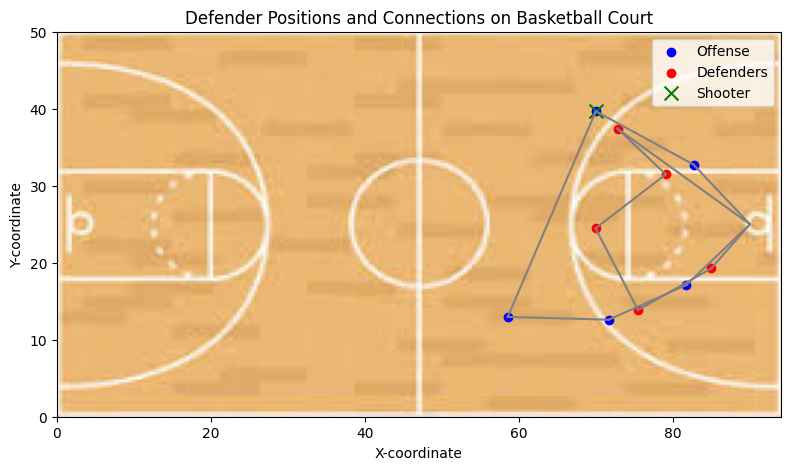

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# sample data
df = pd.DataFrame(def_training_data[def_training_data.id == '2-2'])

# load the images
court_image = Image.open('images/court_dims.png')

# plot the basketball court
plt.figure(figsize=(10, 5))
plt.imshow(court_image, extent=[0, 94, 0, 50])  # Extent based on court dimensions

# plotting the defender coordinates
plt.scatter(df['off_x'], df['off_y'], color='blue', label='Offense')
plt.scatter(df['def_x'], df['def_y'], color='red', label='Defenders')

coords = [(df['off_x'].iloc[i], df['off_y'].iloc[i]) for i in range(5)]
def_coords = [(df['def_x'].iloc[i], df['def_y'].iloc[i]) for i in range(5)]

# centroid is the hoop position
centroid = (df['hoop_x'].iloc[0], df['hoop_y'].iloc[0])

# sort coordinates clockwise around the hoop (centroid)
coords = sort_clockwise(coords, centroid)
def_coords = sort_clockwise(def_coords, centroid)

# centroid is the hoop position
centroid = (df['hoop_x'].iloc[0], df['hoop_y'].iloc[0])

coords.append(centroid)

def_coords.append(centroid)

df_off = pd.DataFrame(coords, columns=['x', 'y'])
df_def = pd.DataFrame(def_coords, columns=['x', 'y'])

# connect defenders with lines
# since we want to connect the defenders in a loop (5th to 1st), 
# we create an extended list where the first defender is also at the end
offense_xs = df_off['x'].tolist() + [df_off['x'].iloc[0]]
offense_ys = df_off['y'].tolist() + [df_off['y'].iloc[0]]
defender_xs = df_def['x'].tolist() + [df_def['x'].iloc[0]]
defender_ys = df_def['y'].tolist() + [df_def['y'].iloc[0]]

for i in range(len(df_off)):
    plt.plot([defender_xs[i], defender_xs[i+1]], [defender_ys[i], defender_ys[i+1]], color='gray')
for i in range(len(df_def)):
    plt.plot([offense_xs[i], offense_xs[i+1]], [offense_ys[i], offense_ys[i+1]], color='gray')

shooter_row = df[df['annotation_code_off'] == 's'].iloc[0]
plt.scatter(shooter_row['off_x'], shooter_row['off_y'], color='green', marker='x', s=100, label='Shooter')

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Defender Positions and Connections on Basketball Court')
plt.legend()
plt.show()

#### Spacing Calculation Logic
- Each player for a team is sorted by their angle to the baseline.
- Once sorted clockwise, the hoop connects to the first player, the first player connects to the second player, etc., etc. until a hexagon is formed.
- The area of this hexagon is calculated to provide an estimate of the spacing on the court.
- When the defense is spaced out, there are more lanes for offensive rebounders to attack.

## **Pivoting the DataFrame for Player Insights**

When analyzing basketball plays, understanding the spatial distribution of players on the court can provide significant insights. The position of each player, especially during key moments like a shot or potential rebound, can have an impact on the outcome of that play. Here, we're looking to pivot our dataframe to better capture and analyze the dynamics of each play.

#### Player-Specific Features
- *Individual Player Features:* We want to capture each player's metrics independently. By sorting our data by the 'boxout_position', we ensure that, for each play, the most crucial offensive player (based on their boxout position) is consistently placed in the same column. This consistency is pivotal in reducing data noise and ensuring the features of the most pivotal player always align across plays. The most important player serces as an anchor to uphold permutation invariant sorting (Mehrasa). https://www.cs.sfu.ca/~mori/research/papers/mehrasa-sloan18.pdf
  
  We will achieve this individual representation by:
  - Sorting the data by `boxout_position` for each play (identified by `id`). 
  - Assigning an order for each player pairing on the court for every play. This provides a consistent ordering mechanism.

#### Aggregated Features for Court Positioning
To get a comprehensive view of the players' positioning, we're looking to generate aggregated features. These features will allow us to understand the overall dynamics of player positioning for each play, giving us metrics that are holistic rather than player-specific. For instance:
- *Mean:* Averages could tell us the typical distance between players or from the hoop, providing insights into defensive or offensive strategies.
- *Max/Min:* These could highlight outlier player positions which might be key strategic placements.
- *Standard Deviation (std):* This can show us how spread out players are. A high standard deviation might indicate a more scattered formation, while a low one could suggest a tighter, possibly defensive cluster.
- *Sum:* This can be particularly useful when looking at metrics like total players within 10 feet.

By analyzing these aggregated features in conjunction with individual player metrics, we can gain a deeper understanding of team strategies, player importance, and play dynamics, allowing for more informed game analysis and decision-making.


In [80]:
def pivot_plays(data, agg_dict):
    # first, sort the data by 'boxout_position' for each play (id)
    # this will help reduce noise in the dataset, the most important offensive player will always be in the same column and correspond to other features
    data = data.sort_values(by=['id', 'boxout_position']).reset_index(drop=True)
    
    # create a new column for pairing number (1,2,3,...) for each play
    data['pairing_order'] = data.groupby('id').cumcount() + 1
    
    # extract all the feature columns
    feature_cols = [
        'betweenness_centrality', 'def_distance_to_hoop', 'boxout_angle', 'dist_interaction', 'distance_def_off', 'distance_def_shooter', 'off_distance_to_hoop',
        'rebound_angle_defense', 'rebound_angle_offense', 'triangle_area', 'boxout_position', 'log_boxout_angle', 'contextual_boxout_position', 'degrees_from_optimal_angle_offense',
        'degrees_from_optimal_angle_defense'
    ]
    
    # pivot the dataframe based on the feature columns
    pivoted_data = data.pivot_table(index='id', columns='pairing_order', values=feature_cols, aggfunc='first')

    # flatten the multi-level column index
    pivoted_data.columns = ['_'.join(map(str, col)).strip() for col in pivoted_data.columns.values]


    agg_cols = []
    for col, funcs in agg_dict.items():
        for func in funcs:
            agg_cols.append(f"{col}_{func}")
    # extract the aggregate columns
    aggregates = data.drop_duplicates(subset='id')[['id'] + agg_cols]

    # merge the aggregate columns with the pivoted data
    result = pivoted_data.reset_index().merge(aggregates, on='id', how='left')
    
    return result

In [81]:
# pivoting the data, so there is one record per play
def_pivoted = pivot_plays(def_training_data_with_feats, agg_dict_)
def_pivoted_test = pivot_plays(def_testing_data_with_feats, agg_dict_test)

In [82]:
# merging spacing data
def_pivoted = def_pivoted.merge(off_spacing, on='id')
def_pivoted = def_pivoted.merge(def_spacing, on='id')
def_pivoted_test = def_pivoted_test.merge(off_spacing_test, on='id')
def_pivoted_test = def_pivoted_test.merge(def_spacing_test, on='id')

In [83]:
# merging info about how many players are in advantageous regions for the given shot
def_pivoted = def_pivoted.merge(players_in_relevant_areas, on='id')
def_pivoted_test = def_pivoted_test.merge(players_in_relevant_areas_test, on='id')

## **Refining the Features**

#### Frequency Distributions for Features

In [84]:
def_pivoted_copy = def_pivoted.merge(train_pbp[['id', 'is_oreb']], on='id')

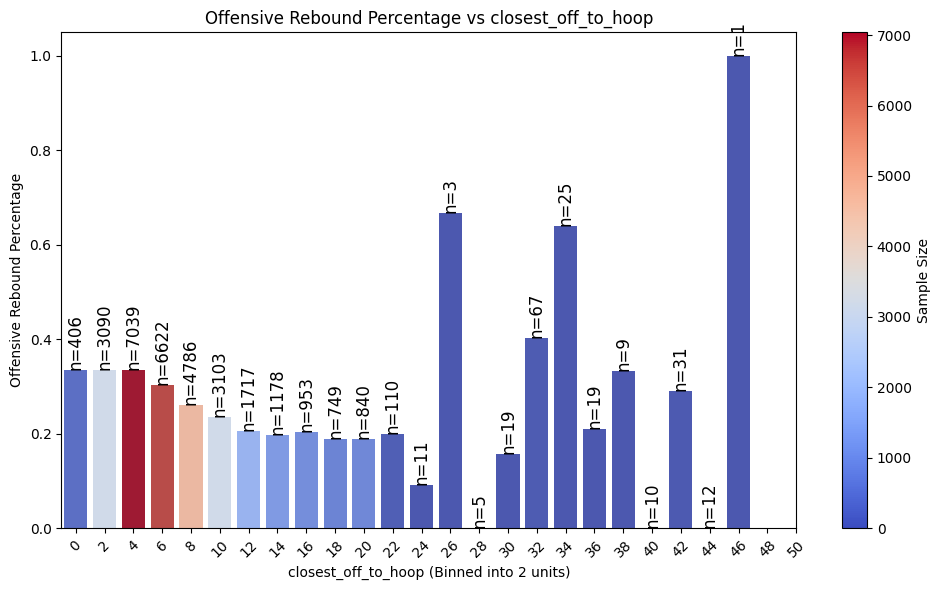

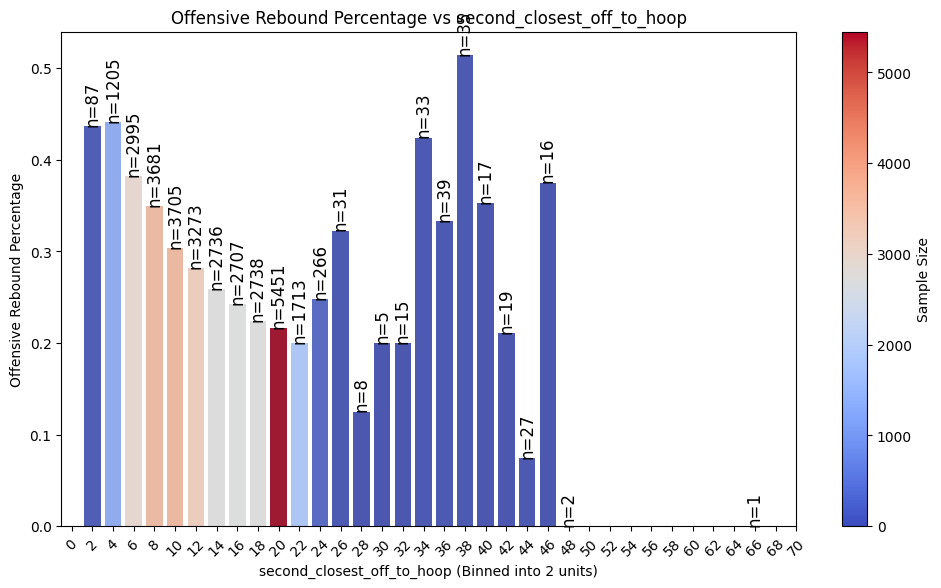

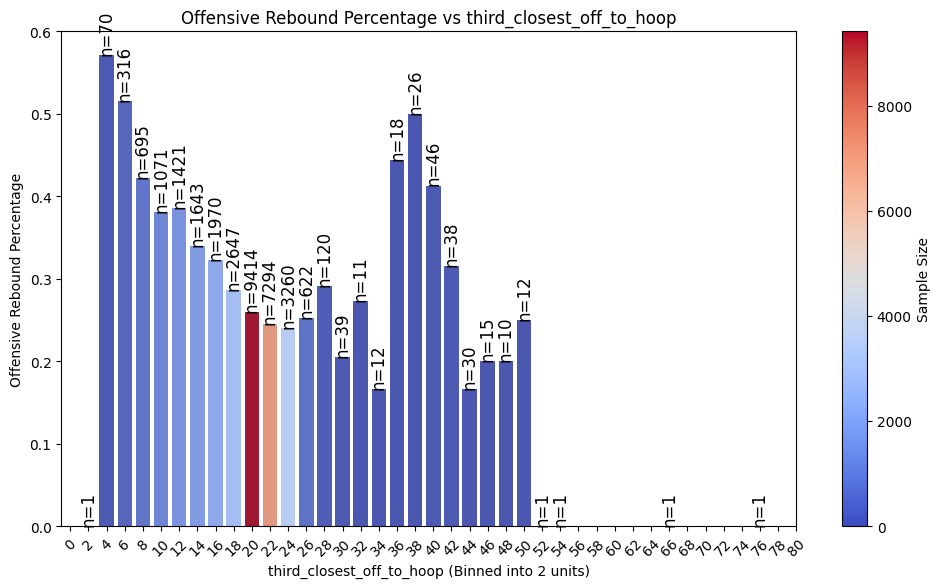

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

def plot_frequency_distributions(df, columns_to_plot, bin_size=None, text_rotation=90):
    for column in columns_to_plot:
        plt.figure(figsize=(10, 6))

        if bin_size:
            binned_column = pd.cut(df[column], bins=np.arange(0, max(df[column]) + 2 * bin_size, bin_size), right=False)
            counts = df.groupby(binned_column).size()
            max_count = counts.max()
            palette = {bin: mcolors.to_hex(plt.get_cmap('coolwarm')(count / max_count)) for bin, count in counts.items()}

            ax = sns.barplot(x=binned_column, y=df['is_oreb'], ci=None, palette=palette)
            
            # add legend for color-to-sample-size mapping
            norm = plt.Normalize(counts.min(), counts.max())
            sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
            sm.set_array([])
            plt.colorbar(sm, orientation='vertical', label='Sample Size')
            
            # add sample size text annotation
            for idx, p in enumerate(ax.patches):
                height = p.get_height()
                if pd.notnull(height):  # check for NaN
                    ax.text(p.get_x() + p.get_width()/2., height, f'n={counts.iloc[idx]}', fontsize=12, ha='center', va='bottom', rotation=text_rotation)
            
            # customize x-axis ticks
            bin_starts = [int(interval.left) for interval in counts.index.categories]
            bin_ends = [int(interval.right) for interval in counts.index.categories]
            all_ticks = bin_starts + [bin_ends[-1]]
            plt.xticks(np.arange(len(all_ticks)), all_ticks, rotation=45)
            
        else:
            ax = sns.barplot(x=column, y='is_oreb', data=df, ci=None)
        
        plt.title(f'Offensive Rebound Percentage vs {column}')
        plt.xlabel(f'{column} (Binned into {bin_size} units)' if bin_size else column)
        plt.ylabel('Offensive Rebound Percentage')
        plt.tight_layout()
        plt.show()


# list of columns to plot
columns_to_plot = ['closest_off_to_hoop', 'second_closest_off_to_hoop', 'third_closest_off_to_hoop']

# call the function with a bin size of 2
plot_frequency_distributions(df_encoded_train_3bins, columns_to_plot, bin_size=2)

#### Offensive Rebound % vs Distance to Hoop Analysis
- When the second and third closest offensive players are within 8 feet, there is a significantly better chance of an offensive rebound (`39.28%`, `52.43%` respectively).
- The third closest player being less than 8 feet from the hoop obviously implies there are three offensive players within 8 feet which indicates a positional advantage.
- When the third closest player is within 8 feet, the offense actually has the advantage in retreiving the rebound in a 386 play sample.
- In looking at the entirety of the training data, there does not appear to be a disadvantage to being too close to the hoop; let's plot frequency distributions using only long range shots.

#### Long Range Shot Distance to Hoop Frequency Distribution

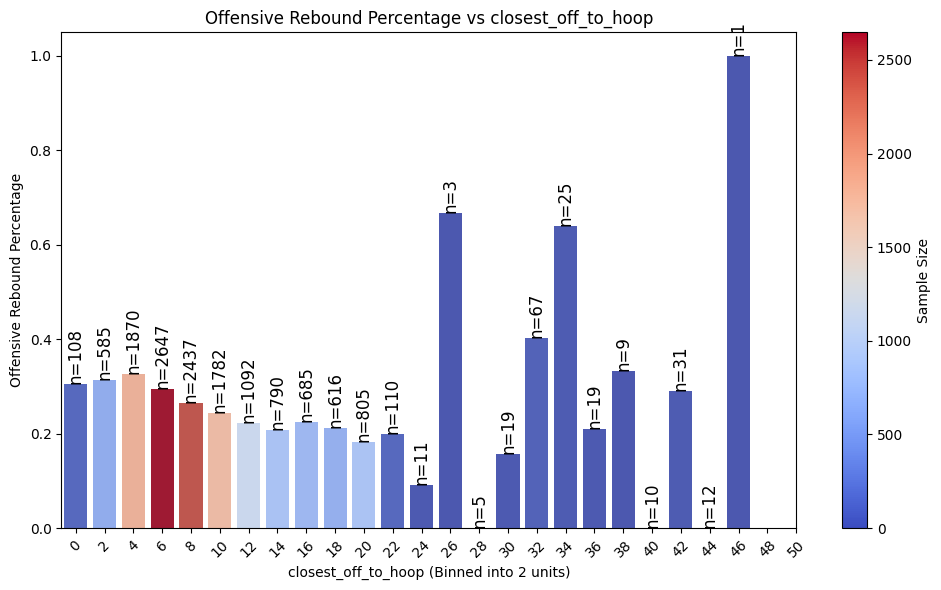

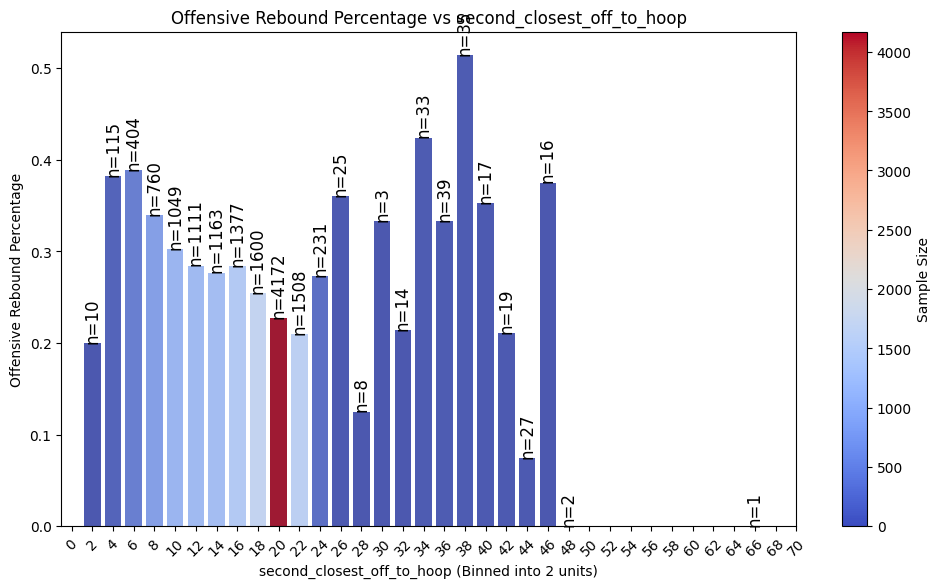

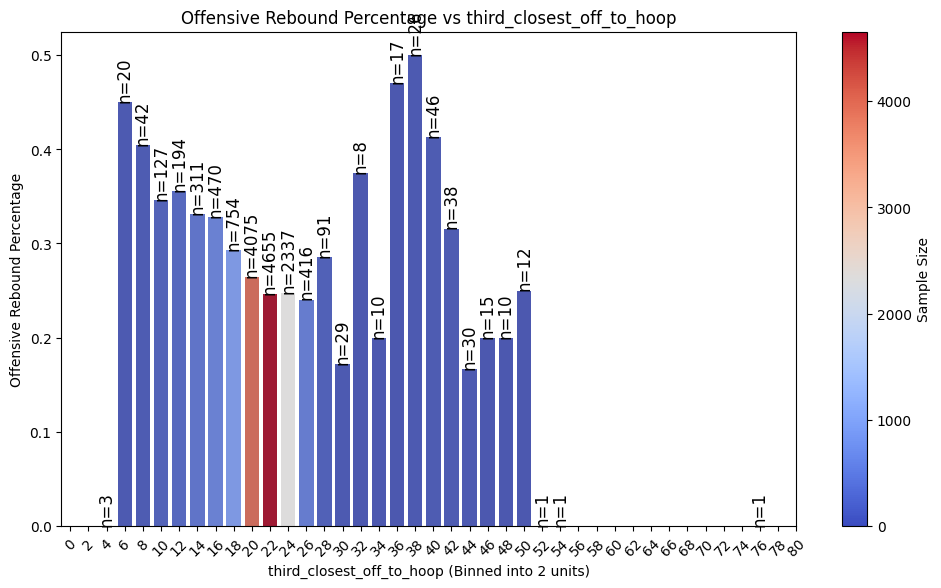

In [86]:
plot_frequency_distributions(df_encoded_train_3bins.loc[df_encoded_train_5bins['shot_distance_zone_21+'] == 1], columns_to_plot, bin_size=2)

#### Long Range Shot Frequency Distribution Analysis
- Evident in the closest player visual, it does appear that a player can be too close to the rim.
- There is a greater offensive rebounding percentage when the nearest offensive player to the hoop is 4-6 feet from the hoop (n=1970) than when they are less than 4 feet from the hoop (n=693).

#### Number of Defenders Closer than X Closest Offensive Player

In [87]:
player_dists = df_encoded_train_3bins.copy()
player_dists_test = df_encoded_test_3bins.copy()

In [88]:
def count_closer_def_players(row, off_col):
    def_cols = ['closest_def_to_hoop', 'second_closest_def_to_hoop', 'third_closest_def_to_hoop', 'fourth_closest_def_to_hoop', 'fifth_closest_def_to_hoop']
    return sum(row[def_col] < row[off_col] for def_col in def_cols)

player_dists['num_def_closer_than_closest_off'] = player_dists.apply(lambda row: count_closer_def_players(row, 'closest_off_to_hoop'), axis=1)
player_dists['num_def_closer_than_second_closest_off'] = player_dists.apply(lambda row: count_closer_def_players(row, 'second_closest_off_to_hoop'), axis=1)
player_dists['num_def_closer_than_third_closest_off'] = player_dists.apply(lambda row: count_closer_def_players(row, 'third_closest_off_to_hoop'), axis=1)
player_dists_test['num_def_closer_than_closest_off'] = player_dists_test.apply(lambda row: count_closer_def_players(row, 'closest_off_to_hoop'), axis=1)
player_dists_test['num_def_closer_than_second_closest_off'] = player_dists_test.apply(lambda row: count_closer_def_players(row, 'second_closest_off_to_hoop'), axis=1)
player_dists_test['num_def_closer_than_third_closest_off'] = player_dists_test.apply(lambda row: count_closer_def_players(row, 'third_closest_off_to_hoop'), axis=1)

#### Visualizing Frequency Distribution of Number of Defenders Closer than the Nearest Offensive Player to the Hoop

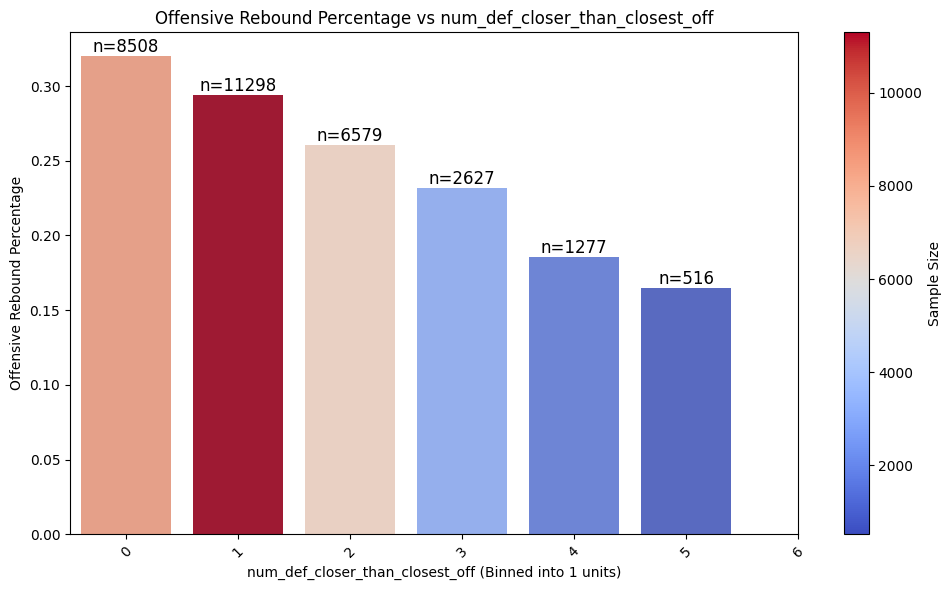

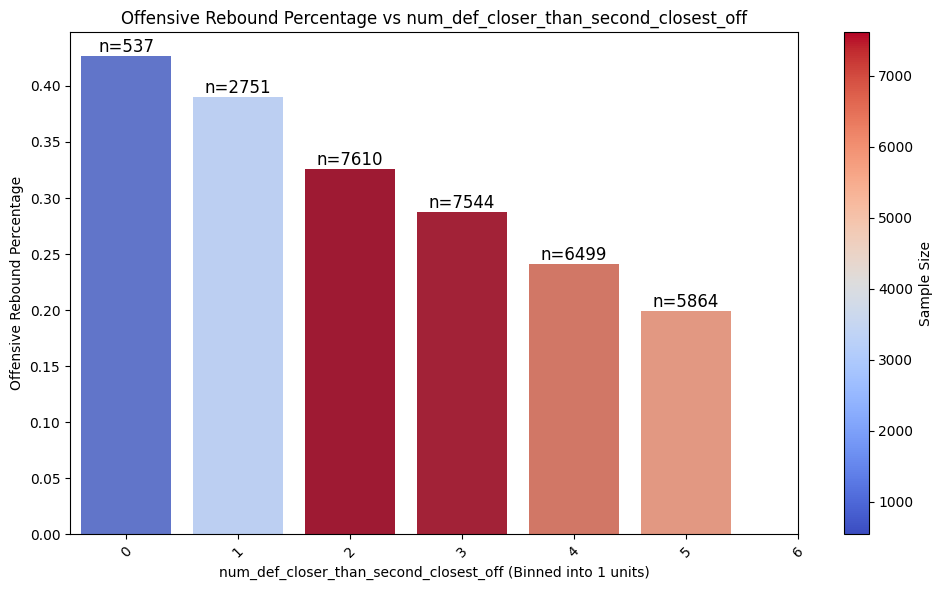

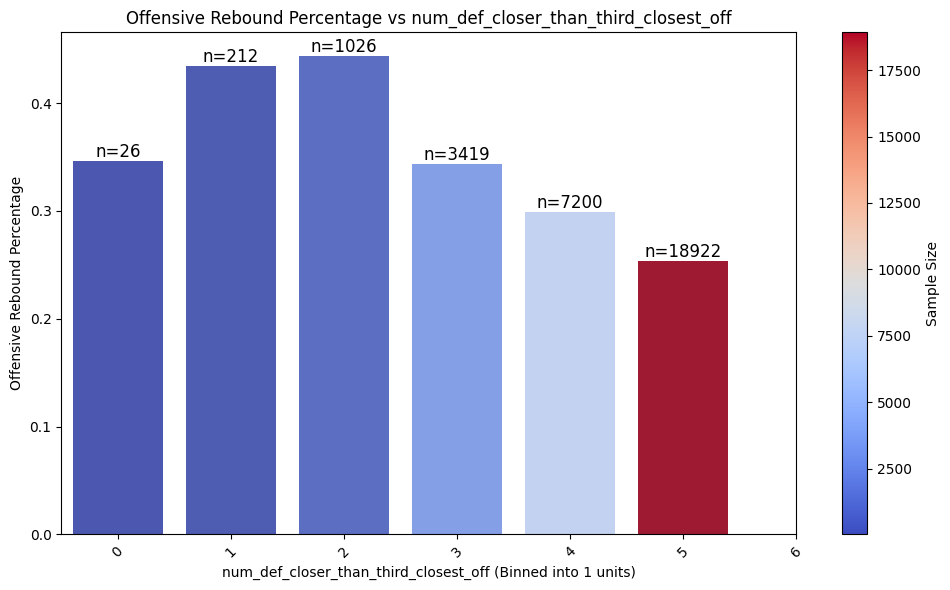

In [89]:
plot_frequency_distributions(player_dists, ['num_def_closer_than_closest_off', 'num_def_closer_than_second_closest_off', 'num_def_closer_than_third_closest_off'], bin_size=1, text_rotation=0)


#### Number of Defenders Closer Frequency Distribution Analysis
- The charts make it clear that this is a good feature to keep. Basically, if there are fewer defensive players near the hoop compared to offensive players, the chances for an offensive rebound go up.
- In a small set of data (n=26), there's a `34%` chance of an offensive rebound when no defenders are closer to the hoop than the nearest offensive player. This is actually lower than when defenders are closer to the hoop than the third closest offensive player.
- This tells us we need to look more closely at these plays. We want to make sure our assumption that the shooter is shooting at the basket they are closest to holds true.

In [90]:
outlier_non_offensive_rebounds = player_dists[(player_dists['num_def_closer_than_third_closest_off'] == 0) & (player_dists['is_oreb'] == 0)].id

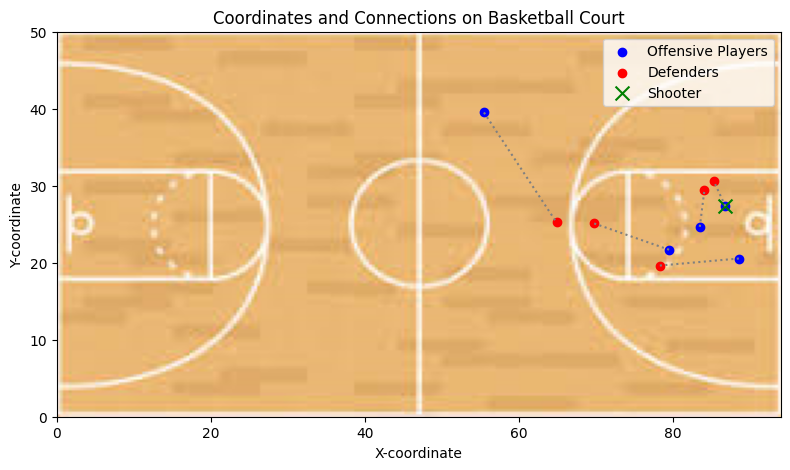

In [91]:
# Sample data
df = def_training_data[def_training_data.id == '1419-4']

# Load the images
court_image = Image.open('images/court_dims.png')

# Plot the basketball court
plt.figure(figsize=(10, 5))
plt.imshow(court_image, extent=[0, 94, 0, 50])  # Extent based on court dimensions


# Plotting the coordinates and connecting the pairs of players with lines
plt.scatter(df['off_x'], df['off_y'], color='blue', label='Offensive Players')
plt.scatter(df['def_x'], df['def_y'], color='red', label='Defenders')

# Connect the pairs of players with lines
for i, row in df.iterrows():
    plt.plot([row['off_x'], row['def_x']], [row['off_y'], row['def_y']], color='gray', linestyle='dotted')

shooter_row = df[df['annotation_code_off'] == 's'].iloc[0]
plt.scatter(shooter_row['off_x'], shooter_row['off_y'], color='green', marker='x', s=100, label='Shooter')

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Coordinates and Connections on Basketball Court')
plt.legend()
plt.show()

#### Assessing the Potential Outlier
- Play `1419-4` appears to be a standard play where the player is shooting at the hoop nearest them.
- Though the offense is seemingly in great position for a rebound, the defenders' momentum may tell a different story.
- It is possible that the player behind the shooter blocks the shot, or the ball could have simply taken a funny bounce.
- Upon visualizing a few other such plays, they seem to be plausible court circumstances for defensive rebounds. The small sample does not represent the expected behavior.
- Gotta make wide open layups - maybe they were celebrating too early? https://www.youtube.com/watch?v=Zmz0qQp4OmI

#### Distinguishing Fast Breaks

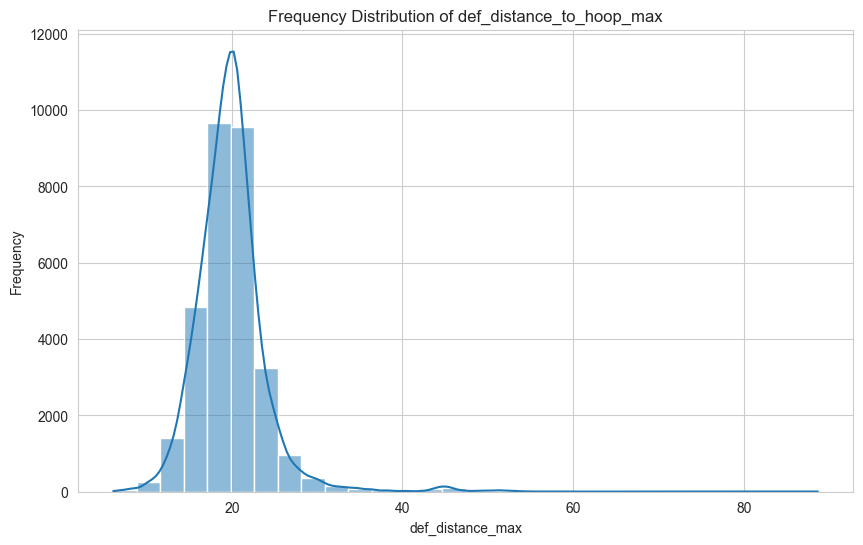

In [92]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# histogram for the 'def_distance_mean' column
sns.histplot(def_pivoted['def_distance_to_hoop_max'], bins=30, kde=True)

plt.title('Frequency Distribution of def_distance_to_hoop_max')
plt.xlabel('def_distance_max')
plt.ylabel('Frequency')
plt.show()

#### Criteria for Identifying Fast Breaks
- On a standard half court position with a set defense, the maximum defender distance from the basket likely not exceed 25 feet.
- `2066` out of the `30805` training examples have a defensive player greater than 25 feet from the basket.
- We deduce that these scenarios likely represent fast breaks. Thus, we'll use the 25-foot criteria from the basket as our benchmark to classify plays as fast breaks.

#### Distinguishing Irregular Shots

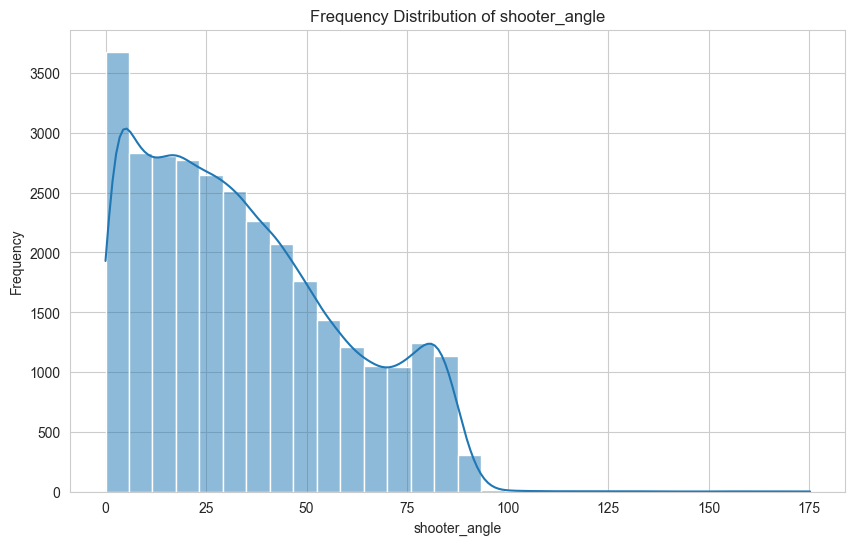

In [93]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# histogram for the 'def_distance_mean' column
sns.histplot(def_pivoted['shooter_angle_max'], bins=30, kde=True)

plt.title('Frequency Distribution of shooter_angle')
plt.xlabel('shooter_angle')
plt.ylabel('Frequency')
plt.show()

In [94]:
len(def_pivoted[def_pivoted.shooter_angle_max > 92.5])

58

#### Criteria for Irregular Shots

- *Behind the Basket*: Shots where the shooter angles exceed 90 degrees are considered to be taken from behind the basket.
- *Characteristics*: While these shots up to a certain point may resemble standard shots in terms of possibly hitting the rim or even scoring, they are inherently more challenging and atypical.
- *Data Insight*: Out of the training dataset, there are 58 instances where the shooter angle is greater than 92.5 degrees.
- *Feature Engineering*: Introducing a binary feature named `irregular_shot` could assist models in better handling these outliers.


#### Distinguishing Corner Shots
- In this visualization, we will compare the offensive rebounding percentage for different shooting angles with and without weakside offensive rebounders.
    - The 'difference' in the chart is referring to:
        - OREB% with 1+ offensive player within 10 ft of the basket on the weakside minus OREB% with 0 offensive player within 10 ft of the basket on the weakside.

    
- This will help us understand how weakside rebounder presence contributes to offensive rebounding success for shots from different areas of the court.

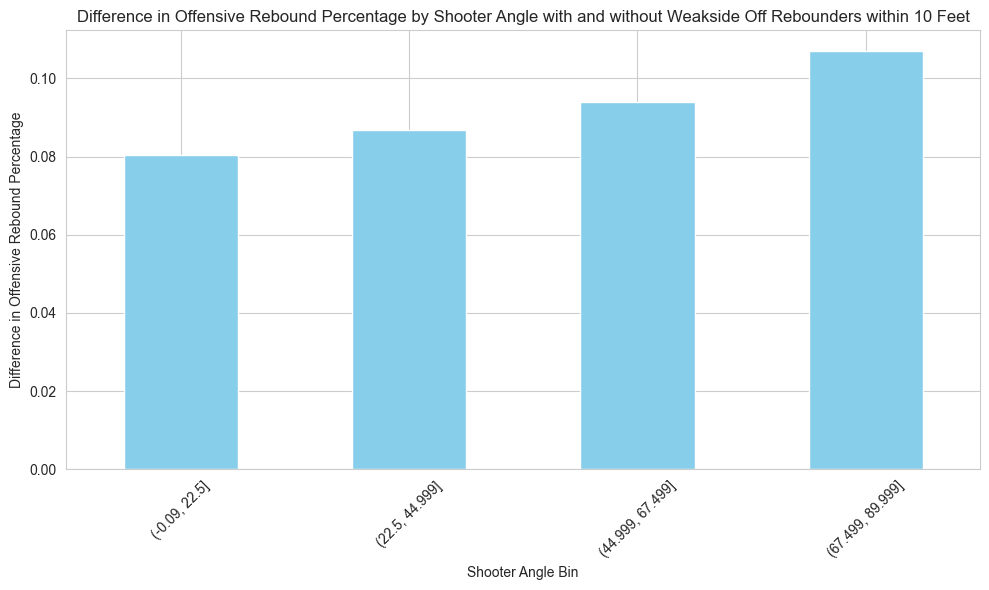

In [95]:
def_pivoted_copy = def_pivoted[def_pivoted.shooter_angle_max < 90].merge(train_pbp[['id', 'is_oreb']], on='id')

# bin the shooter angle
def_pivoted_copy['shooter_angle_bin'] = pd.cut(def_pivoted_copy['shooter_angle_max'], bins=4)  # 9 bins

# calculate median for weakside rebounders
median_weakside = def_pivoted_copy['off_within_10ft_weakside_sum'].median()

# assign 'high' or 'low' based on the median
def_pivoted_copy['weakside_label'] = def_pivoted_copy['off_within_10ft_weakside_sum'].apply(lambda x: 'high' if x > median_weakside else 'low')

# calculate offensive rebound percentage for each combination
grouped = def_pivoted_copy.groupby(['shooter_angle_bin', 'weakside_label'])
rebound_pct = grouped['is_oreb'].mean()

# calculate the difference between 'high' and 'low' for each bin
rebound_diff = rebound_pct.unstack().apply(lambda x: x['high'] - x['low'], axis=1)

# plot
fig, ax = plt.subplots(figsize=(10,6))
rebound_diff.plot(kind='bar', ax=ax, color='skyblue')
ax.set_title("Difference in Offensive Rebound Percentage by Shooter Angle with and without Weakside Off Rebounders within 10 Feet")
ax.set_xlabel("Shooter Angle Bin")
ax.set_ylabel("Difference in Offensive Rebound Percentage")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [96]:
# median of 0
median_weakside

0.0

In [97]:
# more instances without an offensive player on the weakside within 10 feet than with
def_pivoted_copy['off_within_10ft_weakside_sum'].value_counts()

0    18232
1    11613
2      805
3       15
4        1
Name: off_within_10ft_weakside_sum, dtype: int64

#### Key Takeaways from Shooter Angle Frequency Distribution
- Having weakside defensive rebounders for shots with greater shooting angles appears to improve the chances of an offensive rebound.
- This validates the assumption about the ball's path being most likely to continue at an equal opposite angle from its release.

### Adding Features

In [98]:
# creating behind_basket Column
def_pivoted['behind_basket'] = def_pivoted.apply(lambda x: 1 if x.shooter_angle_max > 92.5 else 0, axis=1)
def_pivoted_test['behind_basket'] = def_pivoted_test.apply(lambda x: 1 if x.shooter_angle_max > 92.5 else 0, axis=1)
# creating Fastbreak Probable Column
def_pivoted['Fastbreak Probable'] = def_pivoted.apply(lambda x: 1 if x.def_distance_to_hoop_max > 25 else 0, axis=1)
def_pivoted_test['Fastbreak Probable'] = def_pivoted_test.apply(lambda x: 1 if x.def_distance_to_hoop_mean > 25 else 0, axis=1)
def_pivoted = def_pivoted.merge(player_dists[['id', 'num_def_closer_than_closest_off', 'num_def_closer_than_second_closest_off', 'num_def_closer_than_third_closest_off']], on='id')
def_pivoted_test = def_pivoted_test.merge(player_dists_test[['id', 'num_def_closer_than_closest_off', 'num_def_closer_than_second_closest_off', 'num_def_closer_than_third_closest_off']], on='id')

#### Assessing the Impact of Weakside Rebounders
When analyzing the role of weakside rebounders, two key insights emerge:

- Dependency on Shooter's Angle: As the angle of the shot increases, the influence of weakside rebounders appears to escalate.

- Corner vs. Wing Shots: The data indicates that shots taken from the corner are more prone to bounce towards the weak side when compared to shots from the wing. It emphasizes the strategic importance of weakside positioning, especially during corner shots.

#### Checking Correlations between Features and Offensive Rebounding

In [99]:
def_pivoted_copy.corr()['is_oreb'].sort_values(ascending=False)

is_oreb                     1.000000
off_within_10ft_sum         0.137574
boxout_angle_std            0.107385
betweenness_centrality_5    0.100981
boxout_position_std         0.100243
                              ...   
log_boxout_angle_mean      -0.124016
off_spacing                -0.127895
boxout_position_2          -0.134952
boxout_angle_mean          -0.135200
boxout_position_mean       -0.139718
Name: is_oreb, Length: 133, dtype: float64

#### Insights on Correlation to Offensive Rebounding

*Positive Correlations:*

1. `off_within_10ft_sum` (0.138):
This feature has the strongest positive correlation with offensive rebounding. It suggests that the higher the number of offensive players within 10 feet of the basket, the more likely an offensive rebound will occur.

2. `boxout_angle_std` (0.107):
The standard deviation of boxout angles has a positive correlation with offensive rebounds. A higher standard deviation might indicate variability in openings for the offense to get in rebounding position, possibly making it easier for the offense to grab rebounds.

3. `betweenness_centrality_5` (0.101):
This is often 0 and defensive rebounds are more common. Let's eliminate betweenness_centrality_4-5 before modeling.

4. `boxout_position_std` (0.100):
Similar to the `boxout_angle_std`, the variability in boxout positioning is positively correlated with offensive rebounds. Greater variability might indicate disorganization in the defense, benefiting the offense.

*Negative Correlations:*

1. `boxout_position_mean` (-0.140):
The average boxout position has the strongest negative correlation. This is a sign that boxout_position may be a strong predictor of offensive rebounding.

2. `boxout_angle_mean` (-0.135):
The average boxout angle being negatively correlated suggests that certain angles are less effective for defensive players when trying to prevent offensive rebounds.

3. `boxout_position_2` (-0.135):
The second player's boxout location seems to play a pivotal role in offensive rebounding.

4. `log_boxout_angle_mean` (-0.124):
The logarithm of the average boxout angle also shows a negative correlation.


*General Insights:*

- The presence of offensive players close to the basket (`off_within_10ft_sum`) is a crucial factor in offensive rebounding. It emphasizes the importance of positioning near the hoop during shots.
  
- Defensive positioning is vital in preventing offensive rebounds. Variabilities in boxout angles and positions might indicate a disorganized defense, which seems to favor the offense in terms of rebounding.

In [100]:
# dropping these columns because they are commonly 0 and may correlate with offensive rebounding
def_pivoted.drop(columns=['betweenness_centrality_4', 'betweenness_centrality_5'], inplace=True)
def_pivoted_test.drop(columns=['betweenness_centrality_4', 'betweenness_centrality_5'], inplace=True)

In [101]:
def_pivoted['diff_spacing'] = def_pivoted['off_spacing'] - def_pivoted['def_spacing']
def_pivoted_test['diff_spacing'] = def_pivoted_test['off_spacing'] - def_pivoted_test['def_spacing']

In [102]:
def_pivoted['diff_distance'] = def_pivoted['off_distance_to_hoop_mean'] - def_pivoted['def_distance_to_hoop_mean']
def_pivoted_test['diff_distance'] = def_pivoted_test['off_distance_to_hoop_mean'] - def_pivoted_test['def_distance_to_hoop_mean']

In [103]:
def_pivoted.head()

,id,betweenness_centrality_1,betweenness_centrality_2,betweenness_centrality_3,boxout_angle_1,boxout_angle_2,boxout_angle_3,boxout_angle_4,boxout_angle_5,boxout_position_1,boxout_position_2,boxout_position_3,boxout_position_4,boxout_position_5,contextual_boxout_position_1,contextual_boxout_position_2,contextual_boxout_position_3,contextual_boxout_position_4,contextual_boxout_position_5,def_distance_to_hoop_1,def_distance_to_hoop_2,def_distance_to_hoop_3,def_distance_to_hoop_4,def_distance_to_hoop_5,degrees_from_optimal_angle_defense_1,degrees_from_optimal_angle_defense_2,degrees_from_optimal_angle_defense_3,degrees_from_optimal_angle_defense_4,degrees_from_optimal_angle_defense_5,degrees_from_optimal_angle_offense_1,degrees_from_optimal_angle_offense_2,degrees_from_optimal_angle_offense_3,degrees_from_optimal_angle_offense_4,degrees_from_optimal_angle_offense_5,dist_interaction_1,dist_interaction_2,dist_interaction_3,dist_interaction_4,dist_interaction_5,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_def_shooter_1,distance_def_shooter_2,distance_def_shooter_3,distance_def_shooter_4,distance_def_shooter_5,log_boxout_angle_1,log_boxout_angle_2,log_boxout_angle_3,log_boxout_angle_4,log_boxout_angle_5,off_distance_to_hoop_1,off_distance_to_hoop_2,off_distance_to_hoop_3,off_distance_to_hoop_4,off_distance_to_hoop_5,rebound_angle_defense_1,rebound_angle_defense_2,rebound_angle_defense_3,rebound_angle_defense_4,rebound_angle_defense_5,rebound_angle_offense_1,rebound_angle_offense_2,rebound_angle_offense_3,rebound_angle_offense_4,rebound_angle_offense_5,triangle_area_1,triangle_area_2,triangle_area_3,triangle_area_4,triangle_area_5,def_distance_to_hoop_mean,def_distance_to_hoop_min,def_distance_to_hoop_max,def_distance_to_hoop_std,distance_def_off_mean,distance_def_off_min,distance_def_off_max,distance_def_off_std,off_distance_to_hoop_mean,off_distance_to_hoop_min,off_distance_to_hoop_max,off_distance_to_hoop_std,distance_def_shooter_mean,distance_def_shooter_min,distance_def_shooter_max,distance_def_shooter_std,betweenness_centrality_mean,betweenness_centrality_max,betweenness_centrality_std,def_within_10ft_sum,off_within_10ft_sum,def_within_10ft_weakside_sum,off_within_10ft_weakside_sum,shooter_angle_max,corner_max,boxout_angle_mean,boxout_angle_min,boxout_angle_max,boxout_angle_std,boxout_position_mean,boxout_position_min,boxout_position_max,boxout_position_std,weakside_diff_sum,log_boxout_angle_mean,log_boxout_angle_min,log_boxout_angle_max,log_boxout_angle_std,contextual_boxout_position_mean,contextual_boxout_position_min,contextual_boxout_position_max,contextual_boxout_position_std,degrees_from_optimal_angle_offense_mean,degrees_from_optimal_angle_offense_min,degrees_from_optimal_angle_offense_max,degrees_from_optimal_angle_offense_std,degrees_from_optimal_angle_defense_mean,degrees_from_optimal_angle_defense_min,degrees_from_optimal_angle_defense_max,degrees_from_optimal_angle_defense_std,shot_distance_mean,off_spacing,def_spacing,def_front_rim_10ft_count,off_front_rim_10ft_count,def_opposite_10ft_count,off_opposite_10ft_count,behind_basket,Fastbreak Probable,num_def_closer_than_closest_off,num_def_closer_than_second_closest_off,num_def_closer_than_third_closest_off,diff_spacing,diff_distance
0,10-10,0.0,0.0,0.0,116.216691,153.204400,141.310412,164.076702,177.070985,2.144891,2.283453,2.341907,2.390649,2.392153,6.502827,8.517072,5.536672,9.478539,7.909619,9.272356,12.992872,16.175073,10.056615,14.782542,9.600642,36.789584,24.779873,41.855696,27.350085,19.734010,40.675311,9.635235,51.711781,26.289042,18.781379,29.387453,171.110754,163.789759,124.140302,2.025524,2.261813,10.578670,16.286768,8.397764,23.130147,13.956005,13.789984,16.286768,27.449730,4.764024,5.038279,4.958011,5.106410,5.182182,10.328278,15.046402,25.311266,26.103727,23.173309,61.312423,14.922197,26.931908,9.856085,79.061866,71.445791,11.036470,42.076546,0.000000,78.000823,13.205777,0.550145,72.279981,0.000000

In [104]:
def_pivoted['shooter_is_closest'] = (def_pivoted['shot_distance_mean'] == def_pivoted['off_distance_to_hoop_min']).astype(int)
def_pivoted_test['shooter_is_closest'] = (def_pivoted_test['shot_distance_mean'] == def_pivoted_test['off_distance_to_hoop_min']).astype(int)

---

# **Model Experimentation**

#### **Scaling the Data**
- Once again, we fit the scaler on the training set and use the same scaler on the test set

In [105]:
# create a StandardScaler object
scaler = StandardScaler()

# extract the continuous features from the DataFrame
ids_train = def_pivoted[['id', 'corner_max', 'Fastbreak Probable', 'behind_basket', 'shooter_is_closest']] # id and the one categorical feature
ids_test = def_pivoted_test[['id', 'corner_max', 'Fastbreak Probable', 'behind_basket', 'shooter_is_closest']]

continuous_features = def_pivoted.drop(columns=['id', 'corner_max', 'Fastbreak Probable', 'behind_basket', 'shooter_is_closest'])
continuous_features_test = def_pivoted_test.drop(columns=['id', 'corner_max', 'Fastbreak Probable', 'behind_basket', 'shooter_is_closest'])

# fit and transform the continuous features using the StandardScaler
scaled_continuous_features = scaler.fit_transform(continuous_features)
scaled_continuous_features_test = scaler.transform(continuous_features_test)

# convert the scaled_continuous_features back to a DataFrame with the original column names
scaled_continuous_df = pd.DataFrame(scaled_continuous_features, columns=continuous_features.columns)
scaled_continuous_df_test = pd.DataFrame(scaled_continuous_features_test, columns=continuous_features_test.columns)

# concatenate the scaled continuous features with the categorical features)
normalized_df = pd.concat([ids_train, scaled_continuous_df], axis=1)
normalized_df_test = pd.concat([ids_test, scaled_continuous_df_test], axis=1)

In [106]:
# dropping repeat columns
normalized_df.drop(columns=['def_distance_to_hoop_mean', 'off_distance_to_hoop_mean'], inplace=True)
normalized_df_test.drop(columns=['def_distance_to_hoop_mean', 'off_distance_to_hoop_mean'], inplace=True)

In [107]:
combined_datasets_3 = normalized_df.merge(X_dist_3bins, on='id', how='inner')
combined_datasets_test_3 = normalized_df_test.merge(X_test_dist_3bins, on='id', how='inner')
combined_datasets_5 = normalized_df.merge(X_dist_5bins, on='id', how='inner')
combined_datasets_test_5 = normalized_df_test.merge(X_test_dist_5bins, on='id', how='inner')

In [108]:
X_3 = combined_datasets_3.drop(columns=['id', 'is_oreb'])
X_5 = combined_datasets_5.drop(columns=['id', 'is_oreb'])
X_3_holdout = combined_datasets_test_3.drop(columns=['id'])
X_5_holdout = combined_datasets_test_5.drop(columns=['id'])
y = combined_datasets_3['is_oreb']
y_cnn = combined_datasets_3[['id', 'is_oreb']]
holdout_ids = combined_datasets_test_3['id']

#### Model Choices for the Project

For this project, our goal is to effectively predict offensive rebounding events, a task that requires careful consideration of numerous variables and their interactions. To ensure a comprehensive approach and increase the likelihood of accurate predictions, we've selected three diverse and robust models:

1. **XGBoost**: XGBoost, or Extreme Gradient Boosting, is a gradient boosting framework that builds on the principle of boosting weak learners. It's known for its efficiency and ability to handle a large set of features, especially when there are complex interactions between them. It also provides a regularized framework, which can help prevent overfitting.

2. **RandomForestClassifier**: This ensemble method uses a 'forest' of decision trees, each trained on random subsets of the data and features, ensuring diversity in its predictions. Its ability to capture non-linear relationships, as well as feature interactions, makes it especially valuable for our problem. Additionally, RandomForest offers the benefit of interpretability through feature importance rankings.

3. **Logistic Regression**: Though it might seem like a simple choice, Logistic Regression offers powerful benefits. It's a linear model that's particularly effective when relationships are somewhat linear or when we want to establish a baseline model. It's also very interpretable, as the coefficients can provide insights into the importance and directionality of each feature. 

By leveraging the diverse strengths of these models, we aim to capture the multifaceted nature of our prediction task. Whether it's the interpretability of Logistic Regression, the non-linear capturing capabilities of RandomForest, or the fine-tuned precision of XGBoost, each model brings unique value to our project.


In [109]:
def cross_val_model_score(model, X_, y_):
    #perform cross-validation
    cross_val_scores = cross_val_score(model, X_, y_, cv=5, scoring='neg_log_loss')

    # since cross_val_score returns negative log loss values, we take the negative to get the positive log loss
    log_loss_scores = -cross_val_scores
    return log_loss_scores.mean()

In [110]:
def evaluate_models(models_dict, X, y):
    """
    Evaluates a dictionary of models using cross-validation.

    Parameters:
    - models_dict: Dictionary with model name as key and model object as value
    - X: Feature matrix
    - y: Target variable

    Returns:
    - DataFrame with models as rows and their corresponding log loss scores
    """
    results = {}
    for name, model in models_dict.items():
        results[name] = cross_val_model_score(model, X, y)

    # convert dictionary to DataFrame
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Log Loss'])

    return results_df

In [111]:
# XGB model score 
# The hyperparameters have been tuned already; this cell is used for feature engineering experimentation
if RUN_CELL:
    cross_val_model_score(xgb.XGBClassifier(learning_rate=0.065, n_estimators=112, objective='binary:logistic', 
                              eval_metric='logloss', max_depth=3, min_child_weight=5), X_3, y)

In [112]:
if RUN_CELL:
    cross_val_model_score(LogisticRegression(penalty='l1', solver='saga', C=.05, max_iter=200), X_3, y)

In [113]:
if RUN_CELL:
    cross_val_model_score(RandomForestClassifier(max_depth=8, max_features='auto', min_samples_leaf= 6, min_samples_split=15, n_estimators=200), X_3, y)

In [114]:
models = {
    'XGBoost': xgb.XGBClassifier(learning_rate=0.065, n_estimators=112, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=5),
    'Random Forest': RandomForestClassifier(max_depth=8, max_features='auto', min_samples_leaf= 6, min_samples_split=15, n_estimators=200),
    'Logistic Regression': LogisticRegression(penalty='l1', solver='saga', C=.05, max_iter=200)
}
df_results = evaluate_models(models, X_3, y)
print(df_results)

                     Log Loss
XGBoost              0.578088
Random Forest        0.578625
Logistic Regression  0.579246


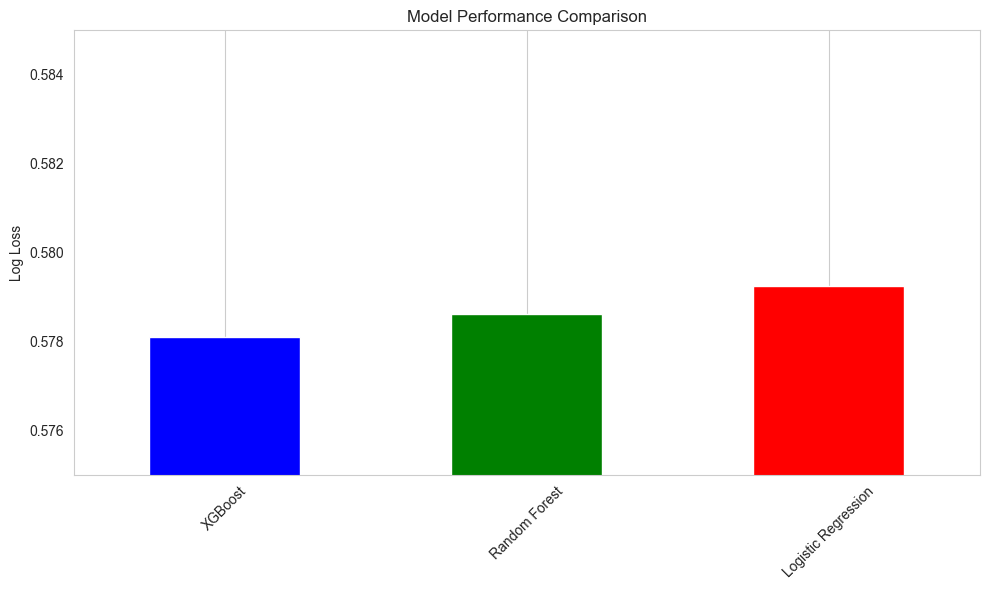

In [115]:
plt.figure(figsize=(10, 6))
df_results['Log Loss'].plot(kind='bar', color=['blue', 'green', 'red'])
plt.ylabel('Log Loss')
plt.ylim(bottom=.575, top=.585)
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Model Performance Comparison
- XGBoost has the best performance by log loss with a score of `.5781`
- This represents a significant improvement over the baseline model of `.0028`
- Given the capabilities of XGBoost, its top performance aligns with expectations.
- The next step will be to explore different hyperparameter combinations for XGB and RFC to improve the predictions

In [116]:
def create_submission(ids, preds, num_sub):
    submission = pd.DataFrame(ids)
    submission['pred'] = preds
    submission.to_csv(f'submission{num_sub}.csv', index=False)

---

## **Tuning Hyperparameters**

In [117]:
# original parama grid:
# param_grid = {
#     'max_depth': [2, 3, 4],
#     'min_child_weight': [3, 4, 5],
#     'n_estimators': [50, 75, 100],
#     'learning_rate': [.05, .07, .09]
# }
if RUN_CELL:
    # this parameter grid was constructed after an initial run with the original parameter grid
    param_grid = {
        'max_depth': [3],
        'min_child_weight': [4, 5],
        'n_estimators': [87, 100, 112],
        'learning_rate': [.045, .055, .06, .065]
    }

    # create an instance of the XGBClassifier with a fixed learning rate and number of boosting rounds
    model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

    # use GridSearchCV to search for the best combination of hyperparameters
    grid_search_xgb = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=5)
    grid_search_xgb.fit(X_3, y)

    # get the best hyperparameters from the grid search
    best_params = grid_search_xgb.best_params_


---

### Hyperparameter Optimization Results for XGBoost Classifier

After running GridSearch cross-validation, we found the best hyperparameters for our XGBoost model. These are:

- `max_depth`: 3
- `min_child_weight`: 5

This means our model works best with decision trees that go 3 levels deep and have a minimum 'child' weight of 5. Keeping it simple like this helps us prevent overfitting.

Here's a summary of our top 10 test scores:

| `learning_rate` | `max_depth` | `min_child_weight` | `n_estimators` | `mean_test_score` |
|-----------------|-------------|--------------------|----------------|-------------------|
| 0.055           | 3           | 5                  | 100            | -0.5783233        |
| 0.06            | 3           | 5                  | 87             | -0.5783167        |
| 0.055           | 3           | 5                  | 112            | -0.5782977        |
| 0.06            | 3           | 5                  | 112            | -0.5782864        |
| 0.065           | 3           | 5                  | 100            | -0.5782833        |
| 0.055           | 3           | 4                  | 100            | -0.5782600        |
| 0.065           | 3           | 5                  | 87             | -0.5782431        |
| 0.045           | 3           | 5                  | 112            | -0.5782262        |
| 0.055           | 3           | 4                  | 112            | -0.5782046        |
| 0.065           | 3           | 5                  | 112            | -0.5781886        |

Our selected hyperparameters closely match the settings that gave us the best test scores.

---


In [118]:
if RUN_CELL:
    # hyperparameters to tune
    param_grid = {
        'n_estimators': [50, 100],  # Number of trees in the forest
        'max_depth': [4, 6, 8],  # Maximum depth of the trees
        'min_samples_split': [5, 10],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [2, 4],  # Minimum number of samples required to be at a leaf node
        'max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
    }


    # create an instance of the RandomForestClassifier
    model = RandomForestClassifier()

    # use GridSearchCV to search for the best combination of hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=3, verbose=2, n_jobs=-1)
    grid_search.fit(X_3, y)

    # get the best hyperparameters from the grid search
    best_params = grid_search.best_params_


In [119]:
if RUN_CELL:
    # hyperparameters to tune
    param_grid = {
        'n_estimators': [100, 200],  # Number of trees in the forest
        'max_depth': [8, 9, 10],  # Maximum depth of the trees
        'min_samples_split': [10, 15],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [4, 6, 8],  # Minimum number of samples required to be at a leaf node
        'max_features': ['auto']  # Number of features to consider when looking for the best split
    }


    # create an instance of the RandomForestClassifier
    model = RandomForestClassifier()

    # use GridSearchCV to search for the best combination of hyperparameters
    grid_search_rfc2 = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=3, verbose=2, n_jobs=-1)
    grid_search_rfc2.fit(X_3, y)

    # get the best hyperparameters from the grid search
    best_params = grid_search.best_params_


---

### Hyperparameter Optimization Results for Random Forest Classifier (RFC)

We used GridSearch cross-validation again, this time for our Random Forest Classifier. Here's what we found:

- `max_depth`: **8**
- `max_features`: **'auto'**
- `min_samples_leaf`: **4**
- `min_samples_split`: **15**
- `n_estimators`: **200**

Our updated results suggest that deeper trees with a maximum depth of 8 work better for this model. We also optimized other parameters like `min_samples_leaf`, `min_samples_split`, and the number of trees (`n_estimators`).

Here's a quick look at the top 10 results:

| `max_depth` | `max_features` | `min_samples_leaf` | `min_samples_split` | `n_estimators` | `mean_test_score` |
|-------------|----------------|--------------------|---------------------|----------------|-------------------|
| 8           | auto           | 4                  | 15                  | 200            | -0.5786333        |
| 10          | auto           | 8                  | 15                  | 200            | -0.5786322        |
| 8           | auto           | 4                  | 10                  | 200            | -0.5786281        |
| 9           | auto           | 4                  | 15                  | 200            | -0.5786052        |
| 10          | auto           | 6                  | 10                  | 100            | -0.5785893        |
| 10          | auto           | 6                  | 10                  | 200            | -0.5785707        |
| 8           | auto           | 8                  | 10                  | 200            | -0.5785330        |
| 8           | auto           | 6                  | 10                  | 200            | -0.5785275        |
| 9           | auto           | 8                  | 10                  | 200            | -0.5785232        |
| 8           | auto           | 6                  | 15                  | 200            | -0.5785012        |

The best set of hyperparameters show a `max_depth` of 8, which implies that deeper trees are better at capturing the patterns in our dataset. The other parameters also help to fine-tune the model for better performance, as reflected in the mean test score.



## **Feature Importance**

In [120]:
model = xgb.XGBClassifier(learning_rate=0.065, n_estimators=112, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=5)
the_model = model.fit(X_3, y)

In [121]:
feat_df = pd.DataFrame({'columns': X_3.columns, 'feat importances': the_model.feature_importances_}).sort_values(by='feat importances', ascending=False)

In [122]:
feat_df[:15]

,columns,feat importances
150,off_distance_mean,0.066356
103,boxout_position_mean,0.058438
146,second_closest_off_to_hoop,0.054691
108,log_boxout_angle_mean,0.024769
97,off_within_10ft_weakside_sum,0.019222
59,off_distance_to_hoop_3,0.017863
125,off_spacing,0.017570
99,boxout_angle_mean,0.016953
8,boxout_angle_2,0.013346
132,num_def_closer_than_second_closest_off,0.013270


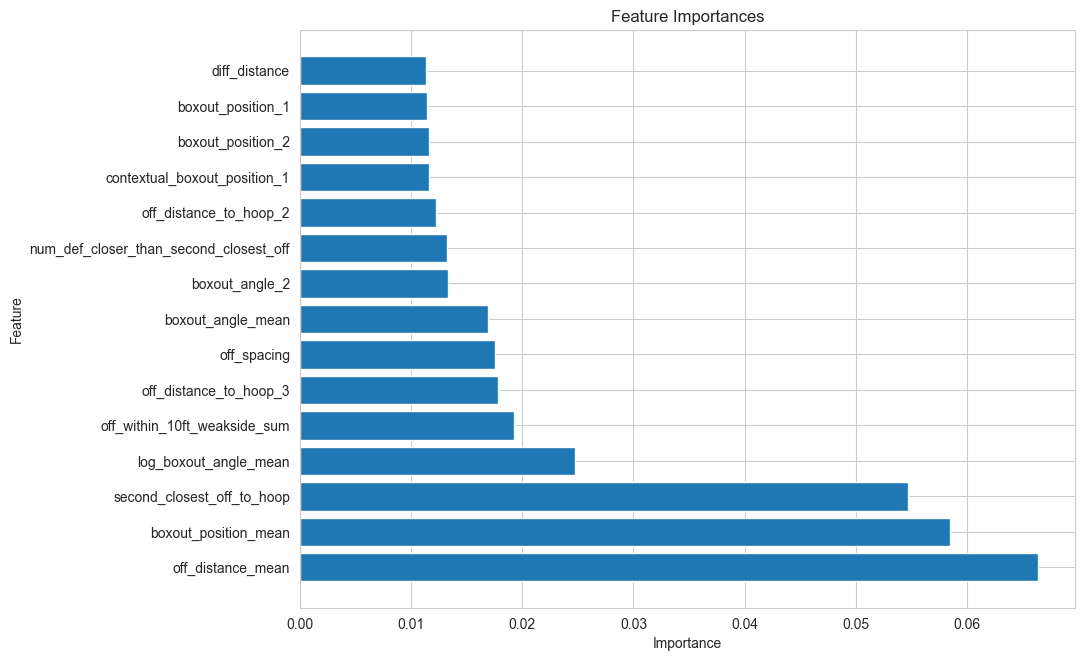

In [123]:
plot_feat_importances(feat_df['columns'].values[:15], feat_df['feat importances'].values[:15])

### **Feature Importance Analysis**

1. **`off_distance_mean`: 0.066**
   - This feature, which represents the average distance of offensive players from the hoop, has emerged as the most influential in our model. It underscores the critical role that the proximity of players to the hoop plays in successful rebounds.

2. **`boxout_position_mean`: 0.058**
   - Coming in second, the average boxout position feature confirms that the positioning of players in relation to their assigned defenders is highly impactful.

3. **`second_closest_off_to_hoop`: 0.055**
   - This feature signifies the distance of the second closest offensive player to the hoop. It points to the importance of having more than one player near the hoop during plays.

4. **`log_boxout_angle_mean`: 0.025**
   - The logarithmic mean of boxout angles reveals the significance of the angular positioning between players and possibly hints at non-linear relationships.

5. **`off_within_10ft_weakside_sum`: 0.019**
   - This feature reflects the sum of offensive players within 10 feet on the weak side of the play, suggesting it has an important role in the model.

6. **`off_distance_to_hoop_3`: 0.018**
   - The distance of the third closest offensive player to the hoop stresses the importance of not just the primary players, but the surrounding teammates as well.

7. **`off_spacing`: 0.018**
   - This feature suggests that the spatial distribution of offensive players on the court has a notable impact on the rebounds's outcomes.

8. **`boxout_angle_mean`: 0.017**
   - The average boxout angle adds weight to the argument that positioning in terms of angles is essential for successful offensive rebounding.

9. **`boxout_angle_2`: 0.013**
   - The boxout angle of the second-best positioned player reinforces the collective importance of player positioning during boxouts.

10. **`num_def_closer_than_second_closest_off`: 0.013**
    - This feature highlights the relevance of how many defenders are closer to the hoop than the second closest offensive player, indicating a team strategy impact.



---

# **Stacking Classifier for Model Ensembling**

When building machine learning models, one popular strategy to enhance the prediction performance is by combining multiple models, a technique commonly known as **ensembling**. One advanced ensembling technique is **stacking**. In this report, we will discuss the choice and implementation of a `StackingClassifier` for a given task.

## What is Stacking?

Stacking involves using multiple base models (first-level models) to make predictions. These predictions are then used as input features for a second-level model (or meta-model) to make the final predictions. This layered structure allows the model to learn from the strengths of each base model, potentially improving overall performance.

## Implementation Details

### Base Models:
1. *XGBoost Classifier*: A gradient boosting model, it's known for high performance and versatility. It's often a go-to algorithm for structured data tasks. The provided parameters include a learning rate of 0.1, max depth of 2, and an evaluation metric of log loss.

    ```python
    XGBClassifier(learning_rate=0.065, n_estimators=112, objective='binary:logistic', 
                  eval_metric='logloss', max_depth=3, min_child_weight=5)
    ```
   
2. *Logistic Regression*: A fundamental algorithm suitable for binary classification tasks. It's parametric and provides probabilities which can be crucial for tasks requiring understanding of uncertainty. The l1 penalty serves as feature selection to address the high dimensionality of our dataset.
   
    ```python
    LogisticRegression(penalty='l1', solver='saga', C=.05, max_iter=500)
    ```

3. *Random Forest Classifier*: An ensemble method itself, built on decision trees. It offers high accuracy and can work on large data without overfitting.

    ```python
    RandomForestClassifier(max_depth=8, max_features='auto', min_samples_leaf= 6, min_samples_split=15, n_estimators=200)
    ```

### Meta-model:

- *Logistic Regression*: It is used as a final estimator in our stacked model. Given that the outputs of our base models are probabilities (since we set `stack_method` to 'predict_proba'), logistic regression can weigh these probabilities to make the final prediction.

    ```python
    LogisticRegression(max_iter=500)
    ```

### Evaluation:

- *Stratified K-Fold Cross-Validation*: A variant of K-Fold CV, it ensures that each fold has the same proportion of observations with a given label. It's especially useful when dealing with imbalanced datasets.

    ```python
    StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    ```

- *Log Loss*: This metric is chosen because it takes into account the probability scores of classifications, which can provide a more nuanced understanding of model performance, especially in cases where understanding model uncertainty is crucial.

### Results:

The average log loss from the 5-fold cross-validation of our stacking model can be computed as:

```python
average_log_loss = -np.mean(scores)



In [124]:
if RUN_CELL:
    # Define base models
    estimators = [
        ('xgb', xgb.XGBClassifier(learning_rate=0.065, n_estimators=112, objective='binary:logistic', 
                              eval_metric='logloss', max_depth=3, min_child_weight=5)),
        ('logistic', LogisticRegression(penalty='l1', solver='saga', C=.05, max_iter=500)),
        ('rfc8', RandomForestClassifier(max_depth=8, max_features='auto', min_samples_leaf= 6, min_samples_split=15, n_estimators=200))
    ]

    # Build stacking classifier
    stacked_model = StackingClassifier(estimators=estimators, 
                                       final_estimator=LogisticRegression(max_iter=500), 
                                       stack_method='predict_proba')

    # Use StratifiedKFold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Score model using log loss
    scores = cross_val_score(stacked_model, X_3, y, cv=kf, scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

    average_log_loss = -np.mean(scores)

    print("Average Log Loss from CV:", average_log_loss)

#### Assessing StackingClassifier Performance
- The mean log loss of `.5781` is the same as the best mean log loss achieved by the best XGBoost model to date
- Potential future experimentation: using additional models to increase model diversity may improve the ensemble's performance.

In [125]:
# Define base models
estimators = [
    ('xgb', xgb.XGBClassifier(learning_rate=0.065, n_estimators=112, objective='binary:logistic', 
                          eval_metric='logloss', max_depth=3, min_child_weight=5)),
    ('logistic', LogisticRegression(penalty='l1', solver='saga', C=.05, max_iter=500)),
    ('rfc8', RandomForestClassifier(max_depth=8, max_features='auto', min_samples_leaf= 6, min_samples_split=15, n_estimators=200))
]

# Build stacking classifier
stacked_model = StackingClassifier(estimators=estimators, 
                                   final_estimator=LogisticRegression(max_iter=500), 
                                   stack_method='predict_proba')

In [126]:
stacked_model.fit(X_3, y)
y_pred = stacked_model.predict_proba(X_3_holdout)[:, 1]

In [127]:
create_submission(holdout_ids, y_pred, '')

---

# **Feature Selection with Baruta Algorithm**

The Boruta algorithm is an all-relevant feature selection method, meaning it aims to find, within a dataset, all features carrying information usable for prediction, rather than just the irreducible minimum. Here's a breakdown of how it operates and why it's significant:

1. *Random Shadow Features Creation:* Boruta works by first duplicating the dataset, then shuffling the values in each feature. These shuffled features are termed "shadow" features. 

2. *Model Importance Calculation:* A model is trained on the dataset with the added shadow features. After training, feature importances are derived. Typically, tree-based models like Random Forest or XGBoost (as in our case) are employed due to their inherent ability to provide feature importance scores.

3. *Feature Ranking:* Boruta compares the importance of real features with the highest importance among shadow features. Features deemed more important than the top shadow feature are tagged as relevant.

4. *Iterative Selection:* This process is iteratively performed, where after each iteration, features deemed unimportant are removed, and shadow features are regenerated for the next cycle. This is done until all features in the dataset are either confirmed or rejected, or a predefined limit of iterations is reached.

5. *Significance:* By leveraging the Boruta algorithm, we can robustly determine which features in our dataset are truly meaningful for our predictive task, thereby enhancing model interpretability and potentially improving generalization performance.

Below, we'll be integrating the Boruta feature selection process with our XGBoost classifier to streamline our feature set for optimal predictive performance.


In [128]:
if RUN_CELL:
    #Define the XGBoost model
    model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                              eval_metric='logloss', max_depth=3, min_child_weight=3)
    np.bool = bool
    np.int = int
    np.float = float
    # Convert X and y to numpy arrays
    X_np = np.array(X_3)
    y_np = np.array(y).ravel()  # Boruta prefers the targets as a 1D array.

    # Initialize Boruta
    boruta_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=42)

    # Fit Boruta
    boruta_selector.fit(X_np, y_np)

In [129]:
if RUN_CELL:
    # Check selected features
    selected_features = X_3.columns[boruta_selector.support_]
    print('Selected Features:')
    print(selected_features)

    # Optionally, you can also get features that Boruta is unsure about
    tentative_features = X_3.columns[boruta_selector.support_weak_]
    print('\nTentative (Unsure) Features:')
    print(tentative_features)

In [130]:
if RUN_CELL:
    # Define the XGBoost model with your architecture
    model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                              eval_metric='logloss', max_depth=3, min_child_weight=3)

    # Convert X and y to numpy arrays (if they aren't already)
    X_np = np.array(X_3[selected_features])
    y_np = np.array(y).ravel()  # Boruta prefers the targets as a 1D array.

    # Select the important features
    X_filtered = X_np.copy()

    # Perform cross-validation using the selected features
    cross_val_scores = cross_val_score(model, X_filtered, y_np, cv=5, scoring='neg_log_loss')

    # Convert negative log loss values to positive log loss
    log_loss_scores = -cross_val_scores

    # Print the average log loss across all folds
    print('Average Log Loss after Boruta feature selection:', log_loss_scores.mean())


#### Assessing Model Performance after Feature Selection
- The model with only the important features selected achieves a log loss of `.5806` which is not an improvement over the previous best XGB model.
- Moving forward the model without feature selection using the Stacking Classifier remains our best predictor.

# **Oversampling Offensive Rebound Examples**

#### Handling Class Imbalance with SMOTE and XGBoost

Given the nature of our dataset, where defensive rebounds significantly outnumber offensive rebounds (our target variable), we need to adopt strategies to mitigate this class imbalance. Imbalanced datasets can often lead to biased models, as they tend to predict the majority class more frequently.

To address this, we'll implement the following methodology:

1. *Model Selection:* We're utilizing the XGBoost classifier.

2. *Cross-Validation Scheme:* We employ StratifiedKFold cross-validation, ensuring each fold retains the same percentage of samples for each class as the entire dataset. This is particularly crucial when dealing with imbalanced data.

3. *Oversampling with SMOTE:* The Synthetic Minority Over-sampling Technique (SMOTE) is an oversampling approach. Instead of replicating the minority samples, SMOTE generates synthetic examples. It operates by selecting two or more similar instances and perturbing an instance one attribute at a time by a random amount within the difference of the instances. We apply SMOTE only to the training data to prevent data leakage.

4. *Evaluation Metric:* Log loss is chosen as the evaluation metric. It provides a robust measure for classification problems, particularly in scenarios where probabilities of class memberships are of interest.

Let's now dive into the implementation and evaluate our approach's effectiveness.

In [131]:
if RUN_CELL:
    # Create the XGBoost model
    model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', 
                              eval_metric='logloss', max_depth=3, min_child_weight=5)

    # Splitting and cross-validation settings
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    smote = SMOTE(random_state=42)
    log_loss_scores = []

    # Performing cross-validation and oversampling within each fold
    for train_idx, test_idx in cv.split(X_3, y):
        X_train, X_test = X_3.iloc[train_idx], X_3.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Apply SMOTE to the training data only
        X_res, y_res = smote.fit_resample(X_train, y_train)

        model.fit(X_res, y_res)
        predictions = model.predict_proba(X_test)[:, 1]  # probabilities of the positive class
        score = log_loss(y_test, predictions)
        log_loss_scores.append(score)

    # Convert the list of log loss scores to a numpy array
    log_loss_scores = np.array(log_loss_scores)

    # Print the average log loss across all folds
    print('Average Log Loss:', log_loss_scores.mean())


#### Evaluating the Results Post-Oversampling

Upon implementing the Synthetic Minority Over-sampling Technique (SMOTE) to address class imbalance, our anticipated improvement in model performance did not materialize as expected. Let's take a closer look at the observed results:

- *Pre-Oversampling Log Loss:* `.5788`
- *Post-Oversampling Log Loss:* `.5966`

From the above results, it's evident that the log loss has deteriorated post-oversampling, implying a reduction in the model's predictive accuracy.

#### Potential Explanation:

*Inherent Data Distribution:* The original dataset captures the real-world distribution of offensive and defensive rebounds. This natural distribution inherently makes the model more conservative about predicting offensive rebounds given their rarity. When we use SMOTE, we might be inadvertently nudging the model away from this real-world distribution, causing it to be less discerning in its predictions.

In conclusion, while oversampling is a powerful tool, it's not a guaranteed solution for all imbalanced datasets.


---

The code from here down represents my attempt at using CNNs and GNNs. The models developed from here forward were not used in the competition. The promising results using tabular data led me to spend less time experimenting with these deep neural nets, but I figured I would include my preprocessing steps and thought process. [Skip to Conclusion](#Conclusion)

---

# **Convolutional Neural Network (CNN) for Spatial Analysis**

In analyzing basketball plays, understanding the spatial configurations of players on the court is pivotal. Positioning, in relation to both teammates and the ball, sheds light on the dynamics of the game. Hence, traditional tabular data might miss out on the essence of these spatial intricacies. Let's explore a method that's tailored for this spatial context.

## Convolutional Neural Networks (CNN)

CNNs have a remarkable track record for processing and interpreting visual data. At its heart, the magic of CNNs lies in its convolutional layers that deftly scan local spatial patterns. In the context of basketball, think of these patterns as arrangements on the court, making CNNs a fitting choice for our analysis.

Our objective in this section is to utilize CNNs for gleaning insights and predicting outcomes based on players' spatial configurations during plays.

## Data Preprocessing

For an effective CNN analysis, our data needs to mirror the spatial nature of the game. This means representing basketball courts as high-res grids, each with channels focusing on specific game aspects:

- *Shooter Channel*: Pinpoints the player making the shot.
- *Offense Channel*: Charts the positions of players on the offense.
- *Defense Channel*: Captures the defensive player positions.
- *Hoop Channel*:    Places the hoop on a grid.

### Steps:
1. **Creating the Court Grid**: The `create_court_grid` function lets us showcase the basketball court in heightened resolutions, say inches. This is like having a blank slate to sketch our plays.
2. **Placing Player Positions**: Using `place_player_positions`, we sketch the player outlines on our slate. This categorization divides players as the shooter, on the offense, or the defense, segregating this info across distinct channels.

This preprocessing sequence transforms our traditional play-by-play data, making it ready for CNN interpretations.


In [132]:
def create_court_grid(court_width, court_height):
    '''
    Create an empty court grid with higher resolution and multiple channels for each play.

    Parameters
    ----------
    court_width : int
        The width of the court grid in the desired higher resolution. For example, the width in inches or feet.

    court_height : int
        The height of the court grid in the desired higher resolution. For example, the height in inches or feet.

    Returns
    -------
    numpy.ndarray
        A 3D NumPy array representing the court grid with high resolution and three channels.
        The dimensions of the array are (court_height, court_width, 3),
        where the three channels represent shooter, offense, and defense.

    Example
    --------
    >>> court_width_inches = 500
    >>> court_height_inches = 940
    >>> grid = create_court_grid(court_width_inches, court_height_inches)
    >>> print(grid.shape)
    (940, 500, 3)
    '''
    return np.zeros((court_height, court_width, 4))



def place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height):
    '''
    Place player positions on the court grid with higher resolution and channels for shooter, offense, and defense.

    Parameters
    ----------
    court_grid : numpy.ndarray
        A 3D NumPy array representing the court grid with higher resolution and three channels.
        The array has dimensions (court_height_inches, court_width_inches, 3), where the three channels
        represent shooter, offense, and defense.

    player_positions : numpy.ndarray
        A 2D NumPy array containing the X and Y coordinates of the player positions.

    shooter_index : int
        The index of the shooter in the player_positions array.

    offense_indices : list
        A list of indices representing the players on offense in the player_positions array.

    defense_indices : list
        A list of indices representing the players on defense in the player_positions array.

    coordinate_multiplier : float
        The multiplier to convert the player positions from feet to the desired higher resolution (e.g., inches).

    Returns
    -------
    None
        This function modifies the court_grid in place, updating the shooter, offense, and defense channels
        based on the player_positions and corresponding indices.
    '''
    for i, (x, y) in enumerate(player_positions):
        x_dist = x * coordinate_multiplier
        y_dist = y * coordinate_multiplier
        if 0 <= x_dist < court_width and 0 <= y_dist < court_height:
            # finding the index of the shooter
            if i == np.argmax(shooter_index):
                court_grid[int(y_dist)][int(x_dist)][0] = 1  # Shooter channel
            # finding the indices of offensive players and comparing to the index
            if i in np.where(offense_indices == 1)[0]:
                court_grid[int(y_dist)][int(x_dist)][1] = 1  # Offense channel
            if i in np.where(defense_indices == 1)[0]:
                court_grid[int(y_dist)][int(x_dist)][2] = 1  # Defense channel
    return court_grid

#### Resolution Choice
- Due to runtime and memory concerns, we will use square foot granularity
- With access to more resources, inches might be a more optimal granularity
- Higher resolution, however, likely would not significantly improve performance because the square foot a player in is a fairly precise representation of their court position

In [133]:
# define the dimensions of the court grid with medium resolution
# depending on runtime, using lower resolution images may be a better approach here, but let's start with feet

coordinate_multiplier = 1
court_width = 94 * coordinate_multiplier
court_height = 50 * coordinate_multiplier

# derive parameters from the data table
player_positions_train = training_data[['court_x', 'court_y']].values
shooter_indices_train = training_data['shooter'].values
offense_indices_train = training_data['offense'].values
defense_indices_train = training_data['offense'].apply(lambda x: 0 if x == 1 else 1).values # Complement of 'offense' column gives 'defense' indices
which_hoop_train = training_data['which_hoop'].values

In [134]:
# derive parameters from the data table
player_positions_test = testing_data[['court_x', 'court_y']].values
shooter_indices_test = testing_data['shooter'].values
offense_indices_test = testing_data['offense'].values
defense_indices_test = testing_data['offense'].apply(lambda x: 0 if x == 1 else 1).values # Complement of 'offense' column gives 'defense' indices
which_hoop_test = testing_data['which_hoop'].values

#### Building Images

These cells will take 10+ minutes to run. npz files are provided for convenience.

In [135]:
# # create image-like training examples with higher resolution and multiple channels
# X_train_images = []
# # reshaping organizes the positions into a list of list of coordinates, so there is one training example per play
# for index, (player_positions, shooter_index, offense_indices, defense_indices, which_hoop_indices) in enumerate(zip(player_positions_train.reshape(-1, 10, 2), shooter_indices_train.reshape(-1, 10), offense_indices_train.reshape(-1, 10), defense_indices_train.reshape(-1, 10), which_hoop_train.reshape(-1, 10))):
#     court_grid = create_court_grid(court_width, court_height)
#     place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height)
#     which_hoop = which_hoop_indices[0]
#     if which_hoop == 0:
#         court_grid[25][4][3] = 1 # basketball hoop channel
#     else:
#         court_grid[25][90][3] = 1
#     X_train_images.append(court_grid)

In [136]:
# # create image-like training examples with higher resolution and multiple channels
# X_test_images = []
# # reshaping organizes the positions into a list of list of coordinates, so there is one training example per play
# for index, (player_positions, shooter_index, offense_indices, defense_indices, which_hoop_indices) in enumerate(zip(player_positions_test.reshape(-1, 10, 2), shooter_indices_test.reshape(-1, 10), offense_indices_test.reshape(-1, 10), defense_indices_test.reshape(-1, 10), which_hoop_test.reshape(-1, 10))):
#     court_grid = create_court_grid(court_width, court_height)
#     place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height)
#     which_hoop = which_hoop_indices[0]
#     if which_hoop == 0:
#         court_grid[25][4][3] = 1 # basketball hoop channel
#     else:
#         court_grid[25][90][3] = 1
#     X_test_images.append(court_grid)

In [137]:
# # Define the file path for saving the data
# save_path = 'X_train_images_with_hoop.npz'

# # Save the data to the file
# np.savez_compressed(save_path, X_train_images=X_train_images)

In [138]:
# # Define the file path for saving the data
# save_path = 'X_test_images_with_hoop.npz'

# # Save the data to the file
# np.savez_compressed(save_path, X_test_images=X_test_images)

In [139]:
# Load the data from the file
save_path = 'data/X_train_images_with_hoop.npz'
loaded_data = np.load(save_path)
X_train_images = loaded_data['X_train_images']

In [140]:
# Load the data from the file
save_path = 'data/X_test_images_with_hoop.npz'
loaded_data = np.load(save_path)
X_test_images = loaded_data['X_test_images']

In [141]:
# converting DataFrames to NumPy arrays
X_train_images = np.array(X_train_images)
X_test_images = np.array(X_test_images)

#### Image Visualization

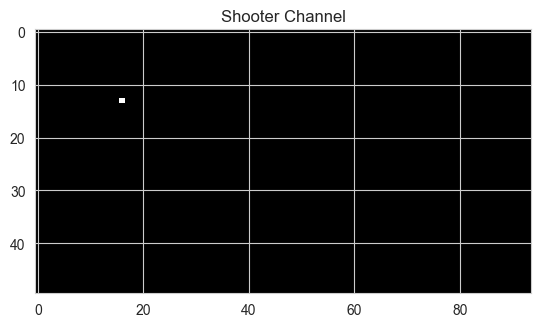

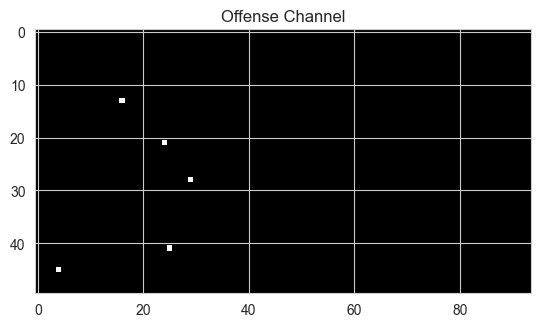

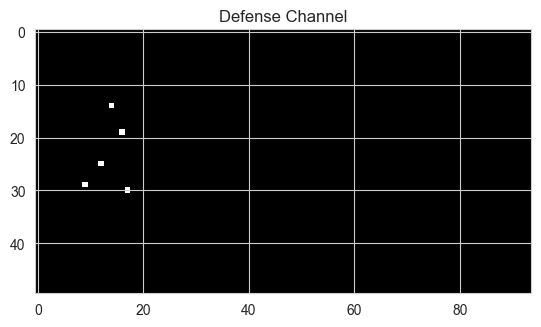

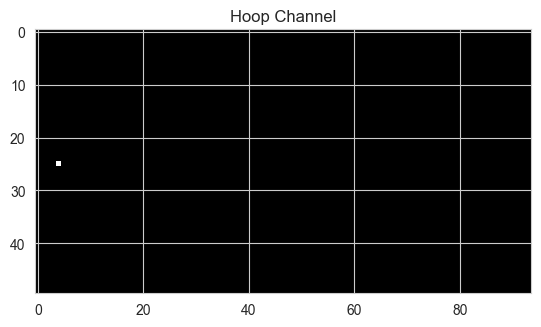

In [142]:
sample_index = 1
# visualize the shooter channel
plt.imshow(X_train_images[sample_index, :, :, 0], cmap='gray')
plt.title('Shooter Channel')
plt.show()

# visualize the offense channel
plt.imshow(X_train_images[sample_index, :, :, 1], cmap='gray')
plt.title('Offense Channel')
plt.show()

# visualize the defense channel
plt.imshow(X_train_images[sample_index, :, :, 2], cmap='gray')
plt.title('Defense Channel')
plt.show()

# visualize the basketball hoop channel
plt.imshow(X_train_images[sample_index, :, :, 3], cmap='gray')
plt.title('Hoop Channel')
plt.show()


The example above illustrates what the different channel images look like for a single play.

## **CNN Model**

### Model Architecture:
- *Convolutional Layers*: The model starts with 32 filters of size 3x3, which should capture basic spatial features. We then double the number of filters to 64 in the next layer, enabling the model to detect more complex patterns and relationships.
- *Pooling Layers*: MaxPooling layers of size 2x2 are used to reduce spatial dimensions, focusing on the most important features and aiding computational efficiency.
- *Regularization*: L2 regularization is applied in the dense layer to mitigate the potential for overfitting, penalizing large weight values that might make the model overly specific to the training data.
- *Output Layer*: A single neuron with a sigmoid activation function is used for our binary classification task, predicting whether a play will result in an offensive rebound or not.


In [143]:
# Split the data into training and validation sets
if RUN_CELL:
    X_train, X_val, y_train, y_val = train_test_split(X_train_images, train_pbp['is_oreb'], test_size=0.2, random_state=42)

In [144]:
if RUN_CELL:   
    # define the CNN model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 94, 4)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01)))
    model.add(layers.Dense(1, activation='sigmoid'))  # sigmoid activation for binary classification

    # compile the model with log loss (binary cross-entropy)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # train the model
    batch_size = 32
    epochs = 10

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

    # evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val)
    print(f'Validation Loss (Log Loss): {loss:.4f}, Validation Accuracy: {accuracy:.4f}')


#### CNN Training Results

The Convolutional Neural Network (CNN) model was trained over 10 epochs. The results from each epoch are outlined below:

| Epoch | Training Loss | Training Accuracy | Validation Loss | Validation Accuracy |
|-------|---------------|-------------------|-----------------|---------------------|
| 1     | 0.6178        | 71.76%            | 0.5969          | 71.81%              |
| 2     | 0.5953        | 71.81%            | 0.5915          | 71.81%              |
| 3     | 0.5918        | 71.81%            | 0.5894          | 71.81%              |
| 4     | 0.5900        | 71.81%            | 0.5906          | 71.81%              |
| 5     | 0.5893        | 71.81%            | 0.5882          | 71.81%              |
| 6     | 0.5886        | 71.81%            | 0.5873          | 71.81%              |
| 7     | 0.5881        | 71.81%            | 0.5901          | 71.81%              |
| 8     | 0.5878        | 71.81%            | 0.5854          | 71.81%              |
| 9     | 0.5881        | 71.81%            | 0.5874          | 71.81%              |
| 10    | 0.5873        | 71.81%            | 0.5866          | 71.81%              |

Upon final evaluation after the 10th epoch, the model achieved:
- **Validation Loss (Log Loss)**: 0.5866
- **Validation Accuracy**: 71.81%

#### Future Steps

1. *Further Experimentation with Complexity and Architecture*:
    - My approach to this point has been to continuously readjust the architecture.
    - The current architecture might be too simplistic for the complexity of the task (it does not overfit).
    - **Potential Experiment**: Introduce more convolutional layers, experiment with different filter sizes, or consider deeper architectures. Dropout layers could also be introduced to reduce overfitting.

2. *Further Hyperparameter Tuning*:
    - My approach to this point has been to iteratively adjust the hyperparameters to avoid overfitting and minimize validation loss.
    - Fine-tuning the model's hyperparameters could yield improvements in performance.
    - **Potential Experiment**: Utilize grid search or random search strategies with tools like Keras Tuner or Scikit-learn's GridSearchCV for exhaustive searches. Bayesian optimization libraries like Optuna may also be useful.

3. *Data Augmentation through Image Rotation*:
    - One common bottleneck in training deep learning models, especially CNNs, is the lack of sufficient training data.
    - Data augmentation is a well-established technique to artificially increase the size of the training dataset. By applying minor transformations to the input images, we can create "new" training examples without actually collecting new data.
    - **Potential Experiment**: Implement image rotation as a form of augmentation. Rotating the images by various degrees can provide different perspectives and increase the robustness of the model.

These future steps would be more realistic with more compute power, as hyperparameter searches can take hours on end.

---

# **Graph Neural Networks (GNNs) for Spatial Analysis**

Graph Neural Networks (GNNs) provide an alternative paradigm to traditional deep learning techniques by focusing on graph-structured data. In the context of basketball plays, players can be represented as nodes, and their relationships as edges. GNNs can help exploit the intricate inter-player interactions and relationships present on the court. The presented code offers an insight into the usage of GNNs for this problem. Below are some highlights and rationale behind the choices made:

### Data Preprocessing:
1. *Normalization*: All coordinates (both for the court and the hoop) are normalized to ensure consistent scaling, which aids in convergence and model training. This is crucial when computing distances and relationships.
2. *Data Construction*: Each play is transformed into a graph representation. The attributes like 'offense', 'shooter', 'which_hoop', etc., serve as node features. The pairwise Euclidean distances between players help form the adjacency matrix, highlighting player-player spatial relationships.

### GNN Model Architecture:
1. *Graph Attention (GAT)*: The model employs Graph Attention Layers (GATConv from PyTorch Geometric) that allow nodes to focus on their more influential neighbors, thus capturing intricate local and global patterns.
2. *Pooling Layer*: A Set2Set layer acts as a pooling mechanism. It aggregates node features to generate a graph-level representation, making it suitable for graph classification tasks.
3. *Output Layer*: A single output neuron is employed since this is a binary classification task. The model's goal is to predict if a play will result in an offensive rebound.

### Training & Testing:
- *Adam Optimizer*: A popular optimization technique for deep learning tasks, ensuring efficient and effective convergence.
- *Model Evaluation*: The model's performance is monitored using the loss computed on both training and test datasets. By observing these values over epochs, we can see the model's progression in learning the underlying patterns.

### Insights:
1. *Graphs in Sports Analytics*: Employing GNNs in sports analytics, as shown, can offer unique insights that might be missed by traditional models. By treating players as interconnected nodes, we can capture strategies, formations, and patterns that emerge during plays.
2. *Flexibility & Expansion*: While the provided architecture offers a starting point, GNNs are flexible. Adding more layers, varying attention mechanisms, or incorporating other node/edge features can further improve performance and insights.

In conclusion, this application of GNNs can revolutionize how we analyze and understand basketball plays, shedding light on patterns and strategies beyond raw stats.


In [145]:
graph_training = training_data.copy()
graph_testing = testing_data.copy()

In [146]:
graph_training['hoop_x'] = graph_training['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
graph_training['hoop_y'] = 25
graph_testing['hoop_x'] = graph_testing['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
graph_testing['hoop_y'] = 25
graph_training = graph_training.merge(train_pbp[['id', 'is_oreb']], on='id', how='left')

#### **Scaling the Data**
- Once again, we fit the scaler on the training data and transform the test.
- We use a MinMaxScaler because we are working with coordinate data.
- We only fit on the player coordinates, so that the hoop remains in its relative position to the players after scaling.

In [147]:
graph_scaler = MinMaxScaler()
normalized_coords = pd.DataFrame()
normalized_coords_test = pd.DataFrame()

normalized_coords[['court_x', 'court_y']] = graph_scaler.fit_transform(graph_training[['court_x', 'court_y']].values)
normalized_coords[['hoop_x', 'hoop_y']] = graph_scaler.transform(graph_training[['hoop_x', 'hoop_y']])
normalized_coords_test[['court_x', 'court_y']] = graph_scaler.transform(graph_testing[['court_x', 'court_y']])
normalized_coords_test[['hoop_x', 'hoop_y']] = graph_scaler.transform(graph_testing[['hoop_x', 'hoop_y']])

In [148]:
graph_training[['court_x', 'court_y', 'hoop_x', 'hoop_y']] = normalized_coords
graph_testing[['court_x', 'court_y', 'hoop_x', 'hoop_y']] = normalized_coords_test

#### **Compiling the Graph**

In [149]:
graph_training['hoop'] = 0

This cell will takes 10+ minutes to run. The code from here down is not used in submissions.

In [150]:
 if RUN_CELL:   
    plays = graph_training['id'].unique()
    data_list = []

    for play in plays:
        play_df = graph_training[graph_training['id'] == play]

        # Add hoop as a node
        hoop_node = {'court_x': play_df['hoop_x'].iloc[0], 'court_y': play_df['hoop_y'].iloc[0], 'offense': 0, 'shooter': 0, 'hoop': 1}
        play_df = play_df.append(hoop_node, ignore_index=True)

        x = torch.tensor(play_df[['court_x', 'court_y', 'offense', 'shooter', 'hoop']].values, dtype=torch.float)
        y = torch.tensor([play_df['is_oreb'].values[0]], dtype=torch.float)

        # Calculate pairwise Euclidean distances including the hoop
        distances = squareform(pdist(play_df[['court_x', 'court_y']].values))

        # Take inverse of distances for non-zero entries
        with np.errstate(divide='ignore'):  # Ignore divide by zero warning, will handle inf values next
            inv_distances = 1.0 / distances
        inv_distances[inv_distances == np.inf] = 0  # Set diagonal (infinite values) to 0

        # Form the edge_index and edge_weight tensors
        edge_index = torch.tensor(np.where(inv_distances), dtype=torch.long)
        edge_weights = torch.tensor(inv_distances[edge_index[0], edge_index[1]], dtype=torch.float)

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights, y=y)
        data_list.append(data)


In [151]:
if RUN_CELL:  
    # Split data into train and test
    train_data_list, test_data_list = train_test_split(data_list, test_size=0.2, random_state=42)
    train_loader = DataLoader(train_data_list, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data_list, batch_size=32)

#### Defining the Architecture

The torch-scatter library would not cooperate with Kaggle, so the architecture will not run in Kaggle.

In [152]:
if RUN_CELL:
    class AttentivePooling(torch.nn.Module):
        def __init__(self, in_dim, global_context_dim):
            super(AttentivePooling, self).__init__()
            
            self.global_context = torch.nn.Linear(in_dim, global_context_dim)
            # print("Global context layer weights:", self.global_context.weight.shape)

            self.attention_weights = torch.nn.Linear(global_context_dim + in_dim, 1)
            # print("Attention weights layer shape:", self.attention_weights.weight.shape)


        def forward(self, x, batch):
            # Compute the global context
            gc = scatter_mean(x, batch, dim=0)
            # print("Mean features per graph:", gc.shape)
            # print("Contents of gc:", gc[:5])


            #print("Global context per graph:", gc)
            gc = torch.tanh(self.global_context(gc))
            # print("Transformed global context:", gc.shape)
            # print("Contents of gc after activation:", gc[:5])

                
            # Broadcast the global context to every node in the batch
            gc_broadcasted = gc[batch]
            # print("Broadcasted global context:", gc_broadcasted.shape)
            # print("Contents of gc_broadcast:", gc_broadcasted[:5])
                
            # Concatenate the global context with node features
            concat = torch.cat([x, gc_broadcasted], dim=1)
            # print("Concatenated feature shape:", concat.shape)
            # print("Contents of concat:", concat[:5])

            # print(self.attention_weights(concat)) 
            # Compute attention scores
            att_scores = torch.nn.functional.softmax(self.attention_weights(concat), dim=1)
            # print("Shape of attention scores:", att_scores.shape)
            # print("Attention scores for each node:", att_scores[:25])
                
            # Compute the pooled representation for the entire graph
            pooled_representation = scatter_add(att_scores.view(-1, 1) * x, batch, dim=0)
            # print("Shape of pooled representation", pooled_representation.shape)
            
            return pooled_representation


    class MyGCNModel(torch.nn.Module):
        def __init__(self, input_dim, hidden_dim, global_context_dim, output_dim=1):
            super(MyGCNModel, self).__init__()

            self.conv1 = GCNConv(input_dim, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, hidden_dim)
            self.pooling = AttentivePooling(hidden_dim, hidden_dim)
            self.fc = torch.nn.Linear(hidden_dim, output_dim)

        def forward(self, data):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            edge_weight = data.edge_attr.squeeze(-1)  # Assuming edge_attr is [num_edges, 1]
            
            x = F.relu(self.conv1(x, edge_index, edge_weight))
            # print("Shape of x after first conv:", x.shape)

            x = F.relu(self.conv2(x, edge_index, edge_weight))
            # print("Shape of x after second conv:", x.shape)

            x = self.pooling(x, batch)
            x = self.fc(x)
            
            return x


    class MyGNNModel(torch.nn.Module):
        def __init__(self, input_dim, hidden_dim, global_context_dim, output_dim=1):
            super(MyGNNModel, self).__init__()

            self.conv1 = GATConv(input_dim, hidden_dim)
            self.conv2 = GATConv(hidden_dim, hidden_dim)
            self.pooling = AttentivePooling(hidden_dim, hidden_dim)
            self.fc = torch.nn.Linear(hidden_dim, output_dim)

        def forward(self, data):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            
            x = F.relu(self.conv1(x, edge_index))
            x = F.relu(self.conv2(x, edge_index))
            x = self.pooling(x, batch)
            x = self.fc(x)
            return x


In [153]:
if RUN_CELL:    
    input_dim = 5  #court_x, court_y, offense, shooter, hoop
    hidden_dim = 6
    global_context_dim = 4 

    model = MyGCNModel(input_dim=input_dim, hidden_dim=hidden_dim, global_context_dim=global_context_dim)


    criterion = BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=0.1)

#### Train and Evaluate the Model

In [154]:
if RUN_CELL:
    # Train the model
    def train(model, loader, criterion, optimizer):
        model.train()

        total_loss = 0
        for data in loader:
            # print(data.edge_attr)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out.view(-1), data.y.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.num_graphs

        return total_loss / len(loader.dataset)

    # Test the model
    def test(model, loader):
        model.eval()

        total_loss = 0
        for data in loader:
            with torch.no_grad():
                out = model(data).view(-1)
                loss = criterion(out.view(-1), data.y.view(-1))
                total_loss += loss.item() * data.num_graphs
                #output = torch.sigmoid(out)
        return total_loss / len(loader.dataset)

if RUN_CELL:
    # Run the training process
    for epoch in range(25):
        train_loss = train(model, train_loader, criterion, optimizer)
        test_loss = test(model, test_loader)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}')

#### GNN Results and Analysis

- *Consistent Test Loss*: Over the epochs, the test loss remained consistent without any significant improvements. Specifically, starting from a loss of `0.5955` in the first epoch, the loss wavered around the `0.595` mark, with no discernible decline.

- *Stagnant Training Loss*: The training loss showcased a similar trend, hovering around `0.595` throughout the epochs. This indicates that the GNN struggles to identify patterns in the graph data, and the network's learning is static.

- *Uniform Predictions*: A concerning observation is that the GNN produces nearly identical predictions for all graphs. This behavior suggests that the model might be converging to a naive solution, simply predicting the probability that minimizes the log loss when applied uniformly to all examples.

#### Future Considerations

1. *Model Architecture & Complexity*: The current GNN might be too simplistic or might not be the right fit for the intricacies of the graph data. It's worth revisiting the architecture, experimenting with additional layers, or even considering other graph neural network variants.
 
2. *Training Strategy*: Since the model seems to converge to a single probability for all graphs, it might be helpful to modify the training regimen. Techniques such as different initialization methods, learning rate schedules, or alternative optimization algorithms could potentially help the model escape this local minimum.

3. *Feature Engineering*: Investigate the node and edge features of the graph. There might be an opportunity to improve the model's performance by introducing new features or optimizing the existing ones.

Given the observations and challenges faced with the GNN, further experimentation and alternative approaches are recommended to achieve better results.


---

# **Conclusion**

Throughout this extensive analysis, we have employed a series of advanced methodologies to unravel insights and enhance the predictive capability of our models. Let's reflect on our journey:

1. **Exploratory Data Analysis & Data Preprocessing**: The foundation of our work, this stage provided us with invaluable insights about the dataset and guided subsequent stages of modeling.

2. **Complex Feature Engineering**: Incorporating features like the boxout position added a layer of depth to our analysis, potentially enabling our models to uncover intricate relationships within the data.

3. **Model Experimentation**: Different models showcased diverse strengths and challenges. While the XGBoost model benefited from more compact tree structures, emphasizing the risk of overfitting in our dataset, the Random Forest Classifier favored slightly deeper trees, suggesting underlying complexities in the data.

4. **Convolutional Neural Network (CNN) for Spatial Analysis**: A groundbreaking approach for this data, the CNN's potential wasn't fully realized, suggesting that perhaps spatial patterns weren't as defining for our target variable or the model architecture needed further refinement.

5. **Graph Neural Networks (GNNs) for Spatial Analysis**: Our foray into GNNs showcased the challenges of adopting novel methods. The model’s inability to learn the graph patterns highlighted the need for more intricate preprocessing or tuning. Yet, it set the foundation for potential future investigations. Spatio-temporal features have been critical to the success of other sports GNNs, so this is worth revisiting with more granular data.

6. **Stacking Classifier for Model Ensembling**: A robust technique, this showcased the power of combining models to capitalize on their individual strengths.

7. **Feature Selection with the Boruta Algorithm**: By trimming the fat and focusing on impactful features, we saw which features were most helpful in predicting offensive rebounding.

8. **Oversampling Offensive Rebound Examples**: Addressing the imbalance in our dataset was not helpful in improving model performance. The use of the SMOTE technique upset the natural distribution of offensive rebounding

In summation, this analysis underscores the significance of iterative experimentation in data science. While certain techniques like XGBoost and Random Forest showed promise, others like CNNs and GNNs demand further scrutiny. This project serves as a testament to the fact that, in the realm of data science, both successes and failures pave the way for deeper understanding and innovation.

## Key Basketball Strategy Insights
- This investigation uncovered the significance of having multiple players near the basket. At every stage of modeling, the positioning of the second best positioned offensive player was more important than the best positioned offensive player's positioning.
- Coaches may find this information valuable and do the following:
    - Run more plays with someone in the dunker spot.
    - Design plays that designate players to crash the boards anticipating when a shot will go up.

## Potential Basketball Statistic
- `Boxout Position` was among the best features developed and was instrumental in achieving the best model scores in this notebook.
- **OFFREB+** could be a valuable statistic that multiplies the offensive player's offensive rebounding rate by a normalizing factor for their average boxout position faced.
- This statistic would be invaluable in assessing individual performance against expectation when it comes to offensive rebounding.

---
$$ \text{OFFREB+} =  \text{Offensive Rebounding Rate} \times \frac{\text{Player Boxout Position Average}}{\text{Global Boxout Position Average}} $$
---



---
